In [1]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.5 MB/s eta 0:00:00


# 1. Problem Statement and Data Description

**Problem Statement:**
Prevent overstocking and understocking of Items by forecasting demand of items for the next week, based on historical data.


<img src = 'retail-shopping-business-wallpaper-preview.jpg' width = 500 height = 500>

**Data Description:**

Train Data-
- **WEEK_END_DATE** - week ending date
- **STORE_NUM** - store number
- **UPC** - (Universal Product Code) product specific identifier
- **BASE_PRICE** - base price of item
- **DISPLAY** - product was a part of in-store promotional display
- **FEATURE** - product was in in-store circular
- **UNITS** - units sold (target)

Product Data-
- **UPC** - (Universal Product Code) product specific identifier
- **DESCRIPTION**	- product description
- **MANUFACTURER** - product	manufacturer
- **CATEGORY** - category of product
- **SUB_CATEGORY** - sub-category of product
- **PRODUCT_SIZE** - package size or quantity of product

Store Data-
- **STORE_ID** - store number
- **STORE_NAME** - Name of store
- **ADDRESS_CITY_NAME** - city
- **ADDRESS_STATE_PROV_CODE** - state
- **MSA_CODE** - (Metropolitan Statistical Area) Based on geographic region and population density
- **SEG_VALUE_NAME** - Store Segment Name
- **PARKING_SPACE_QTY** - number of parking spaces in the store parking lot
- **SALES_AREA_SIZE_NUM** - square footage of store
- **AVG_WEEKLY_BASKETS** - average weekly baskets sold in the store

# 2. Loading Required Libraries and Datasets

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context('notebook',font_scale=1.5)

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

We are provided with three tables containing the required information:

- **product_data**: Consists of details about the product
- **store_data**: Consists of details of various stores associated with the retailer  
- **train**: Contains transaction data of products

In [3]:
# reading the data files
train = pd.read_csv('train.csv')
product_data = pd.read_csv('product_data.csv')
store_data = pd.read_csv('store_data.csv')

In [4]:
# checking the size of the dataframes
train.shape, product_data.shape, store_data.shape

((232287, 8), (30, 6), (76, 9))

# 3. Understanding and Validating Data

### Train Data

In [5]:
# printing first 5 rows of the train file
train.head()

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   
2     14-Jan-09        367  1111085319   1.88        1.88        0        0   
3     14-Jan-09        367  1111085345   1.88        1.88        0        0   
4     14-Jan-09        367  1111085350   1.98        1.98        0        0   

   UNITS  
0     13  
1     20  
2     14  
3     29  
4     35

In [6]:
# checking datatypes of columns in train file
train.dtypes

WEEK_END_DATE     object
STORE_NUM          int64
UPC                int64
PRICE            float64
BASE_PRICE       float64
FEATURE            int64
DISPLAY            int64
UNITS              int64
dtype: object

- WEEK_END_DATE has the data type object, but its a datetime variable
- The store number and product codes are read as int, but these are categorical variables.

#### Datetime variable

- The data is captured for what duration?
- What are the start and end dates?
- Is there any missing data points?

#### Numerical Variables

- Check the distribution of numerical variables
- Are there any extreme values?
- Are there any missing values in the variables?

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?


##### WEEK_END_DATE


In [7]:
# convert into the date time format
train['WEEK_END_DATE'] = pd.to_datetime(train['WEEK_END_DATE'])

In [8]:
train['WEEK_END_DATE'].isnull().sum()

0

In [9]:
train['WEEK_END_DATE'].min(), train['WEEK_END_DATE'].max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

- The data collected is from January 2009 to September 2011.

#### Are any dates missing from this period?

In [10]:
(train['WEEK_END_DATE'].max() - train['WEEK_END_DATE'].min())/7

Timedelta('141 days 00:00:00')

In [11]:
train['WEEK_END_DATE'].nunique()

142

- The training data is for 142 weeks, based on the number of unique *weekend dates* in the train file.
- No dates are missing from this period.

#### Are all dates at a gap of a week?

In [12]:
train['WEEK_END_DATE'].dt.day_name().value_counts()

Wednesday    232287
Name: WEEK_END_DATE, dtype: int64

In [13]:
train['WEEK_END_DATE'].dt.day_name().value_counts()

Wednesday    232287
Name: WEEK_END_DATE, dtype: int64

##### STORE_NUM  and UPC

In [14]:
train[['STORE_NUM', 'UPC']].isnull().sum()

STORE_NUM    0
UPC          0
dtype: int64

In [15]:
train['STORE_NUM'].nunique()

76

In [16]:
(train['STORE_NUM'].value_counts()).sort_values()

8035     1676
23055    1823
2523     1977
11967    2104
15755    2253
         ... 
2277     3824
21237    3950
9825     3955
24991    3967
2513     4098
Name: STORE_NUM, Length: 76, dtype: int64

- We have 76 unique stores.
- Every store has minimum of 1676 transactions.

#### Does each store hold atleast one entry per week?

We have 76 unique stores and 142 weeks of data for the sales. If each store is selling occupies atleast one row in the data, the minimum number of unique rows should be 142*76

In [17]:
142*76

10792

In [18]:
train[['WEEK_END_DATE','STORE_NUM']].drop_duplicates().shape

(10792, 2)

- Implies that each store is atleast selling 1 product each week

In [19]:
train['UPC'].nunique()

30

In [20]:
(train['UPC'].value_counts()).sort_values()

3700044982       975
3700031613      1664
31254742835     2086
7797508004      2386
1111038080      2797
7797508006      2933
31254742735     3202
7218063052      3641
7797502248      6916
1111038078      7131
2840004770      7636
1111009507      8067
1111087396      8131
1111087395      8155
2840004768      8488
7192100336      9126
1111087398      9989
1111009477     10356
1111009497     10498
7192100337     10588
1111085319     10636
3800031829     10640
3800039118     10766
7192100339     10767
1111085350     10775
3800031838     10785
1600027564     10786
1600027528     10788
1111085345     10789
1600027527     10790
Name: UPC, dtype: int64


#### Is every product sold atleast once, for all 142 weeks?

In [21]:
142*30

4260

In [22]:
train[['WEEK_END_DATE','UPC']].drop_duplicates().shape

(4260, 2)

- We have 30 unique products in the training data
- There are 76 different stores associated with the retailer
- Both the variables do not have any missing values

#### Is each store selling each product throughout the given period?

Assuming we have information for the sale of every product that is present in the product table (30), against each store associated (76), and for every week (142); we should have 142*76*30 data rows.

In [23]:
142*76*30

323760

In [24]:
train.shape

(232287, 8)

In [25]:
232286/323760

0.7174635532493204

- We can conclude that all stores are not selling all products each week
- Of all the possible combinations, about 72% of the data is present

#### For a store selling a particular product, do we have more than one entry?


Each product sold by any store should hold only one row, i.e. a particular store, say 'store A' selling a product 'prod P' should contribute a single row for every week. Let us check that.

In [26]:
train.shape

(232287, 8)

In [27]:
train[['WEEK_END_DATE','STORE_NUM','UPC']].drop_duplicates().shape

(232287, 3)

In [28]:
train.groupby(['WEEK_END_DATE','STORE_NUM'])['UPC'].count().mean()

21.523999258710155

- The shape does not change after using drop duplicates
- Implies that there are unique combinations for week, store and UPC
- On an average, each week we are selling 22 products

#### Is a store selling a product throughout the period or is there a break?

In [29]:
(train.groupby(['STORE_NUM', 'UPC'])['UNITS'].count()).sort_values()

STORE_NUM  UPC       
4489       1111087396    137
19265      7797508006    137
21221      7797508004    137
6187       1111038080    137
23349      2840004768    137
                        ... 
11993      1111085345    142
           1111085319    142
           1111038080    142
           1600027564    142
29159      7797508004    142
Name: UNITS, Length: 1644, dtype: int64

- Not all stores sell a product throughout the week
- The minimum number is 137/142

We now have a basic understanding of the number of products and stores we are dealing with in this data.

##### BASE_PRICE

In [30]:
train['BASE_PRICE'].isnull().sum()

12

In [31]:
train['BASE_PRICE'].describe()

count    232275.000000
mean          3.345204
std           1.678181
min           0.860000
25%           1.950000
50%           2.990000
75%           4.080000
max           7.890000
Name: BASE_PRICE, dtype: float64

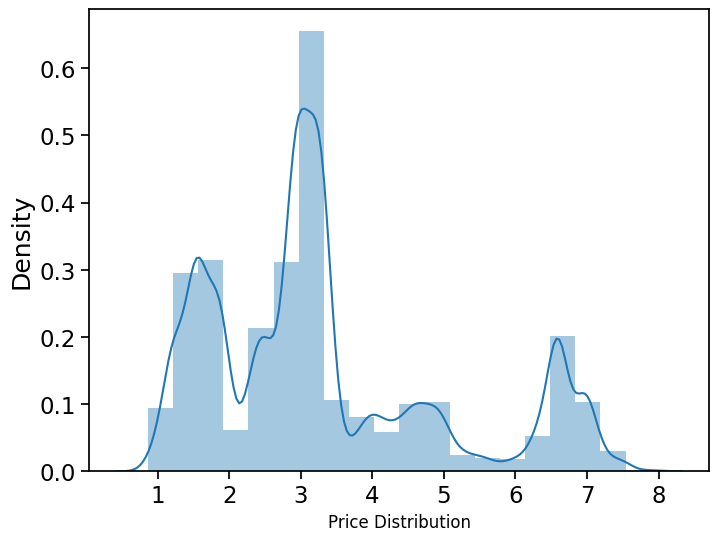

In [32]:
# distribution of Base Price variable
plt.figure(figsize=(8,6))
sns.distplot((train['BASE_PRICE'].values), bins=20, kde=True)
plt.xlabel('Price Distribution', fontsize=12)
plt.show()

- No extreme values in the base price variable
- Range for base price is 1 dollar to 8 dollars

##### FEATURE and DISPLAY

In [33]:
train[['FEATURE','DISPLAY']].isnull().sum()

FEATURE    0
DISPLAY    0
dtype: int64

In [34]:
train[['FEATURE','DISPLAY']].dtypes

FEATURE    int64
DISPLAY    int64
dtype: object

In [35]:
train[['FEATURE','DISPLAY']].nunique()

FEATURE    2
DISPLAY    2
dtype: int64

In [36]:
train['FEATURE'].value_counts(normalize=True)

0    0.900111
1    0.099889
Name: FEATURE, dtype: float64

<Axes: >

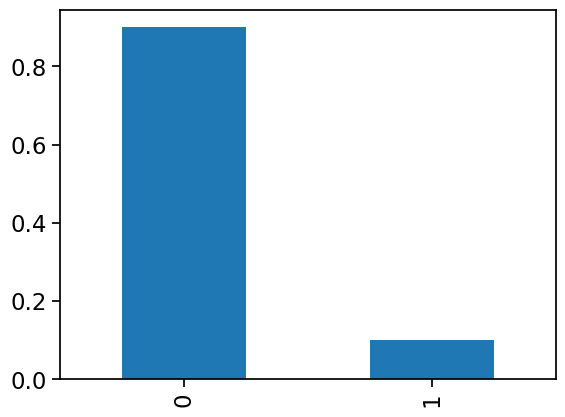

In [37]:
train['FEATURE'].value_counts(normalize=True).plot(kind='bar')

- Approximately 10 percent of product are featured

In [38]:
train['DISPLAY'].value_counts(normalize=True)

0    0.864999
1    0.135001
Name: DISPLAY, dtype: float64

<Axes: >

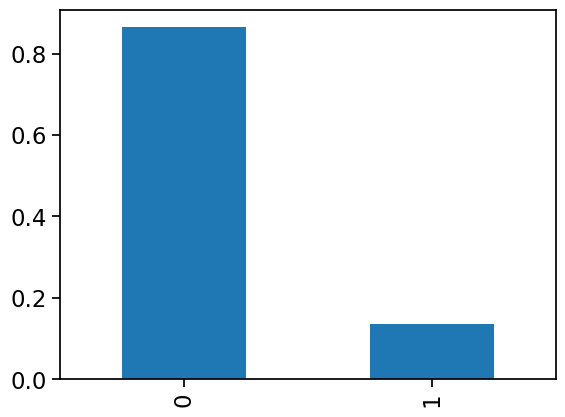

In [39]:
train['DISPLAY'].value_counts(normalize=True).plot(kind='bar')

- About 13% of products are on display

In [40]:
pd.crosstab(train['FEATURE'], train['DISPLAY']).apply(lambda r: r/len(train), axis=1)

DISPLAY         0         1
FEATURE                    
0        0.821824  0.078287
1        0.043175  0.056714

##### UNITS

In [41]:
train['UNITS'].isnull().sum()

0

In [42]:
# basic statistical details of UNITS variable
train['UNITS'].describe()

count    232287.000000
mean         28.063525
std          35.954341
min           0.000000
25%           9.000000
50%          18.000000
75%          34.000000
max        1800.000000
Name: UNITS, dtype: float64

- The Range of values is very high
- Minimum number of units sold is 0 and maximum is 1800
- A huge difference between the 75th percentile and the max value indicates presence of outliers

#### How many rows in the data have 0 units sold?
#### Is there only one row with such high sales of 1800?

In [43]:
train[train['UNITS'] == 0]

WEEK_END_DATE  STORE_NUM          UPC  PRICE  BASE_PRICE  FEATURE  \
76752    2009-12-02      28909  31254742735    NaN        4.99        0   

       DISPLAY  UNITS  
76752        0      0

- Only one entry with 0 items sold
- Indicates the given store does not sell the following item
- It's simply a Data Anomaly and will not be useful in model training

In [44]:
# keeping rows with UNITS sold not equal to zero
train = train[train['UNITS'] != 0]

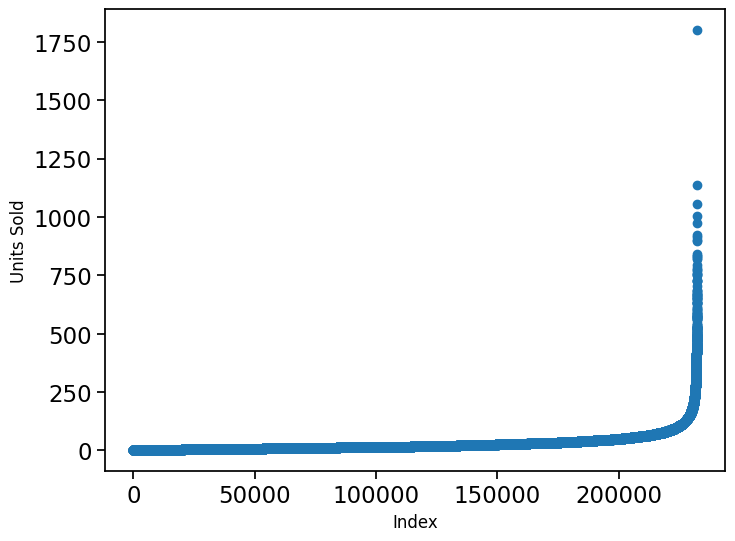

In [45]:
# scatter plot for UNITS variable
plt.figure(figsize=(8,6))
plt.scatter(x = range(train.shape[0]), y = np.sort(train['UNITS'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

- Most of the values are less than 250
- There are a few outliers (with 1 outlier way outside the range)

In [46]:
train[train['UNITS'] > 1000]

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  \
7893     2009-02-11      24991  1600027527   1.67        3.19        1   
7960     2009-02-11      25027  1600027527   1.64        3.19        1   
9597     2009-02-18      25027  1600027527   1.60        3.19        0   
11209    2009-02-25      25027  1600027527   1.64        3.19        1   

       DISPLAY  UNITS  
7893         0   1006  
7960         1   1800  
9597         1   1054  
11209        1   1136

To reduce the effect of outliers and for better visualization, here is a log transform of the variable


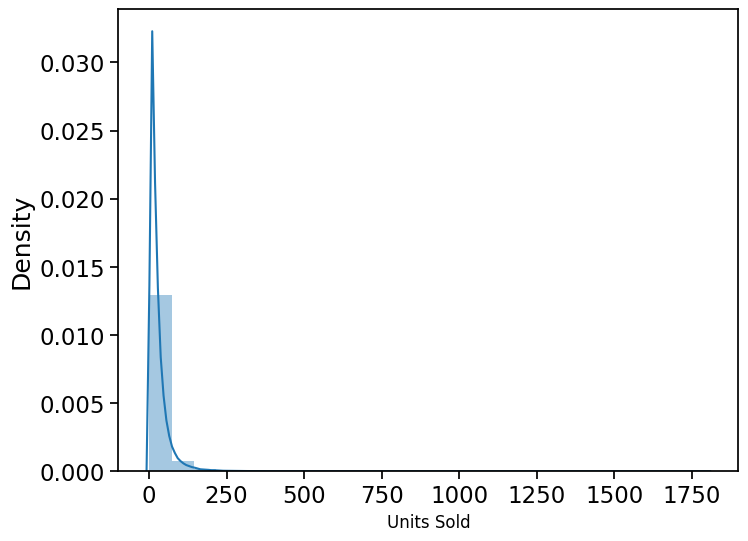

In [47]:
# distribution of UNITS variable
plt.figure(figsize=(8,6))
sns.distplot((train['UNITS'].values), bins=25, kde=True)
plt.xlabel('Units Sold', fontsize=12)
plt.show()

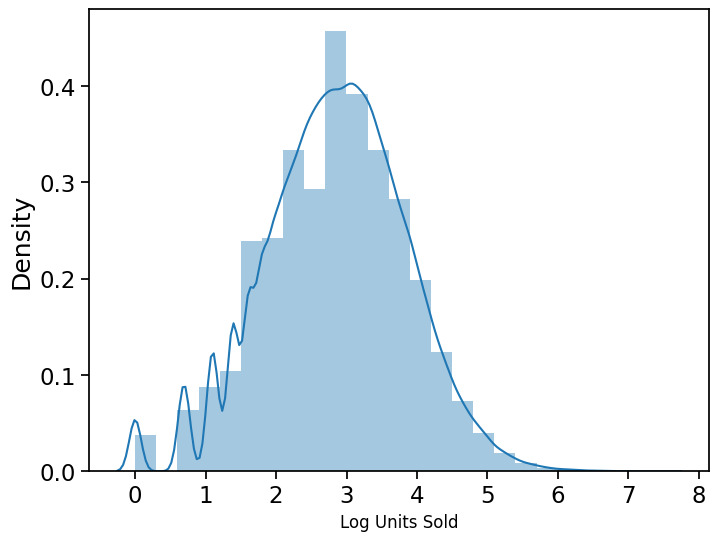

In [48]:
# log transformed UNITS column
plt.figure(figsize=(8,6))
sns.distplot(np.log(train['UNITS'].values), bins=25, kde=True)
plt.xlabel('Log Units Sold', fontsize=12)
plt.show()

- After log transformation, the distribution looks closer to a normal distribution

### Understanding Product Data

In [49]:
# first five rows of product data
product_data.head()

UPC               DESCRIPTION   MANUFACTURER               CATEGORY  \
0  1111009477    PL MINI TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
1  1111009497         PL PRETZEL STICKS  PRIVATE LABEL             BAG SNACKS   
2  1111009507         PL TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
3  1111038078  PL BL MINT ANTSPTC RINSE  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   
4  1111038080  PL ANTSPTC SPG MNT MTHWS  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   

               SUB_CATEGORY PRODUCT_SIZE  
0                  PRETZELS        15 OZ  
1                  PRETZELS        15 OZ  
2                  PRETZELS        15 OZ  
3  MOUTHWASHES (ANTISEPTIC)       500 ML  
4  MOUTHWASHES (ANTISEPTIC)       500 ML

In [50]:
product_data.dtypes

UPC              int64
DESCRIPTION     object
MANUFACTURER    object
CATEGORY        object
SUB_CATEGORY    object
PRODUCT_SIZE    object
dtype: object

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?

##### UPC

In [51]:
product_data['UPC'].nunique()

30

- The number is consistent through the train and product data.
##### Are all the product codes exactly the same?

In [52]:
len(set(product_data.UPC).intersection(set(train.UPC)))

30

##### CATEGORY

In [53]:
# number and list of unique categories in the product data
product_data['CATEGORY'].nunique(), product_data['CATEGORY'].unique()

(4,
 array(['BAG SNACKS', 'ORAL HYGIENE PRODUCTS', 'COLD CEREAL',
        'FROZEN PIZZA'], dtype=object))

In [54]:
product_data['CATEGORY'].isnull().sum()

0

In [55]:
product_data['CATEGORY'].value_counts()

COLD CEREAL              9
BAG SNACKS               8
FROZEN PIZZA             7
ORAL HYGIENE PRODUCTS    6
Name: CATEGORY, dtype: int64

- We have four product categories -
  *  BAG SNACKS
  *  ORAL HYGIENE PRODUCTS
  *  COLD CEREAL
  *  FROZEN PIZZA

- There are 9 products with the category 'Cold Cereal'
- Similarly, 8 products labeled 'Bag snacks', 7 with category 'Frozen Pizza' and 6 'Oral Hygiene' Products

#### Is there any subdivision among the product categories?

#####  SUB_CATEGORY

In [56]:
product_data['SUB_CATEGORY'].isnull().sum()

0

In [57]:
product_data['SUB_CATEGORY'].nunique()

7

In [58]:
# displaying subcategories against each category
product_data[['CATEGORY','SUB_CATEGORY']].drop_duplicates().sort_values(by = 'CATEGORY')

CATEGORY                 SUB_CATEGORY
0              BAG SNACKS                     PRETZELS
5             COLD CEREAL            ALL FAMILY CEREAL
6             COLD CEREAL                 ADULT CEREAL
19            COLD CEREAL                  KIDS CEREAL
8            FROZEN PIZZA                PIZZA/PREMIUM
3   ORAL HYGIENE PRODUCTS     MOUTHWASHES (ANTISEPTIC)
16  ORAL HYGIENE PRODUCTS  MOUTHWASH/RINSES AND SPRAYS

The sub-categories give additional detail about the product.

- Cereal has 3 sub categories, differentiating on the age group
- Oral hygiene products have 2 sub categories, antiseptic and rinse/spray
- Bag Snacks & Frozen Pizza have just 1 sub category, no further division


#### Does the sub category has anything to do with the size of the product?

#####  	PRODUCT_SIZE

In [59]:
# unique category, sub-category and product size combinations
product_data[['CATEGORY','SUB_CATEGORY','PRODUCT_SIZE']].drop_duplicates().sort_values(by = 'CATEGORY')

CATEGORY                 SUB_CATEGORY PRODUCT_SIZE
0              BAG SNACKS                     PRETZELS        15 OZ
14             BAG SNACKS                     PRETZELS        16 OZ
25             BAG SNACKS                     PRETZELS        10 OZ
6             COLD CEREAL                 ADULT CEREAL        20 OZ
7             COLD CEREAL            ALL FAMILY CEREAL        18 OZ
19            COLD CEREAL                  KIDS CEREAL        15 OZ
20            COLD CEREAL                  KIDS CEREAL      12.2 OZ
5             COLD CEREAL            ALL FAMILY CEREAL     12.25 OZ
13            COLD CEREAL            ALL FAMILY CEREAL        12 OZ
8            FROZEN PIZZA                PIZZA/PREMIUM      32.7 OZ
9            FROZEN PIZZA                PIZZA/PREMIUM      30.5 OZ
10           FROZEN PIZZA                PIZZA/PREMIUM      29.6 OZ
24           FROZEN PIZZA                PIZZA/PREMIUM      22.7 OZ
21           FROZEN PIZZA                PIZZA/PREMIUM      29.8 OZ
23           FROZEN PIZZA                PIZZA/PREMIUM      28.3 OZ
3   ORAL HYGIENE PRODUCTS     MOUTHWASHES (ANTISEPTIC)       500 ML
16  ORAL HYGIENE PRODUCTS  MOUTHWASH/RINSES AND SPRAYS         1 LT
17  ORAL HYGIENE PRODUCTS     MOUTHWASHES (ANTISEPTIC)         1 LT

The cold cereal for kids is available in two different sizes.
Also, the cold cereal for all family has the same size as the cold cereal for kids.
Hence subcategory is not an indicator of size.

**To summarize**
- Bag Snacks has 1 sub category and 3 product size available
- Oral Hygiene product has 2 sub categories and 2 size options
- Frozen Pizza has only 1 sub category and 6 different package size
- cold ceral has 3 sub categoeies, and 6 options in size

##### DESCRIPTION

In [60]:
product_data['DESCRIPTION'].isnull().sum()

0

In [61]:
# number and list of unique descriptions in the prodcut data
product_data['DESCRIPTION'].nunique(), product_data['DESCRIPTION'].unique()

(29,
 array(['PL MINI TWIST PRETZELS', 'PL PRETZEL STICKS', 'PL TWIST PRETZELS',
        'PL BL MINT ANTSPTC RINSE', 'PL ANTSPTC SPG MNT MTHWS',
        'PL HONEY NUT TOASTD OATS', 'PL RAISIN BRAN',
        'PL BT SZ FRSTD SHRD WHT', 'PL SR CRUST SUPRM PIZZA',
        'PL SR CRUST 3 MEAT PIZZA', 'PL SR CRUST PEPPRN PIZZA',
        'GM HONEY NUT CHEERIOS', 'GM CHEERIOS', 'RLDGLD TINY TWISTS PRTZL',
        'RLDGLD PRETZEL STICKS', 'SCOPE ORIG MINT MOUTHWASH',
        'CREST PH CLN MINT RINSE', 'KELL BITE SIZE MINI WHEAT',
        'KELL FROSTED FLAKES', 'KELL FROOT LOOPS', 'DIGIORNO THREE MEAT',
        'DIGRN SUPREME PIZZA', 'DIGRN PEPP PIZZA',
        'FRSC BRCK OVN ITL PEP PZ', 'SNYDR PRETZEL RODS',
        'SNYDR SOURDOUGH NIBBLERS', 'SNYDR FF MINI PRETZELS',
        'LSTRNE CL MINT ANTSPTC MW', 'LSTRNE FRS BRST ANTSPC MW'],
       dtype=object))

- We have 29 descriptions in the dataset, for 30 products.
- Almost all products have a unique description.

In [62]:
(product_data['DESCRIPTION'].value_counts())

GM CHEERIOS                  2
PL MINI TWIST PRETZELS       1
SCOPE ORIG MINT MOUTHWASH    1
LSTRNE CL MINT ANTSPTC MW    1
SNYDR FF MINI PRETZELS       1
SNYDR SOURDOUGH NIBBLERS     1
SNYDR PRETZEL RODS           1
FRSC BRCK OVN ITL PEP PZ     1
DIGRN PEPP PIZZA             1
DIGRN SUPREME PIZZA          1
DIGIORNO THREE MEAT          1
KELL FROOT LOOPS             1
KELL FROSTED FLAKES          1
KELL BITE SIZE MINI WHEAT    1
CREST PH CLN MINT RINSE      1
RLDGLD PRETZEL STICKS        1
PL PRETZEL STICKS            1
RLDGLD TINY TWISTS PRTZL     1
GM HONEY NUT CHEERIOS        1
PL SR CRUST PEPPRN PIZZA     1
PL SR CRUST 3 MEAT PIZZA     1
PL SR CRUST SUPRM PIZZA      1
PL BT SZ FRSTD SHRD WHT      1
PL RAISIN BRAN               1
PL HONEY NUT TOASTD OATS     1
PL ANTSPTC SPG MNT MTHWS     1
PL BL MINT ANTSPTC RINSE     1
PL TWIST PRETZELS            1
LSTRNE FRS BRST ANTSPC MW    1
Name: DESCRIPTION, dtype: int64

In [63]:
product_data.loc[product_data['DESCRIPTION']=='GM CHEERIOS']

UPC  DESCRIPTION MANUFACTURER     CATEGORY       SUB_CATEGORY  \
12  1600027528  GM CHEERIOS   GENERAL MI  COLD CEREAL  ALL FAMILY CEREAL   
13  1600027564  GM CHEERIOS   GENERAL MI  COLD CEREAL  ALL FAMILY CEREAL   

   PRODUCT_SIZE  
12        18 OZ  
13        12 OZ

In [64]:
product_data.loc[product_data['UPC'] == 1600027527]

UPC            DESCRIPTION MANUFACTURER     CATEGORY  \
11  1600027527  GM HONEY NUT CHEERIOS   GENERAL MI  COLD CEREAL   

         SUB_CATEGORY PRODUCT_SIZE  
11  ALL FAMILY CEREAL     12.25 OZ

- More granular description for the product
- Includes the type of product and manufacturer

##### MANUFACTURER


#### How many Manufacturers/ suppliers are we associated with?

#### Are same products created by multiple manufacturers?


In [65]:
product_data['MANUFACTURER'].isnull().sum()

0

In [66]:
product_data['MANUFACTURER'].nunique()

9

In [67]:
# displaying the list of manufacturers against the 4 categories
temp = product_data[['CATEGORY','MANUFACTURER']].drop_duplicates()
pd.crosstab([temp['CATEGORY']], temp['MANUFACTURER'])

MANUFACTURER           FRITO LAY  GENERAL MI  KELLOGG  P & G  PRIVATE LABEL  \
CATEGORY                                                                      
BAG SNACKS                     1           0        0      0              1   
COLD CEREAL                    0           1        1      0              1   
FROZEN PIZZA                   0           0        0      0              1   
ORAL HYGIENE PRODUCTS          0           0        0      1              1   

MANUFACTURER           SNYDER S  TOMBSTONE  TONYS  WARNER  
CATEGORY                                                   
BAG SNACKS                    1          0      0       0  
COLD CEREAL                   0          0      0       0  
FROZEN PIZZA                  0          1      1       0  
ORAL HYGIENE PRODUCTS         0          0      0       1

- We have 4 unique categories of Products
- Each category has three manufacturers
- Every category has a manufacturer 'private label' (and 2 other manufacturers)

### Understanding Store Data

In [68]:
store_data.head()

STORE_ID          STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  \
0       367      15TH & MADISON         COVINGTON                      KY   
1       389          SILVERLAKE          ERLANGER                      KY   
2       613          EAST ALLEN             ALLEN                      TX   
3       623             HOUSTON           HOUSTON                      TX   
4      2277  ANDERSON TOWNE CTR        CINCINNATI                      OH   

   MSA_CODE SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  \
0     17140          VALUE              196.0                24721   
1     17140     MAINSTREAM              408.0                46073   
2     19100     MAINSTREAM              464.0                64926   
3     26420     MAINSTREAM                NaN                46930   
4     17140        UPSCALE                NaN                81958   

   AVG_WEEKLY_BASKETS  
0               12707  
1               24767  
2               29386  
3               36741  
4               54053

In [69]:
store_data.dtypes

STORE_ID                     int64
STORE_NAME                  object
ADDRESS_CITY_NAME           object
ADDRESS_STATE_PROV_CODE     object
MSA_CODE                     int64
SEG_VALUE_NAME              object
PARKING_SPACE_QTY          float64
SALES_AREA_SIZE_NUM          int64
AVG_WEEKLY_BASKETS           int64
dtype: object

#### Numerical Variables

- Check the distribution of numerical variables
- Are there any extreme values?
- Are there any missing values in the variables?

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?

##### STORE_ID

In [70]:
store_data['STORE_ID'].nunique()

76

In [71]:
len(set(store_data.STORE_ID).intersection(set(train.STORE_NUM)))

76

##### STORE_NAME

In [72]:
store_data['STORE_NAME'].isnull().sum()

0

In [73]:
store_data['STORE_NAME'].nunique()

72

- The number of unique store IDs is more than number of unique store names
- There might be stores with same name, located in different city

#### Which store name is being repeated?

#### Why do some stores have same name and different ID?

In [74]:
# number of store names repeating
store_data['STORE_NAME'].value_counts()

HOUSTON            4
MIDDLETOWN         2
15TH & MADISON     1
DUNCANVILLE        1
WOOD FOREST S/C    1
                  ..
AT EASTEX FRWY     1
DENT               1
THE WOODLANDS      1
LANDEN             1
CARROLLTON         1
Name: STORE_NAME, Length: 72, dtype: int64

In [75]:
store_data.loc[store_data['STORE_NAME'] == 'HOUSTON']

STORE_ID STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  MSA_CODE  \
3        623    HOUSTON           HOUSTON                      TX     26420   
9       2513    HOUSTON           HOUSTON                      TX     26420   
54     21485    HOUSTON              KATY                      TX     26420   
59     23327    HOUSTON           HOUSTON                      TX     26420   

   SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  AVG_WEEKLY_BASKETS  
3      MAINSTREAM                NaN                46930               36741  
9         UPSCALE                NaN                61833               32423  
54     MAINSTREAM                NaN                46369               26472  
59     MAINSTREAM                NaN                50722               30258

In [76]:
store_data.loc[store_data['STORE_NAME'] == 'MIDDLETOWN']

STORE_ID  STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  MSA_CODE  \
50     21221  MIDDLETOWN        MIDDLETOWN                      OH     17140   
74     28909  MIDDLETOWN        MIDDLETOWN                      OH     17140   

   SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  AVG_WEEKLY_BASKETS  
50          VALUE                NaN                48128               17010  
74     MAINSTREAM                NaN                85876               28986

The store names that are repeated, are actually different stores which either have a different city or different segment (upscale, mainstream, value) or  location. Hence they are given a different IDs.

##### ADDRESS_CITY_NAME  and ADDRESS_STATE_PROV_CODE

In [77]:
store_data[['ADDRESS_STATE_PROV_CODE', 'ADDRESS_CITY_NAME']].isnull().sum()

ADDRESS_STATE_PROV_CODE    0
ADDRESS_CITY_NAME          0
dtype: int64

#### How many cities and states are the stores located in?

In [78]:
store_data[['ADDRESS_STATE_PROV_CODE', 'ADDRESS_CITY_NAME']].nunique()

ADDRESS_STATE_PROV_CODE     4
ADDRESS_CITY_NAME          51
dtype: int64

<img src = 'texas-to-ohio-map-map-of-arizona-and-california-cities-california-map-major-cities-of-texas-to-ohio-map.jpg' width = 700 height = 700>

Let's find out the number of stores in each of the state

In [79]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count()

ADDRESS_STATE_PROV_CODE
IN     1
KY     4
OH    30
TX    41
Name: STORE_ID, dtype: int64

- Each store has a unique store ID
- Most stores are from Ohio and Texas ~93%
- Few from Kentucky and Indiana ~7%

In [80]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['ADDRESS_CITY_NAME'].nunique()

ADDRESS_STATE_PROV_CODE
IN     1
KY     3
OH    16
TX    31
Name: ADDRESS_CITY_NAME, dtype: int64

In [81]:
store_data['ADDRESS_CITY_NAME'].value_counts()

CINCINNATI         9
HOUSTON            8
MIDDLETOWN         3
COVINGTON          2
SUGAR LAND         2
LOVELAND           2
MAINEVILLE         2
HAMILTON           2
KATY               2
MCKINNEY           2
DAYTON             2
CROWLEY            1
GOSHEN             1
PASADENA           1
WOODLANDS          1
MESQUITE           1
SPRINGFIELD        1
FLOWER MOUND       1
SOUTHLAKE          1
FRISCO             1
WEST CHESTER       1
DENTON             1
CYPRESS            1
LEBANON            1
RICHARDSON         1
GARLAND            1
KETTERING          1
DUNCANVILLE        1
VANDALIA           1
MAGNOLIA           1
BEAUMONT           1
ALLEN              1
MILFORD            1
BLUE ASH           1
CLUTE              1
DICKINSON          1
GRAND PRAIRIE      1
ARLINGTON          1
LAWRENCEBURG       1
ROCKWALL           1
COLLEGE STATION    1
MASON              1
SAINT MARYS        1
KINGWOOD           1
BAYTOWN            1
THE WOODLANDS      1
INDEPENDENCE       1
DALLAS       

##### MSA_CODE

In [82]:
store_data['MSA_CODE'].isnull().sum()

0

In [83]:
store_data['MSA_CODE'].nunique(), store_data['MSA_CODE'].unique()

(9, array([17140, 19100, 26420, 17780, 47540, 43300, 19380, 13140, 44220]))

In [84]:
store_data['MSA_CODE'].value_counts()

17140    29
26420    21
19100    17
19380     4
17780     1
47540     1
43300     1
13140     1
44220     1
Name: MSA_CODE, dtype: int64

In [85]:
(store_data.groupby(['MSA_CODE', 'ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count())

MSA_CODE  ADDRESS_STATE_PROV_CODE
13140     TX                          1
17140     IN                          1
          KY                          4
          OH                         24
17780     TX                          1
19100     TX                         17
19380     OH                          4
26420     TX                         21
43300     TX                          1
44220     OH                          1
47540     OH                          1
Name: STORE_ID, dtype: int64

- These codes are assigned based on the geographical location and population density.
- 17140 is present in all three except Texas (which has a different geographical region)

##### PARKING_SPACE_QTY  and SALES_AREA_SIZE_NUM

In [86]:
store_data[['PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']].isnull().sum()

PARKING_SPACE_QTY      51
SALES_AREA_SIZE_NUM     0
dtype: int64

- Of 76 stores, parking area of 51 is missing

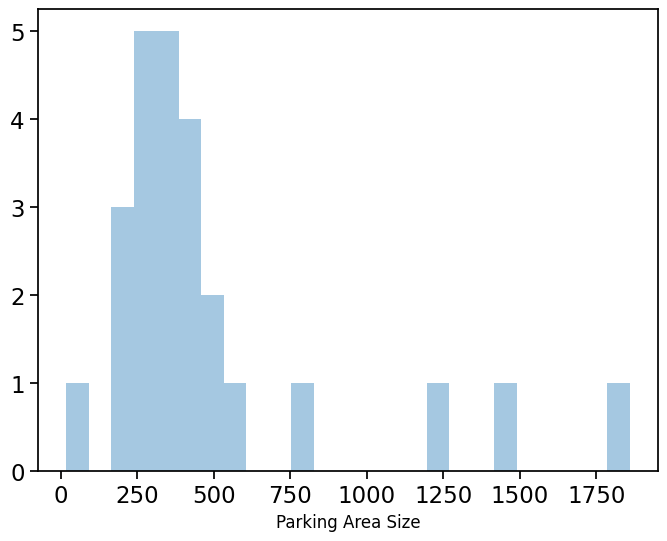

In [87]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['PARKING_SPACE_QTY'], bins=25, kde=False)
plt.xlabel('Parking Area Size', fontsize=12)
plt.show()

- About 15 stores have parking area between 250 - 500 units

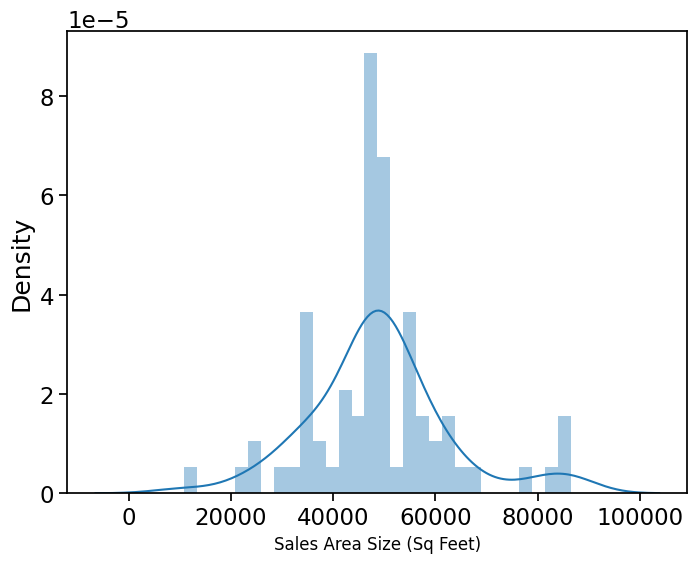

In [88]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['SALES_AREA_SIZE_NUM'], bins=30, kde=True)
plt.xlabel('Sales Area Size (Sq Feet)', fontsize=12)
plt.show()

- Most stores have the area between 30-70 K
- Only a small number of stores have area less than 30k or greater than 90k

#### How is Average store size varying for different states?

In [89]:
(store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['SALES_AREA_SIZE_NUM'].mean()).sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
IN    58563.000000
OH    52691.200000
TX    46920.902439
KY    39855.500000
Name: SALES_AREA_SIZE_NUM, dtype: float64

<Axes: xlabel='SALES_AREA_SIZE_NUM', ylabel='Density'>

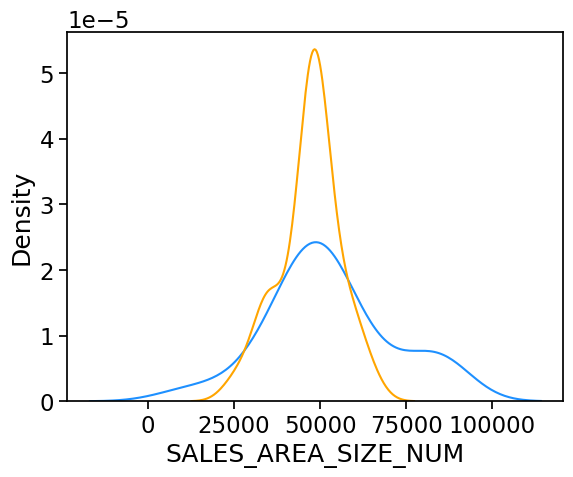

In [90]:
state_oh = store_data.loc[store_data['ADDRESS_STATE_PROV_CODE'] == 'OH']
state_tx = store_data.loc[store_data['ADDRESS_STATE_PROV_CODE'] == 'TX']

sns.distplot(state_oh['SALES_AREA_SIZE_NUM'], hist=False,color= 'dodgerblue', label= 'OHIO')
sns.distplot(state_tx['SALES_AREA_SIZE_NUM'], hist=False,  color= 'orange', label= 'TEXAS')


- Indiana has only one store and the area size is 58,563 sq feet.
- Ohio and Texas have average around 52k and 50k.
- Ohio has stores distributed at all sizes.
- Texas mainly has stores between sales area 30k to 60k

##### AVG_WEEKLY_BASKETS

In [91]:
store_data['AVG_WEEKLY_BASKETS'].isnull().sum()

0

In [92]:
store_data['AVG_WEEKLY_BASKETS'].describe()

count       76.000000
mean     24226.921053
std       8863.939362
min      10435.000000
25%      16983.500000
50%      24667.500000
75%      29398.500000
max      54053.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

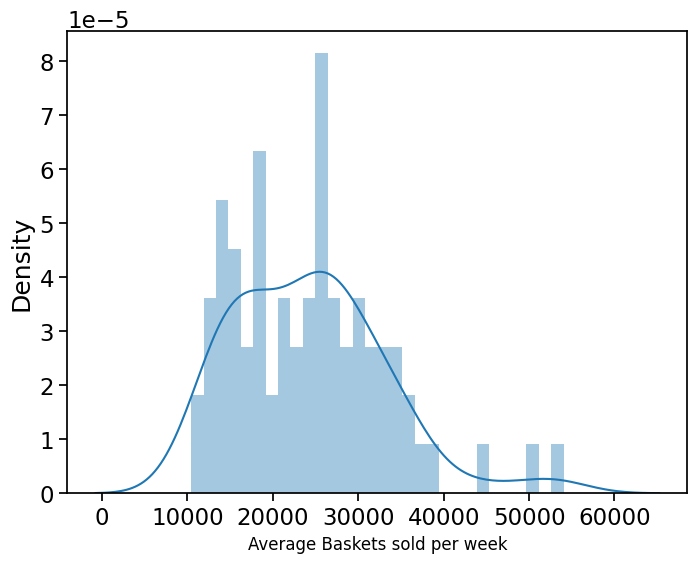

In [93]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['AVG_WEEKLY_BASKETS'], bins=30, kde=True)
plt.xlabel('Average Baskets sold per week', fontsize=12)
plt.show()

#### What are the average weekly baskets sold for the states?

In [94]:
(store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['AVG_WEEKLY_BASKETS'].mean()).sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
OH    26113.766667
TX    23234.195122
KY    21489.000000
IN    19275.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

##### SEG_VALUE_NAME

In [95]:
store_data['SEG_VALUE_NAME'].isnull().sum()

0

There are certain segments assigned to store, based on the brand and quality of products sold at the store.

- **Upscale stores** : Located in high income neighborhoods and offer more high-end product
- **Mainstream stores** : Located in middle class areas, offering a mix of upscale and value product
- **Value stores** : Focus on low prices products targeting low income customers

Let us look at the distribution of stores in each of these segments

In [96]:
store_data['SEG_VALUE_NAME'].value_counts()

MAINSTREAM    43
VALUE         19
UPSCALE       14
Name: SEG_VALUE_NAME, dtype: int64

#### Does the segment has any relation with the store area?

#### Is there a difference in the average sales for each segment?

In [97]:
(store_data.groupby(['SEG_VALUE_NAME'])['SALES_AREA_SIZE_NUM'].mean()).sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       59556.428571
MAINSTREAM    50075.976744
VALUE         38706.368421
Name: SALES_AREA_SIZE_NUM, dtype: float64

In [98]:
(store_data.groupby(['SEG_VALUE_NAME'])['AVG_WEEKLY_BASKETS'].mean()).sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       28735.928571
MAINSTREAM    24024.093023
VALUE         21363.526316
Name: AVG_WEEKLY_BASKETS, dtype: float64

# 4. Data Exploration - Train, Product, Store

## Validating the Hypothesis

During the Hypothesis Generation, we listed down the following hypothesis.

**Product Data**
- Product type/ Category : Different Product Categories can have significantly varying trends/patterns
- Product Size : Larger products should be more in demand
- Price of Product: Same category products with lower price would have more sales
- Company/ Manufacturer: Well known brands/manufacturers will have higher sales

**Train Data**

- Offer Applicable: Featured Products with attractive offers will have higher sales
- Product Promotion: Sales will be more for products with in-store promotion

**Store Data**
- Store Location: Stores in a particular state/city will have a similar trend
- Size of Store: Stores with larger area would have more sales
- Average Wait time: If average baskets sold is higher, wait time would be low. Implies higher sale of units.

### Merging the Store and Product Datasets

In [99]:
store_product_data = train.merge(product_data, how = 'left', on='UPC')

store_product_data = store_product_data.merge(store_data, how = 'left', left_on = 'STORE_NUM', right_on = 'STORE_ID')

In [100]:
store_product_data.shape

(232286, 22)

In [101]:
store_product_data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'PRICE', 'BASE_PRICE', 'FEATURE',
       'DISPLAY', 'UNITS', 'DESCRIPTION', 'MANUFACTURER', 'CATEGORY',
       'SUB_CATEGORY', 'PRODUCT_SIZE', 'STORE_ID', 'STORE_NAME',
       'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE', 'MSA_CODE',
       'SEG_VALUE_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM',
       'AVG_WEEKLY_BASKETS'],
      dtype='object')

### Trend or Seasonal Pattern in Product Sales

- Product type/Category: Different Product Categories can have significantly varying trends/patterns


### Units sold per week

<Axes: xlabel='WEEK_END_DATE', ylabel='UNITS'>

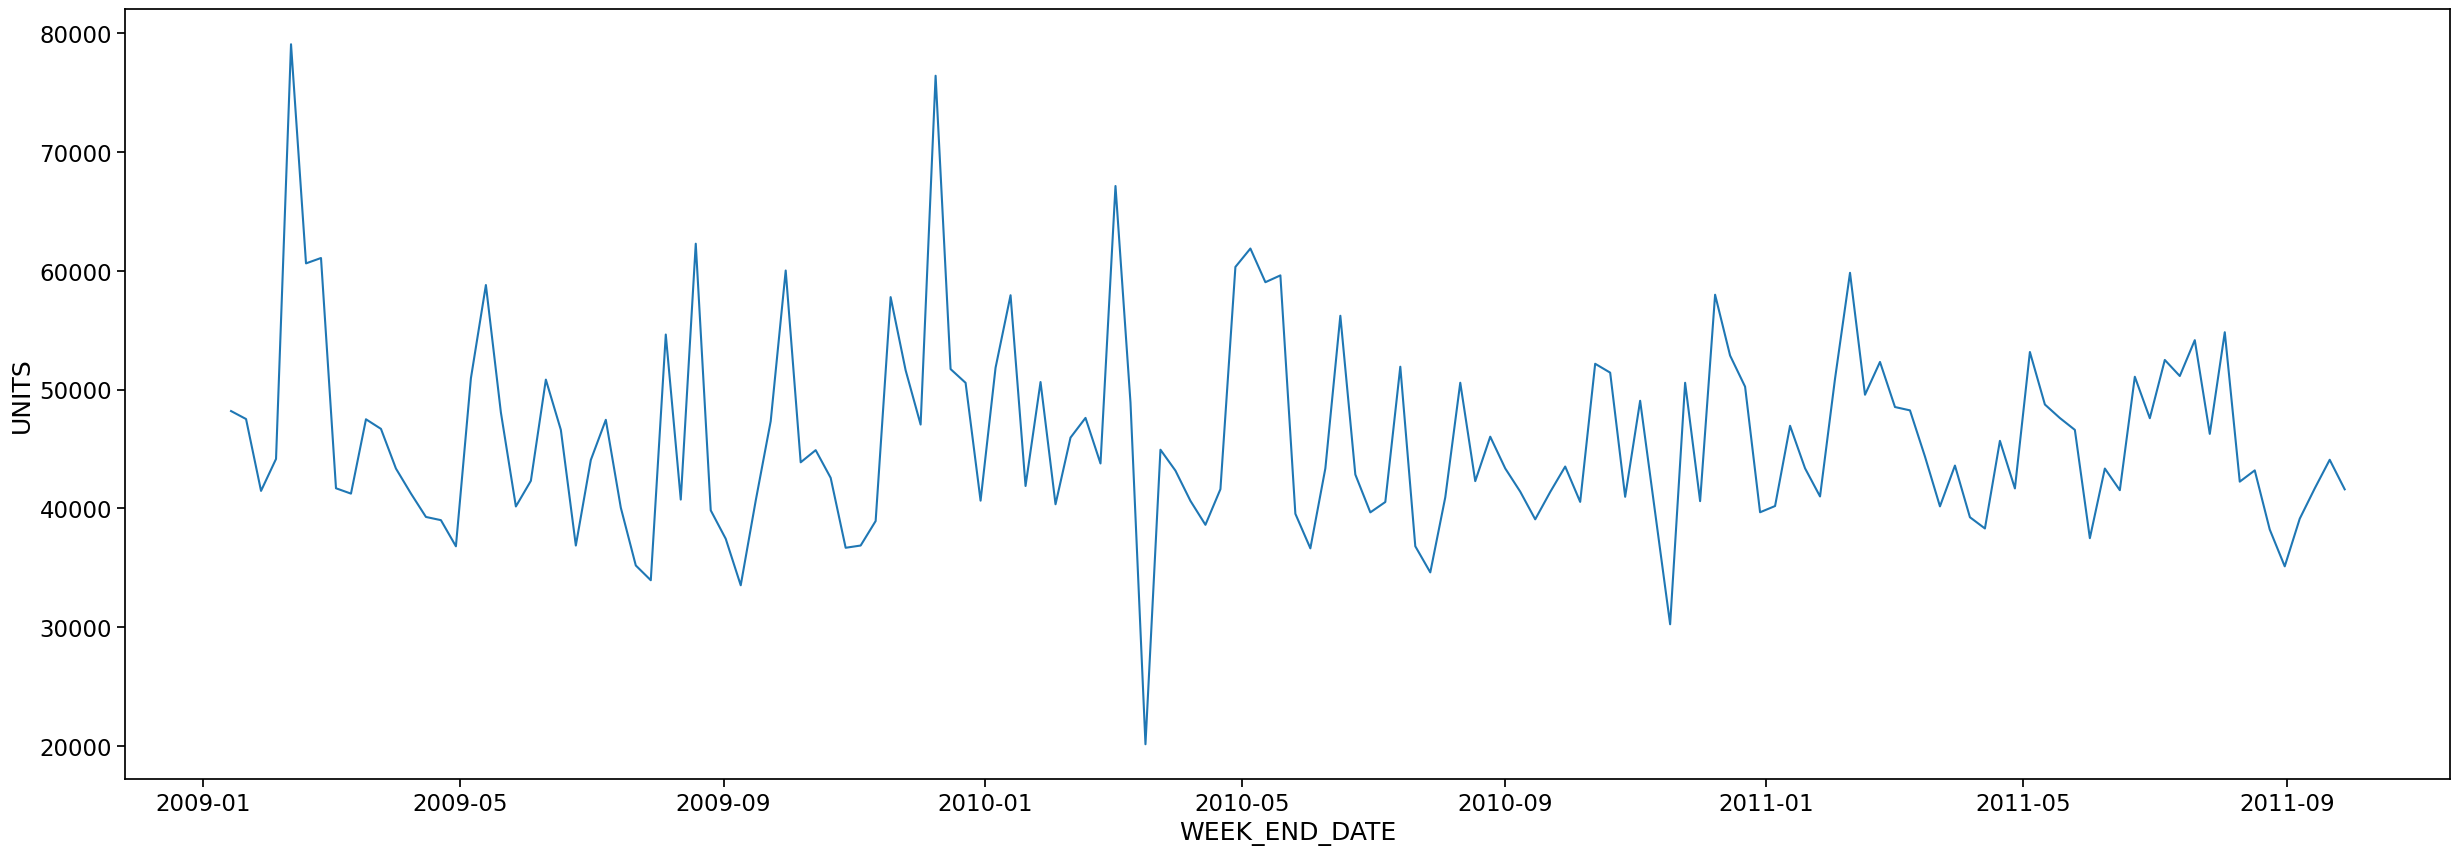

In [102]:
#sum of units sold per week
weekly_demand = store_product_data.groupby(['WEEK_END_DATE'])['UNITS'].sum()

plt.figure(figsize=(30,10))
sns.lineplot(x = weekly_demand.index, y = weekly_demand)

- Displays the total number of units sold by the retailer (including all products and from all stores)
- The highest number is close to 80,000 and lowest is close to 20,000 units
- There is no evident pattern or trend in the plot
- The spikes can be seen in either direction and at no constant interval

### Units sold per week - at product level

Now, we will look at category wise sales or demand patterns to see if there is any similarity within each category

In [103]:
# function to plot weekly sales of products
def product_plots(product_list):

    # dictionary storing UPC and weekly sales
    d = {product: store_product_data[store_product_data['UPC'] == product].groupby(['WEEK_END_DATE'])['UNITS'].sum() for product in product_list}
    fig, axs = plt.subplots(len(product_list), 1, figsize = (20, 20), dpi=300)
    j = 0

    for product in d.keys():
        # adding manufacturer and descritption in title
        manu = product_data[product_data['UPC'] == product]['MANUFACTURER'].values[0]
        desc = product_data[product_data['UPC'] == product]['DESCRIPTION'].values[0]
        # creating the plot
        sns.lineplot(x = d[product].index, y = d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        j = j+1
    plt.tight_layout()

In [104]:
# creating list of products based on category
pretzels = list(product_data[product_data['CATEGORY'] == 'BAG SNACKS']['UPC'])
frozen_pizza = list(product_data[product_data['CATEGORY'] == 'FROZEN PIZZA']['UPC'])
oral_hygiene = list(product_data[product_data['CATEGORY'] == 'ORAL HYGIENE PRODUCTS']['UPC'])
cold_cereal = list(product_data[product_data['CATEGORY'] == 'COLD CEREAL']['UPC'])

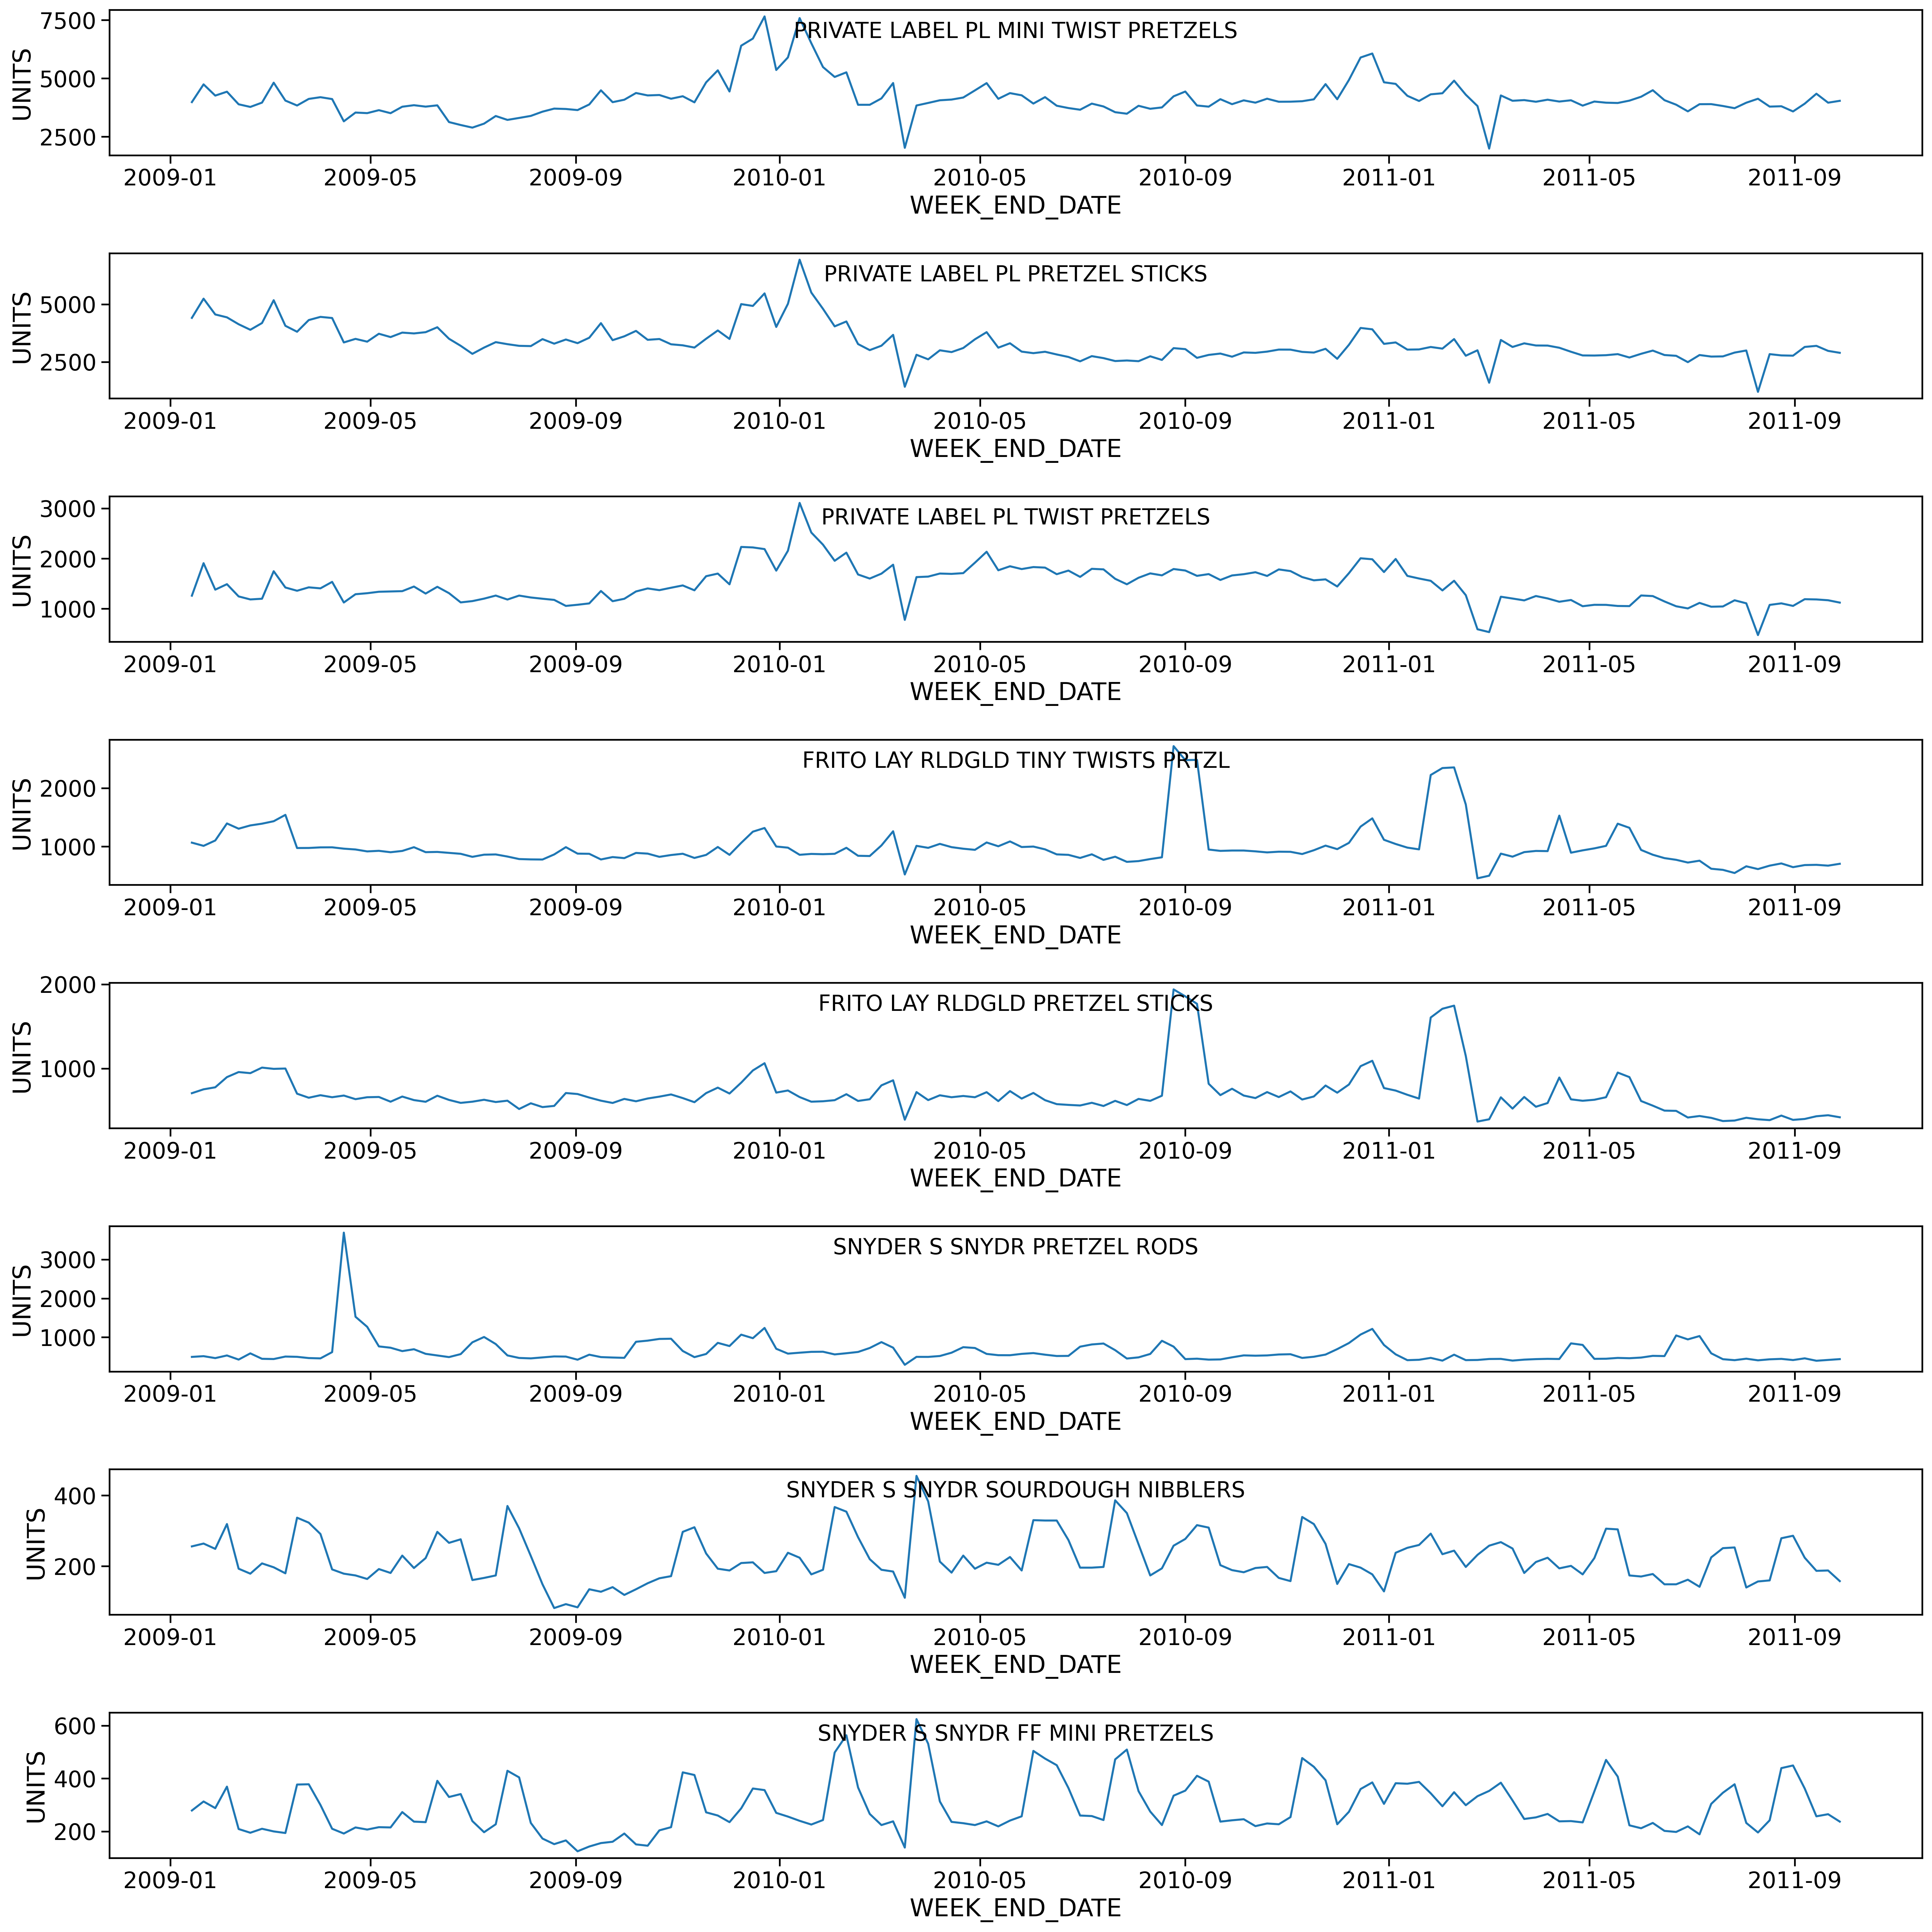

In [105]:
product_plots(pretzels)

In [106]:
product_plots(frozen_pizza)

Output hidden; open in https://colab.research.google.com to view.

- No increasing/decreasing trend for the sale of products over time
- No seasonal patterns seen on individual product sale
- Products by same manufaturer have similar patterns (spikes and drops).


### Units sold per week - at store level
Now, let us look store level demand patterns to see if there are any patterns here.

In [107]:
# Randomly selecting 5 store ID
stores_plot = random.sample(list(store_data['STORE_ID']), 5)

In [108]:
#creating dictionary with store number as keys
# for each store, calculate sum of units sold per week
d = {store: train[train['STORE_NUM'] == store].groupby(['WEEK_END_DATE'])['UNITS'].sum() for store in stores_plot}

<Figure size 3000x1000 with 0 Axes>

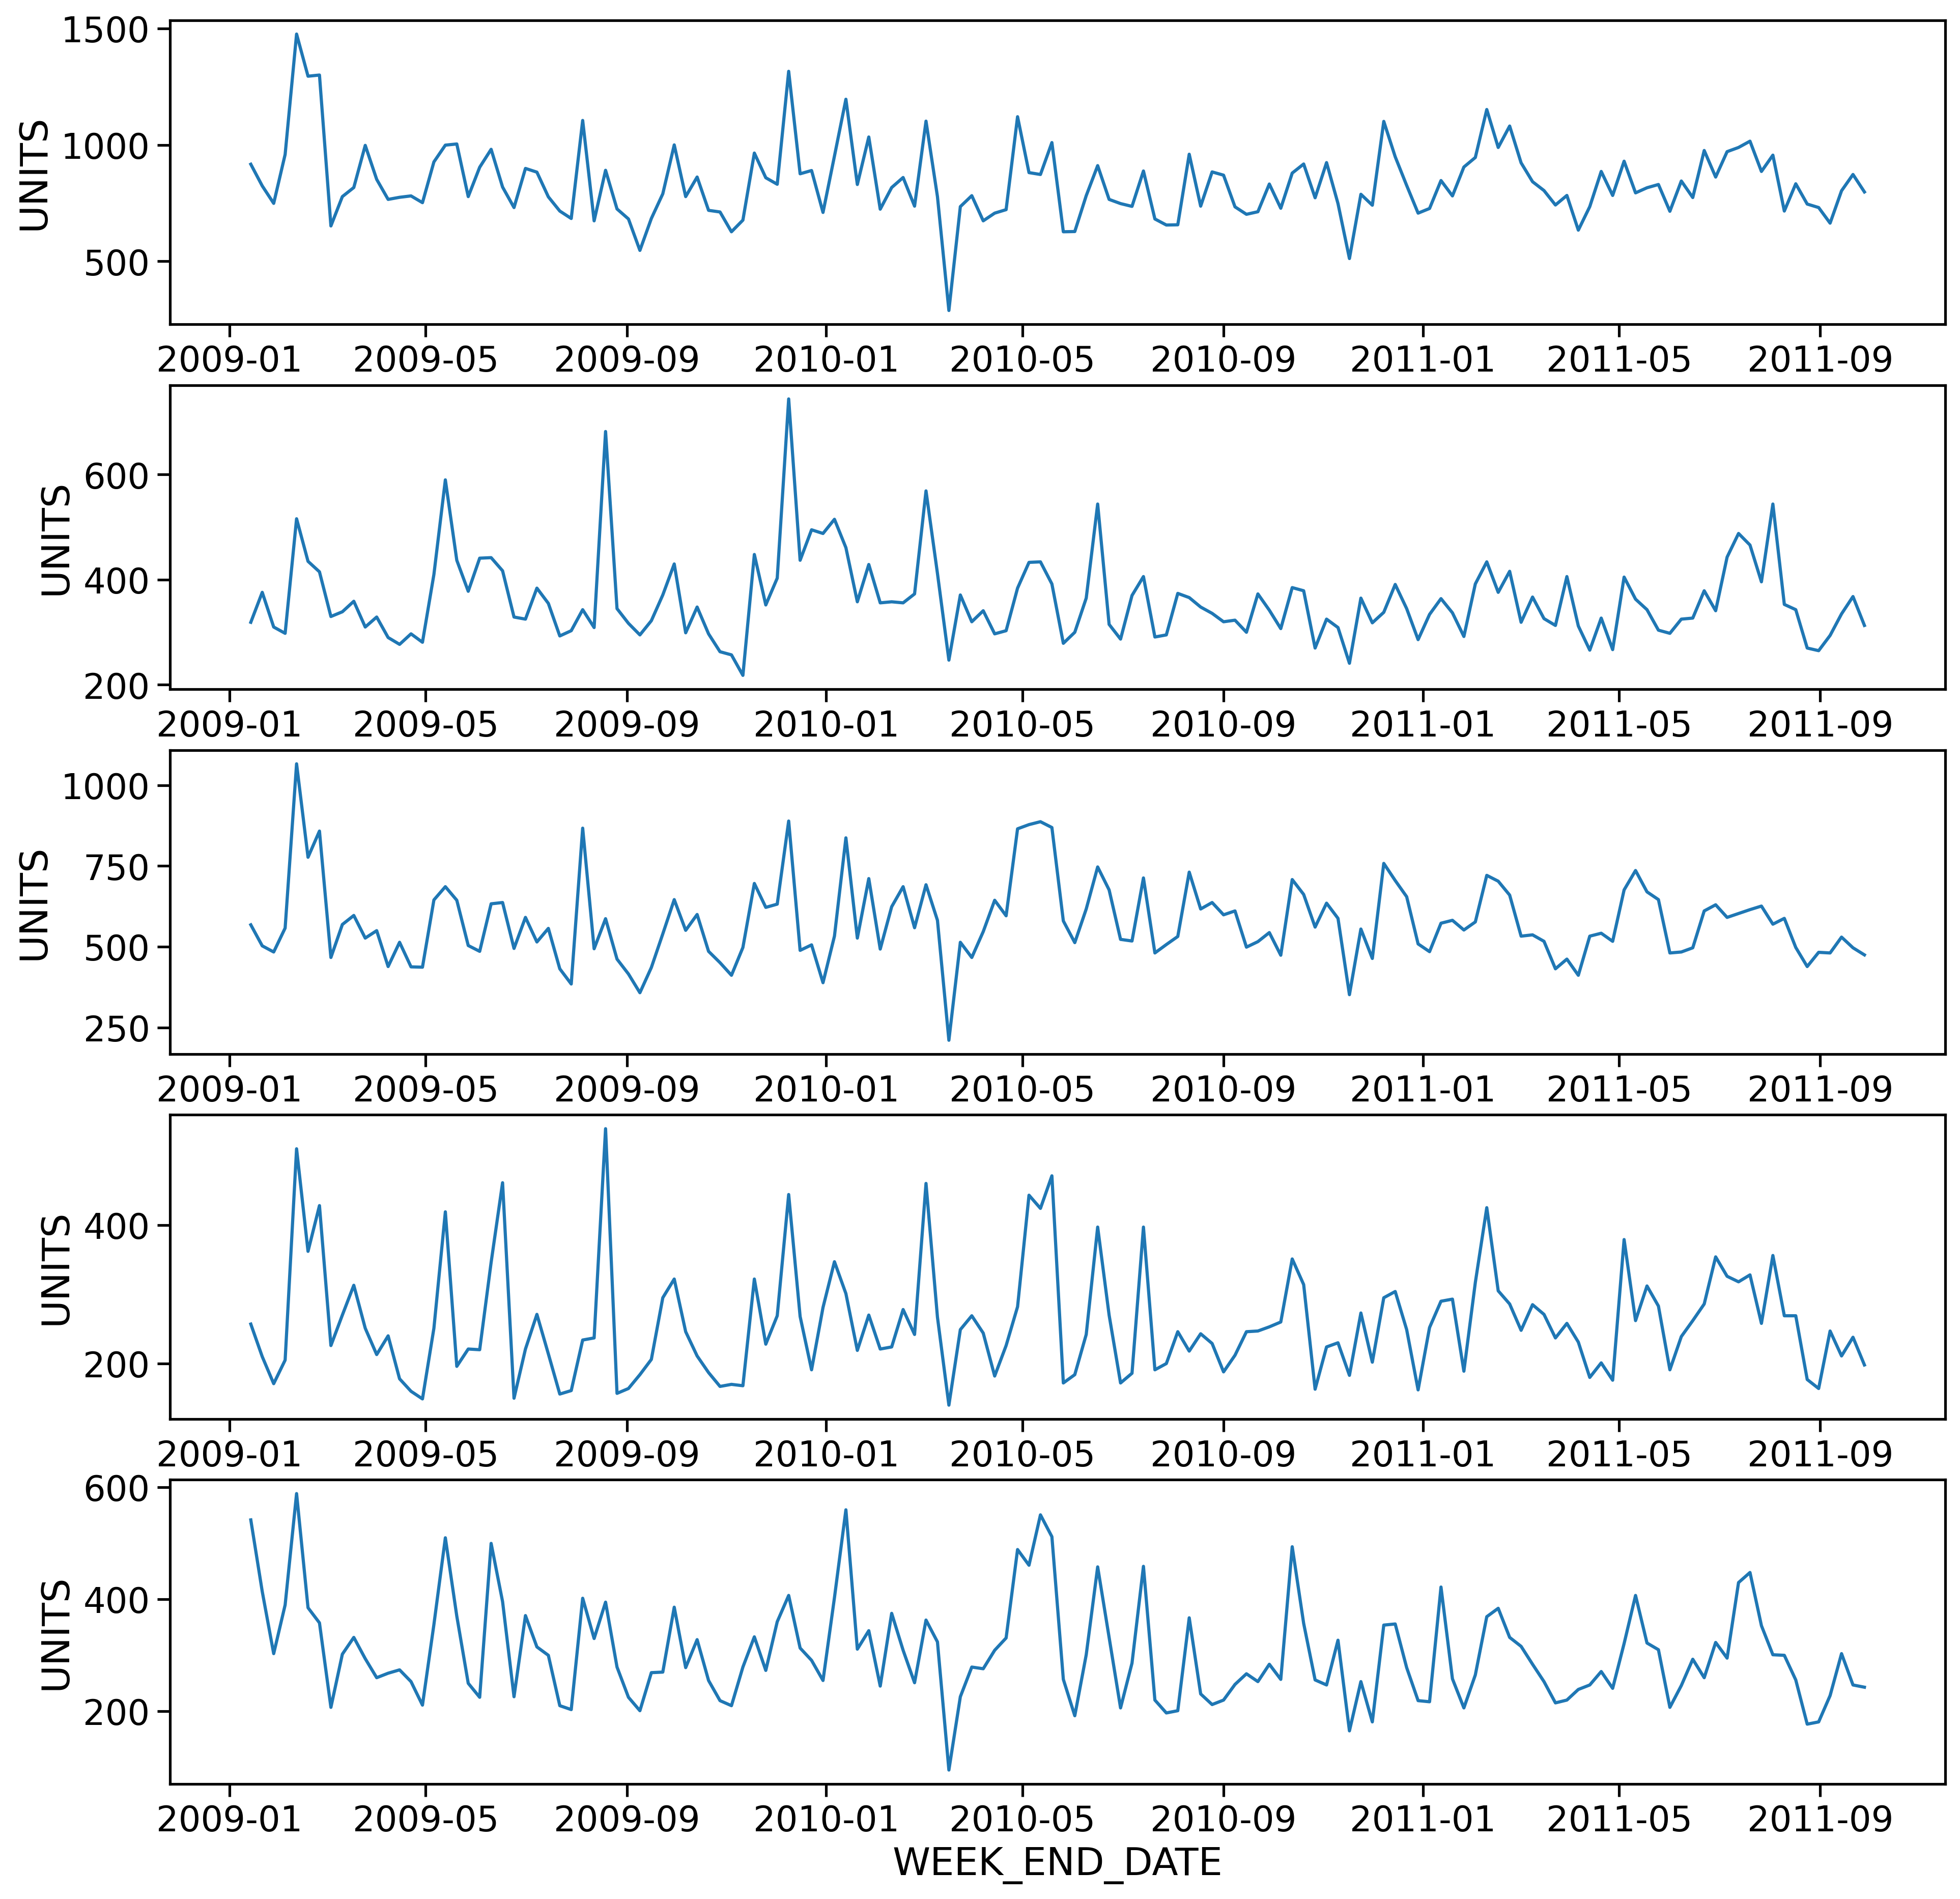

In [109]:
plt.figure(figsize=(30,10))

fig, axs = plt.subplots(5, 1, figsize = (15, 15), dpi=300)
j = 0
for store in d.keys():
    sns.lineplot(x = d[store].index, y = d[store],ax = axs[j])
    j = j+1

For the randomly selected store numbers, we can see that there is no pattern in the plot. The same was repeated for a number of stores and the data showed no increasing or decreasing trend or seasonality.

#### Are the sudden increase in sales due to product/in-store promotion?

### Featured or Displayed Product have higher sale

- Offer Applicable: Featured Products with attractive offers will have higher sales
- Product Promotion: Sales will be more for products with in-store promotion

In [110]:
def featured_plots(product_list):
    #dictionary storing UPC and 'Featured' variable
    d_f = {product: 1000*train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['FEATURE'].mean() for product in product_list}
    #dictionary storing UPC and Product Sales
    d = {product: train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['UNITS'].sum() for product in product_list}


    fig, axs = plt.subplots(len(product_list), 1, figsize = (20, 20), dpi=300)
    j = 0
    for product in d.keys():
        # Manufacturer name and Descritption in title
        manu = product_data[product_data['UPC'] == product]['MANUFACTURER'].values[0]
        desc = product_data[product_data['UPC'] == product]['DESCRIPTION'].values[0]

        # plotting featured and sales values
        sns.lineplot(x = d_f[product].index, y = d_f[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        sns.lineplot(x = d[product].index, y = d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        j = j+1

In [111]:
product_list_f = list(product_data[product_data['CATEGORY'] == 'BAG SNACKS']['UPC'])

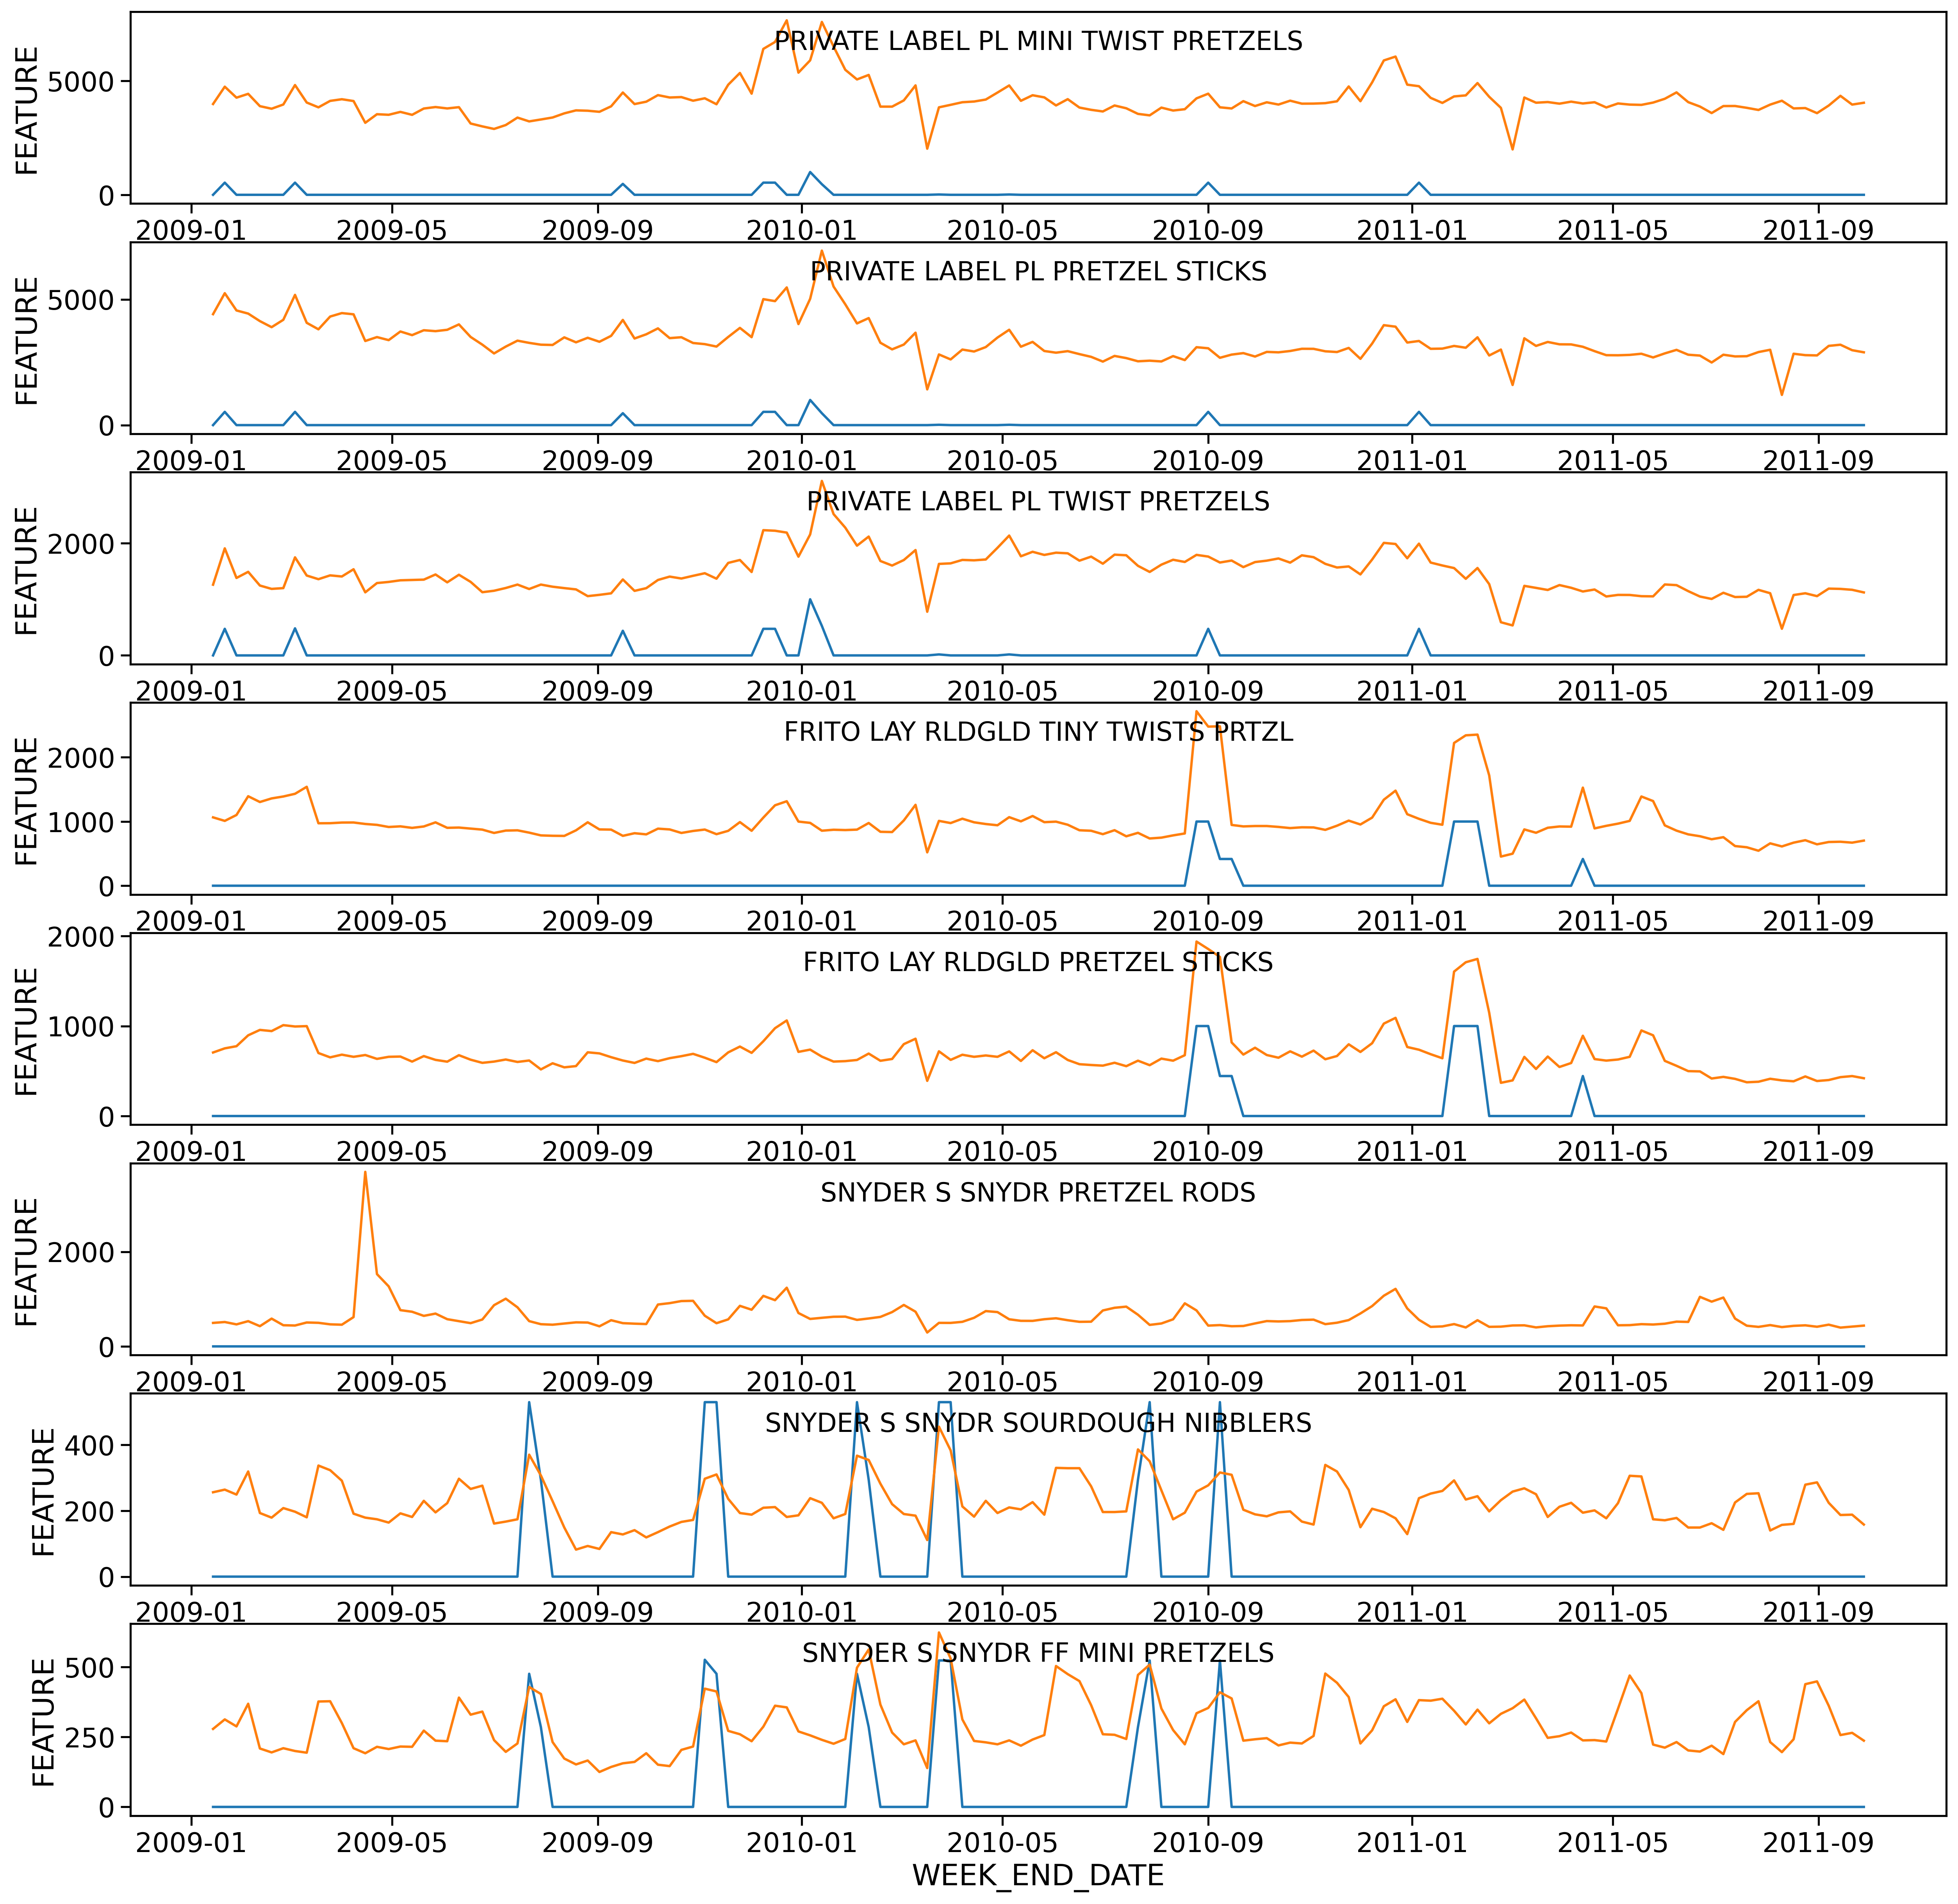

In [112]:
featured_plots(product_list_f)

- When the products are featured, the sales increase.

#### Does the in-store display also have a similar effect?

In [113]:
def display_plots(product_list):
    d_d = {product: 1000*train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['DISPLAY'].mean() for product in product_list}
    d = {product: train[train['UPC'] == product].groupby(['WEEK_END_DATE'])['UNITS'].sum() for product in product_list}
    fig, axs = plt.subplots(len(product_list), 1, figsize = (20, 20), dpi=300)
    j = 0
    for product in d.keys():
        manu = product_data[product_data['UPC'] == product]['MANUFACTURER'].values[0]
        desc = product_data[product_data['UPC'] == product]['DESCRIPTION'].values[0]
        sns.lineplot(x = d[product].index, y = d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        sns.lineplot(x = d_d[product].index, y = d_d[product],ax = axs[j]).set_title(str(manu)+str(" ")+str(desc), y=0.75, fontsize = 16)
        j = j+1

In [114]:
display_plots(product_list_f)

Output hidden; open in https://colab.research.google.com to view.

- It is evident that product sales are greatly affected by the display.
- For products on display, the sales are higher.

### Product sales higher for lower priced items

- Price of Product: Same category products with lower price would have more sales


In [115]:
product_size_coldcereal = store_product_data.loc[store_product_data['CATEGORY']=='COLD CEREAL']
product_size_bagsnacks  = store_product_data.loc[store_product_data['CATEGORY']=='BAG SNACKS']
product_size_frozenpizza = store_product_data.loc[store_product_data['CATEGORY']=='FROZEN PIZZA']
product_size_oralhyiegne = store_product_data.loc[store_product_data['CATEGORY']=='ORAL HYGIENE PRODUCTS']

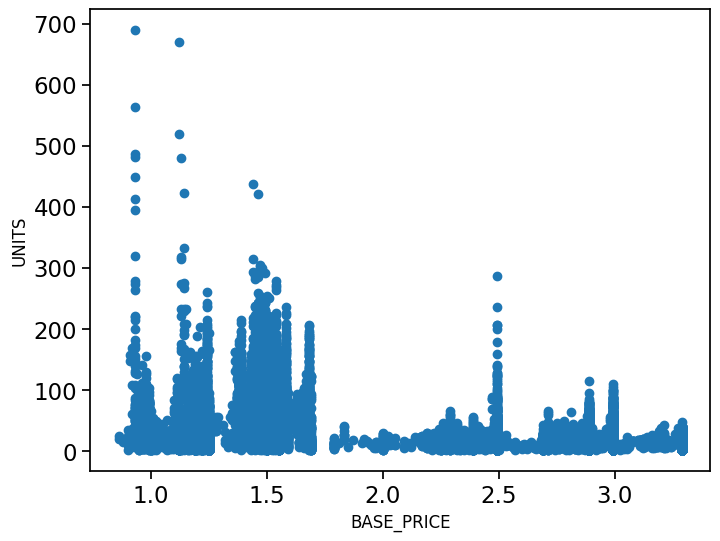

In [116]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (product_size_bagsnacks['BASE_PRICE']), y = (product_size_bagsnacks['UNITS']))
plt.xlabel('BASE_PRICE', fontsize=12)
plt.ylabel('UNITS', fontsize=12)
plt.show()

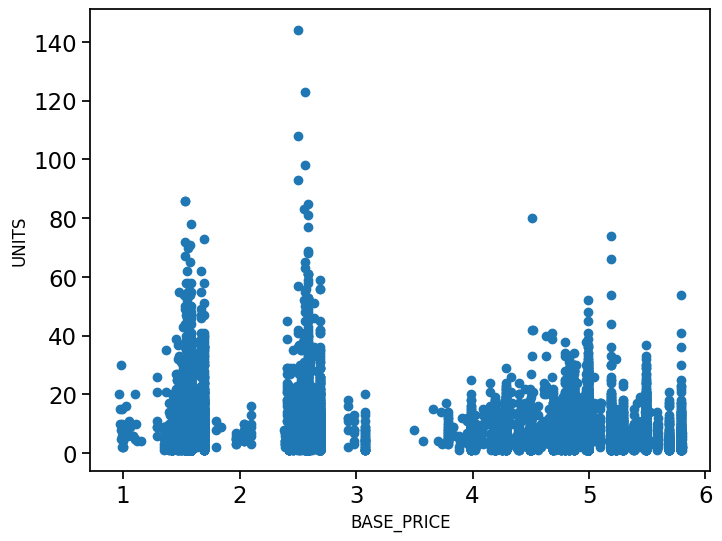

In [117]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (product_size_oralhyiegne['BASE_PRICE']), y = (product_size_oralhyiegne['UNITS']))
plt.xlabel('BASE_PRICE', fontsize=12)
plt.ylabel('UNITS', fontsize=12)
plt.show()

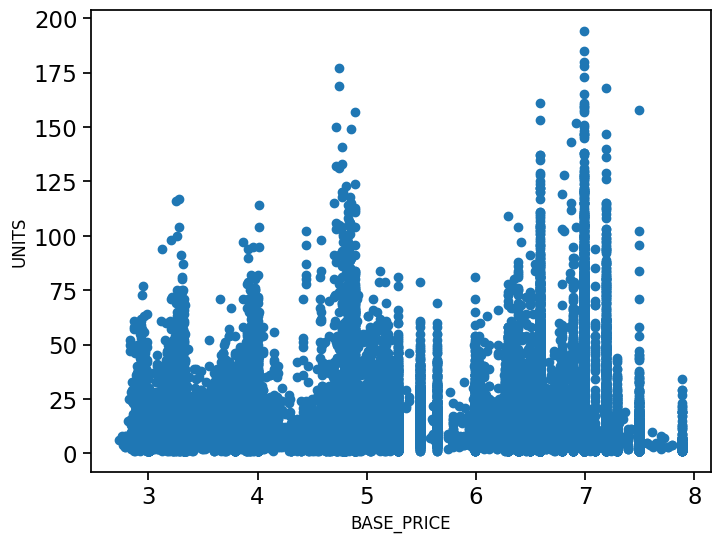

In [118]:
# scatter plot for base price and sales
plt.figure(figsize=(8,6))
plt.scatter(x = (product_size_frozenpizza['BASE_PRICE']), y = (product_size_frozenpizza['UNITS']))
plt.xlabel('BASE_PRICE', fontsize=12)
plt.ylabel('UNITS', fontsize=12)
plt.show()

- For bag snacks and oral hygiene category, items with lower price show a higher sale.
- Frozen pizza items have higher sale for higher price items.

Check the pattern for cold cereal at your end.

## Product size versus Product Sales

- Product Size : Larger products should be more in demand


In [119]:
pd.crosstab(product_size_coldcereal['CATEGORY'], product_size_coldcereal['PRODUCT_SIZE'])

PRODUCT_SIZE  12 OZ  12.2 OZ  12.25 OZ  15 OZ  18 OZ  20 OZ
CATEGORY                                                   
COLD CEREAL   10786    10766     21426  10785  32203  10789

In [120]:
pd.crosstab(product_size_bagsnacks['CATEGORY'], product_size_bagsnacks['PRODUCT_SIZE'])

PRODUCT_SIZE  10 OZ  15 OZ  16 OZ
CATEGORY                         
BAG SNACKS     6916  28921  21443

#### Is the product sale higher for a particular brand or manufacturer?

## Product sales for different manufacturers

- Company/ Manufacturer: Well known brands/manufacturers will have higher sales


In [121]:
pretzels = list(product_data[product_data['CATEGORY'] == 'BAG SNACKS']['UPC'])
frozen_pizza = list(product_data[product_data['CATEGORY'] == 'FROZEN PIZZA']['UPC'])
oral_hygiene = list(product_data[product_data['CATEGORY'] == 'ORAL HYGIENE PRODUCTS']['UPC'])
cold_cereal = list(product_data[product_data['CATEGORY'] == 'COLD CEREAL']['UPC'])

UPC               DESCRIPTION   MANUFACTURER    CATEGORY  \
0   1111009477    PL MINI TWIST PRETZELS  PRIVATE LABEL  BAG SNACKS   
1   1111009497         PL PRETZEL STICKS  PRIVATE LABEL  BAG SNACKS   
2   1111009507         PL TWIST PRETZELS  PRIVATE LABEL  BAG SNACKS   
14  2840004768  RLDGLD TINY TWISTS PRTZL      FRITO LAY  BAG SNACKS   
15  2840004770     RLDGLD PRETZEL STICKS      FRITO LAY  BAG SNACKS   
25  7797502248        SNYDR PRETZEL RODS       SNYDER S  BAG SNACKS   
26  7797508004  SNYDR SOURDOUGH NIBBLERS       SNYDER S  BAG SNACKS   
27  7797508006    SNYDR FF MINI PRETZELS       SNYDER S  BAG SNACKS   

   SUB_CATEGORY PRODUCT_SIZE  
0      PRETZELS        15 OZ  
1      PRETZELS        15 OZ  
2      PRETZELS        15 OZ  
14     PRETZELS        16 OZ  
15     PRETZELS        16 OZ  
25     PRETZELS        10 OZ  
26     PRETZELS        16 OZ  
27     PRETZELS        16 OZ

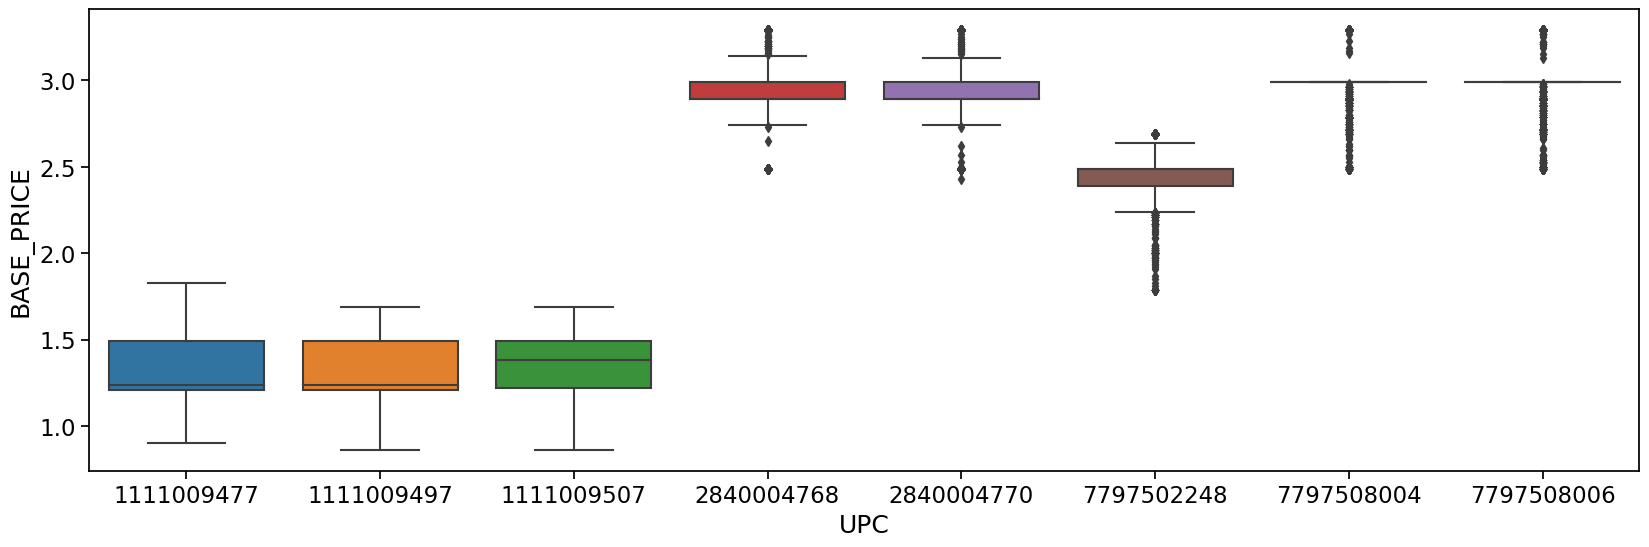

In [122]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="UPC", y="BASE_PRICE", data=train[train['UPC'].isin(pretzels)])
product_data[product_data['UPC'].isin(pretzels)]

- All Private Label snacks have lower price.
- The Snyder S bag snacks with a smaller size has a lower price.

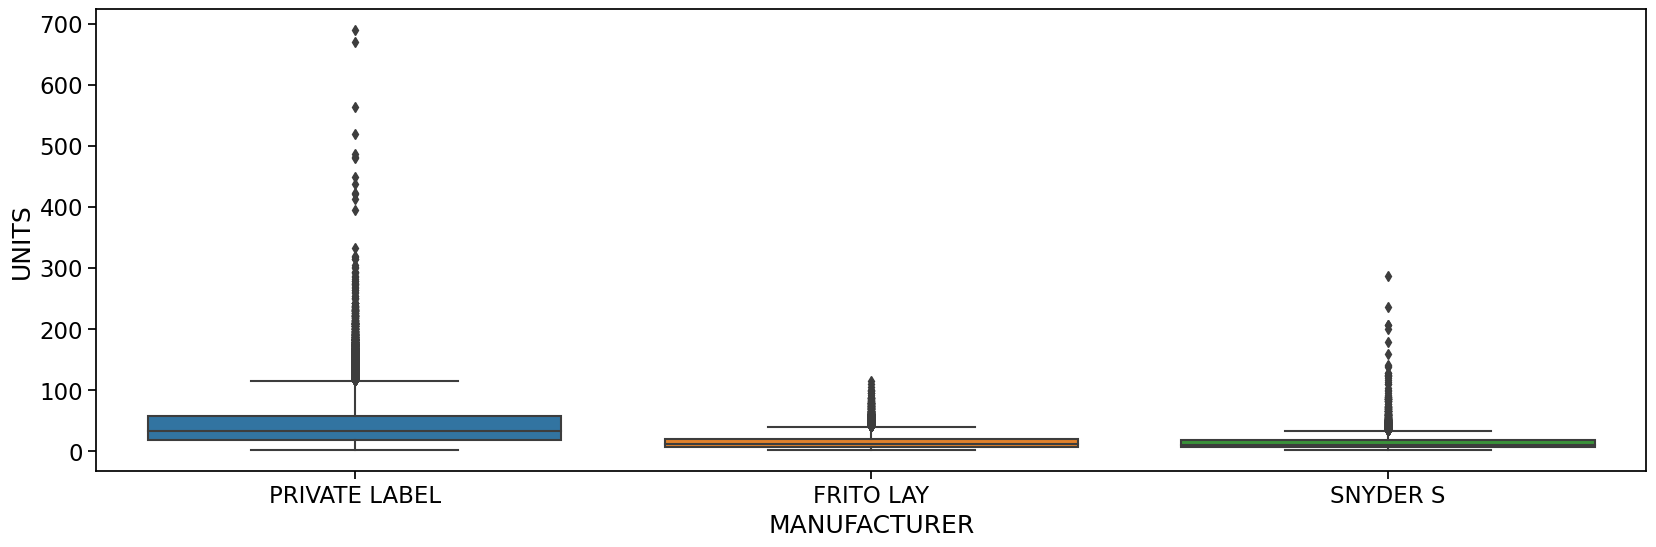

In [123]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(pretzels)])

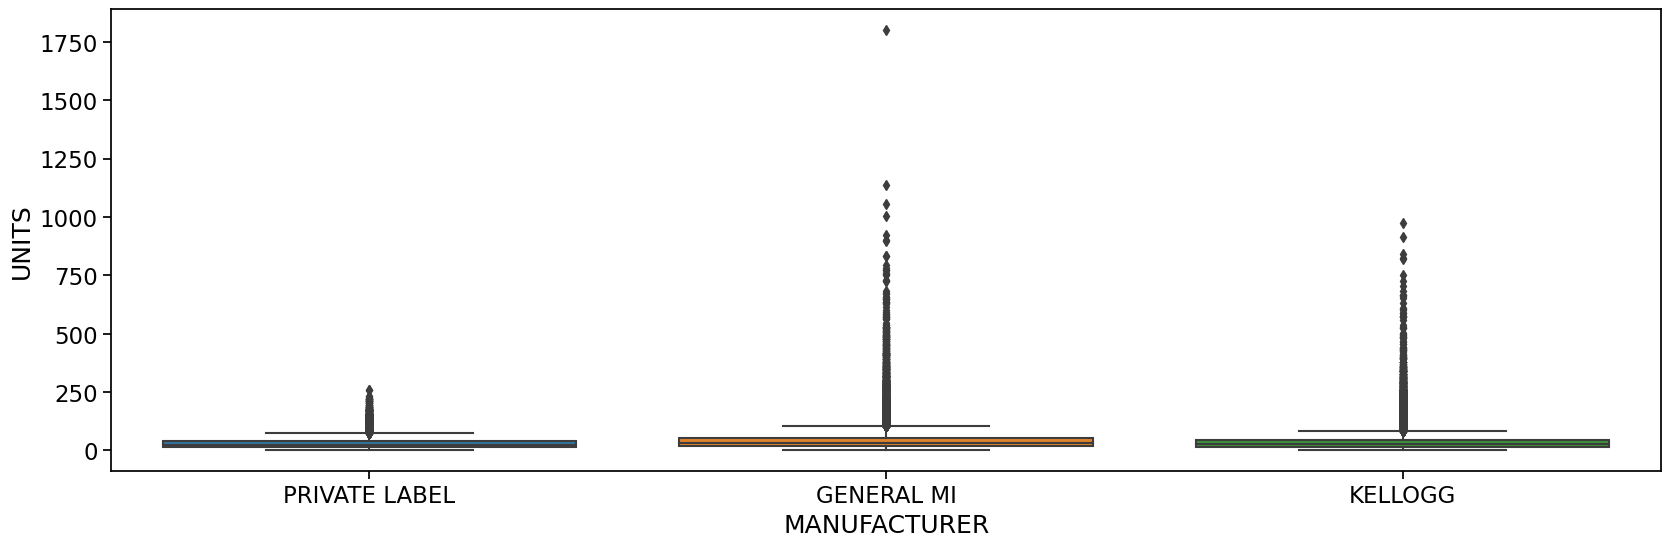

In [124]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(cold_cereal)])

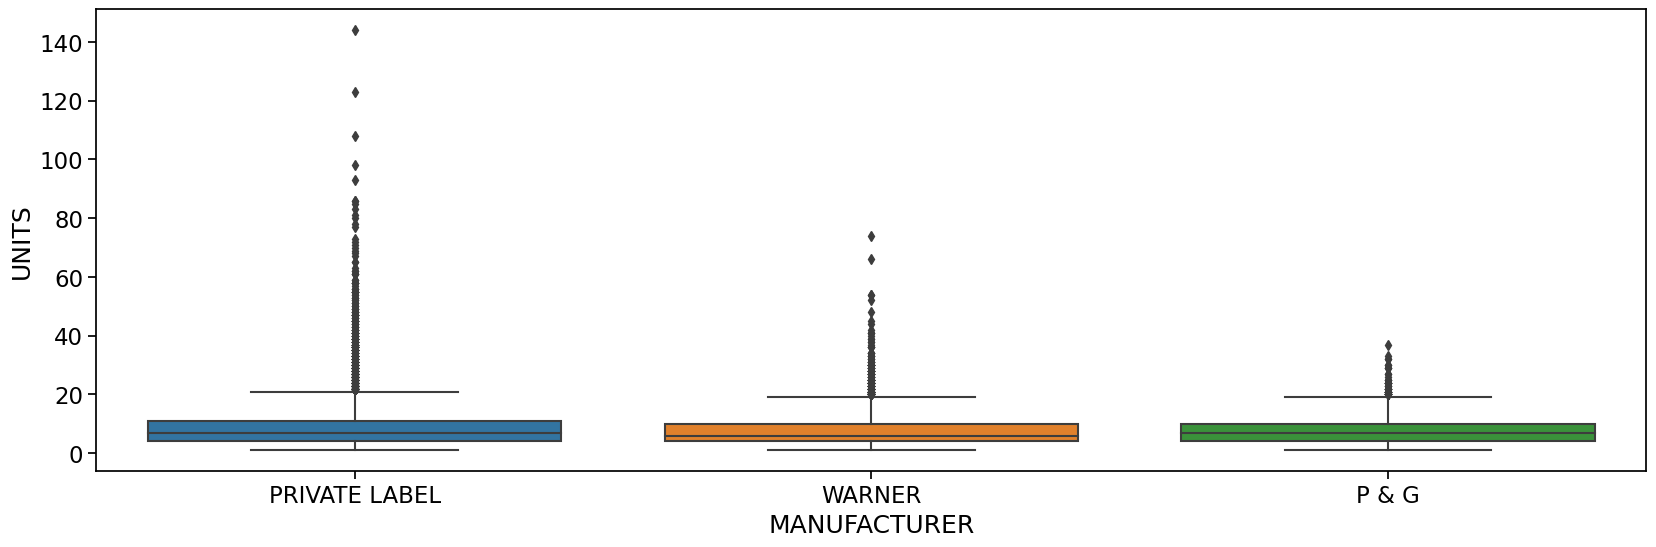

In [125]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(oral_hygiene)])

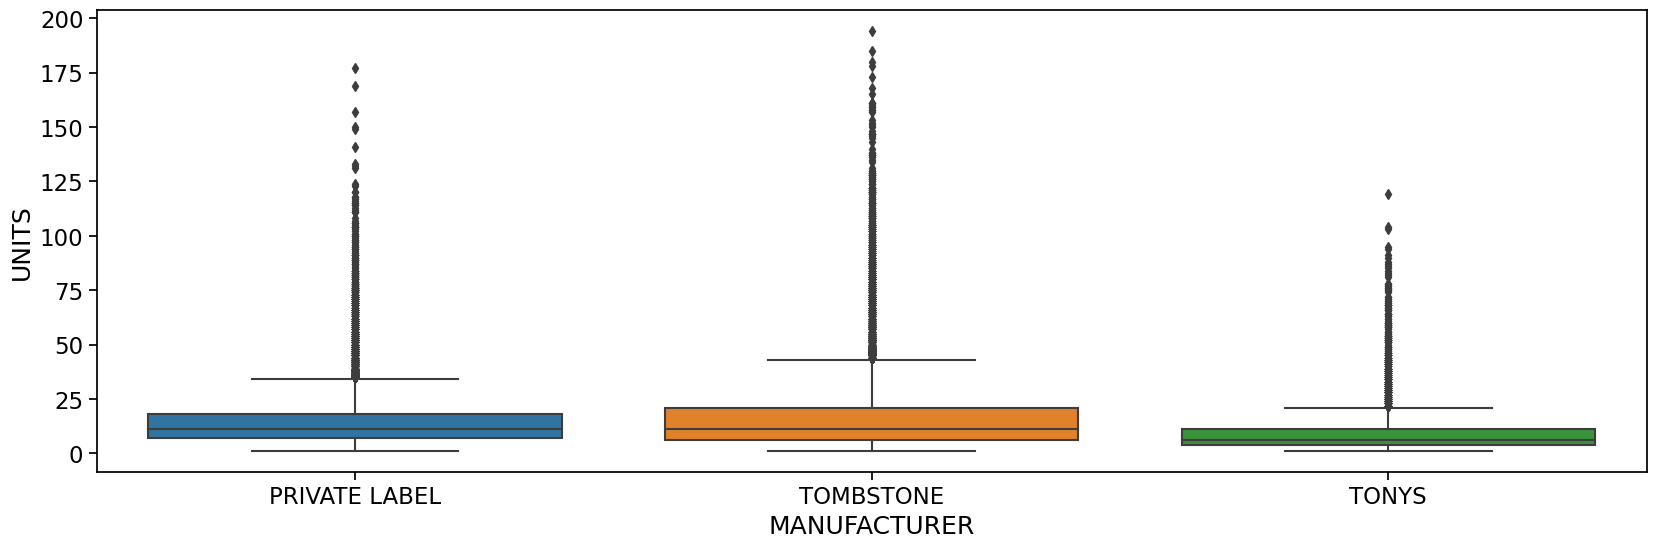

In [126]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(x="MANUFACTURER", y="UNITS", data=store_product_data[store_product_data['UPC'].isin(frozen_pizza)])

#### Is there a significant difference in the product sales for different regions?

#### How are the sales different for stores in different cities?

## Unit Sales for Stores in Different States

- Store Location: Stores in a particular state/city will have a similar trend

In [127]:
grouped_weekly_sales = store_product_data.groupby(['WEEK_END_DATE','STORE_NUM'])['UNITS'].sum().reset_index()

grouped_weekly_sales = grouped_weekly_sales.merge(store_data, how = 'left', left_on = 'STORE_NUM', right_on = 'STORE_ID')

grouped_weekly_sales = grouped_weekly_sales.sort_values(by = 'ADDRESS_STATE_PROV_CODE')

In [128]:
state = (store_data[['ADDRESS_STATE_PROV_CODE','STORE_ID']].sort_values(by ='ADDRESS_STATE_PROV_CODE'))['STORE_ID']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 [Text(0, 0, '4245'),
  Text(1, 0, '19265'),
  Text(2, 0, '367'),
  Text(3, 0, '11757'),
  Text(4, 0, '389'),
  Text(5, 0, '13609'),
  Text(6, 0, '15531'),
  Text(7, 0, '28909'),
  Text(8, 0, '15547'),
  Text(9, 0, '21213'),
  Text(10, 0, '21221'),
  Text(11, 0, '21227'),
  Text(12, 0, '21237'),
  Text(13, 0, '26981'),
  Text(14, 0, '11761'),
  Text(15, 0, '23061'),
  Text(16, 0, '23067'),
  Text(17, 0, '23075'),
  Text(18, 0, '24991'),
  Text(19, 0, '25001'),
  Text(20, 0, '25021'),
  Text(21, 0, '25027'),
  Text(22, 0, '26973'),
  Text(23, 0, '26983'),
  Text(24, 0, '23055'),
  Text(25, 0, '15541'),
  Text(26, 0, '9825'),
  Text(27, 0, '6179'),

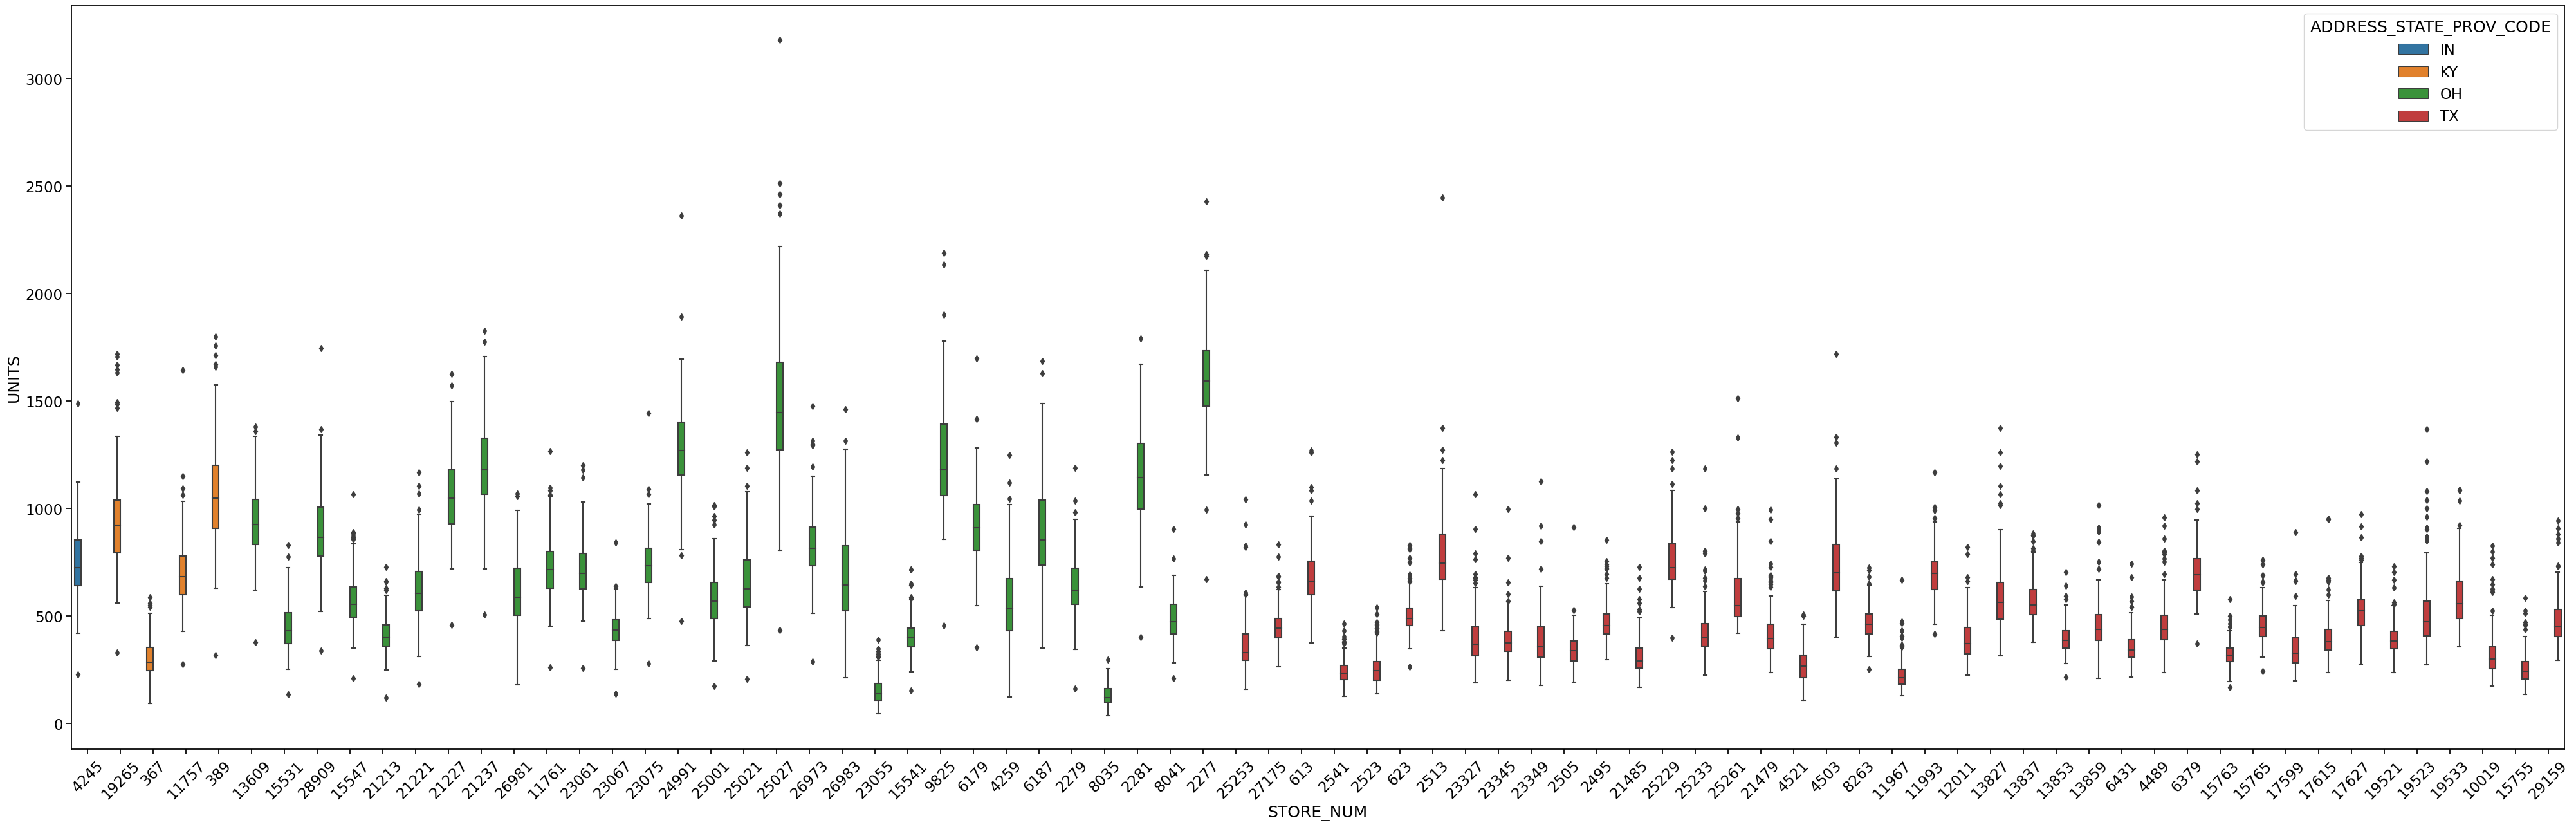

In [129]:
plt.figure(figsize=(50,15))

ax=sns.boxplot(x="STORE_NUM",y="UNITS",data=grouped_weekly_sales, hue ='ADDRESS_STATE_PROV_CODE', order =state)
plt.xticks(rotation=45)

- The most frequent colors we see are green and orange - Ohio and Texas
- Mostly the number of units is higher for Ohio (considering individual stores)

## Store Size and unit sales

- Size of Store: Stores with larger area would have more sales

In [130]:
store_agg_data = train.groupby(['STORE_NUM'])['UNITS'].sum().reset_index()
merged_store_data = store_data.merge(store_agg_data, how = 'left', left_on = 'STORE_ID', right_on = 'STORE_NUM')

<Axes: xlabel='SALES_AREA_SIZE_NUM', ylabel='Density'>

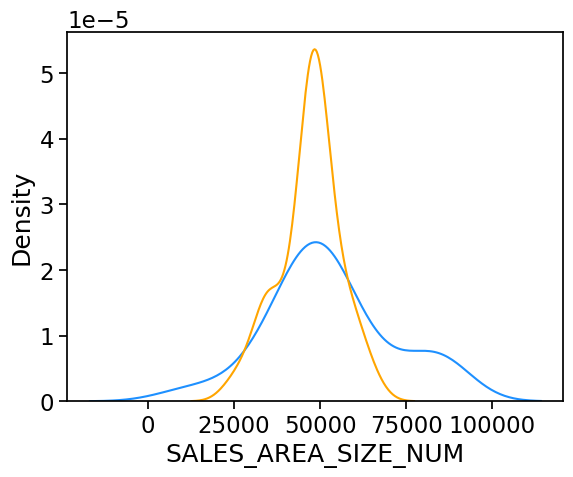

In [131]:
state_oh = merged_store_data.loc[merged_store_data['ADDRESS_STATE_PROV_CODE'] == 'OH']
state_tx = merged_store_data.loc[merged_store_data['ADDRESS_STATE_PROV_CODE'] == 'TX']

sns.distplot(state_oh['SALES_AREA_SIZE_NUM'], hist=False,color= 'dodgerblue', label= 'OHIO')
sns.distplot(state_tx['SALES_AREA_SIZE_NUM'], hist=False,  color= 'orange', label= 'TEXAS')


<Axes: xlabel='SALES_AREA_SIZE_NUM', ylabel='UNITS'>

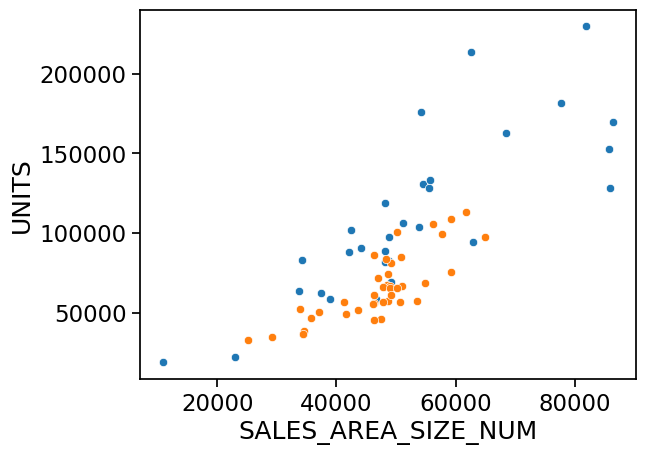

In [132]:
sns.scatterplot(x = (state_oh['SALES_AREA_SIZE_NUM']), y = (state_oh['UNITS']))
sns.scatterplot(x = (state_tx['SALES_AREA_SIZE_NUM']), y = (state_tx['UNITS']))

We will pre-process the categorical features and then the numerical features on all the 3 available tables.

---

## `PREPROCESSING: CATEGORICAL FEATURES`

- Find out and impute, if we have missing values in the categorical features.
- Remove the features which do not add much information
- Choose an Encoding scheme to convert categorical feature into numeric.



---

In [133]:
# importing required libraries

import pandas as pd
import numpy as np
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

---
### `DATASET 1: Weekly Sales Data` contains the following features

- **WEEK_END_DATE** - week date
- **STORE_NUM** - store number
- **UPC** - (Universal Product Code) product specific identifier
- **BASE_PRICE** - base price of item
- **DISPLAY** - product was a part of in-store promotional display
- **FEATURE** - product was in in-store circular
- **UNITS** - units sold (target)

---

In [134]:
# read the train data
data = pd.read_csv('train.csv')
data.head()

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   
2     14-Jan-09        367  1111085319   1.88        1.88        0        0   
3     14-Jan-09        367  1111085345   1.88        1.88        0        0   
4     14-Jan-09        367  1111085350   1.98        1.98        0        0   

   UNITS  
0     13  
1     20  
2     14  
3     29  
4     35

---

###  `WEEKLY SALES DATA`  has the following categorical features

    - STORE_NUM
    - UPC
    - FEATURE
    - DISPLAY
    
---

In [135]:
# check for the null values in the categorical features
data[['STORE_NUM', 'UPC', 'FEATURE', 'DISPLAY']].isna().sum()

STORE_NUM    0
UPC          0
FEATURE      0
DISPLAY      0
dtype: int64

***No Null Values***

---
 -  `STORE_NUM` - No changes required as it is a key and will be used to merge tables later.
 -  `UPC      ` - No changes required as it is a key and will be used to merge tables later.
 -  `FEATURE  ` - No Preprocessing Required
 -  `DISPLAY  ` - No Preprocessing Required
 ---

---

### `DATASET 2: PRODUCT DATA` contains the details about the products

- **UPC** - (Universal Product Code) product specific identifier
- **DESCRIPTION**	- product description
- **MANUFACTURER** - product	manufacturer
- **CATEGORY** - category of product
- **SUB_CATEGORY** - sub-category of product
- **PRODUCT_SIZE** - package size or quantity of product

---

In [136]:
# read the product data
product_data = pd.read_csv('product_data.csv')
product_data.head()

UPC               DESCRIPTION   MANUFACTURER               CATEGORY  \
0  1111009477    PL MINI TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
1  1111009497         PL PRETZEL STICKS  PRIVATE LABEL             BAG SNACKS   
2  1111009507         PL TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
3  1111038078  PL BL MINT ANTSPTC RINSE  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   
4  1111038080  PL ANTSPTC SPG MNT MTHWS  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   

               SUB_CATEGORY PRODUCT_SIZE  
0                  PRETZELS        15 OZ  
1                  PRETZELS        15 OZ  
2                  PRETZELS        15 OZ  
3  MOUTHWASHES (ANTISEPTIC)       500 ML  
4  MOUTHWASHES (ANTISEPTIC)       500 ML

---

### `PRODUCT DATA`  has the following categorical features

    - UPC
    - DESCRIPTION
    - MANUFACTURER
    - CATEGORY
    - SUB_CATEGORY
    - PRODUCT_SIZE
    
---

In [137]:
# shape of the data
product_data.shape

(30, 6)

In [138]:
# check for the null values in the categorical features
product_data[['UPC', 'DESCRIPTION', 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY', 'PRODUCT_SIZE']].isna().sum()

UPC             0
DESCRIPTION     0
MANUFACTURER    0
CATEGORY        0
SUB_CATEGORY    0
PRODUCT_SIZE    0
dtype: int64

In [139]:
# number of unique description
product_data.DESCRIPTION.nunique()

29

In [140]:
# number of unique manufacturer
product_data.MANUFACTURER.nunique()

9

In [141]:
# number of unique categories
product_data.CATEGORY.nunique()

4

In [142]:
# number of unique sub categories
product_data.SUB_CATEGORY.nunique()

7

In [143]:
# number of unique product sizes
product_data.PRODUCT_SIZE.nunique()

16

---
 - `DESCRIPTION` - In the description, we have category, subcategory and size of the product and these are already present in the other features as well. So, We will drop this feature as it will not add much value to the model.
 - `MANUFACTURER`, `CATEGORY`, `SUB_CATEGORY`- As, there is no order in the given categories, so we will One Hot Encode this features.
 - `PRODUCT_SIZE` - The product size units are different for different categories of products. So, here for each category we will do the binning based on different sizes.
---

In [144]:
# drop the DESCRIPTION FEATURE
product_data = product_data.drop(columns= ['DESCRIPTION'])
product_data

UPC   MANUFACTURER               CATEGORY  \
0    1111009477  PRIVATE LABEL             BAG SNACKS   
1    1111009497  PRIVATE LABEL             BAG SNACKS   
2    1111009507  PRIVATE LABEL             BAG SNACKS   
3    1111038078  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   
4    1111038080  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   
5    1111085319  PRIVATE LABEL            COLD CEREAL   
6    1111085345  PRIVATE LABEL            COLD CEREAL   
7    1111085350  PRIVATE LABEL            COLD CEREAL   
8    1111087395  PRIVATE LABEL           FROZEN PIZZA   
9    1111087396  PRIVATE LABEL           FROZEN PIZZA   
10   1111087398  PRIVATE LABEL           FROZEN PIZZA   
11   1600027527     GENERAL MI            COLD CEREAL   
12   1600027528     GENERAL MI            COLD CEREAL   
13   1600027564     GENERAL MI            COLD CEREAL   
14   2840004768      FRITO LAY             BAG SNACKS   
15   2840004770      FRITO LAY             BAG SNACKS   
16   3700031613          P & G  ORAL HYGIENE PRODUCTS   
17   3700044982          P & G  ORAL HYGIENE PRODUCTS   
18   3800031829        KELLOGG            COLD CEREAL   
19   3800031838        KELLOGG            COLD CEREAL   
20   3800039118        KELLOGG            COLD CEREAL   
21   7192100336      TOMBSTONE           FROZEN PIZZA   
22   7192100337      TOMBSTONE           FROZEN PIZZA   
23   7192100339      TOMBSTONE           FROZEN PIZZA   
24   7218063052          TONYS           FROZEN PIZZA   
25   7797502248       SNYDER S             BAG SNACKS   
26   7797508004       SNYDER S             BAG SNACKS   
27   7797508006       SNYDER S             BAG SNACKS   
28  31254742735         WARNER  ORAL HYGIENE PRODUCTS   
29  31254742835         WARNER  ORAL HYGIENE PRODUCTS   

                   SUB_CATEGORY PRODUCT_SIZE  
0                      PRETZELS        15 OZ  
1                      PRETZELS        15 OZ  
2                      PRETZELS        15 OZ  
3      MOUTHWASHES (ANTISEPTIC)       500 ML  
4      MOUTHWASHES (ANTISEPTIC)       500 ML  
5             ALL FAMILY CEREAL     12.25 OZ  
6                  ADULT CEREAL        20 OZ  
7             ALL FAMILY CEREAL        18 OZ  
8                 PIZZA/PREMIUM      32.7 OZ  
9                 PIZZA/PREMIUM      30.5 OZ  
10                PIZZA/PREMIUM      29.6 OZ  
11            ALL FAMILY CEREAL     12.25 OZ  
12            ALL FAMILY CEREAL        18 OZ  
13            ALL FAMILY CEREAL        12 OZ  
14                     PRETZELS        16 OZ  
15                     PRETZELS        16 OZ  
16  MOUTHWASH/RINSES AND SPRAYS         1 LT  
17     MOUTHWASHES (ANTISEPTIC)         1 LT  
18            ALL FAMILY CEREAL        18 OZ  
19                  KIDS CEREAL        15 OZ  
20                  KIDS CEREAL      12.2 OZ  
21                PIZZA/PREMIUM      29.8 OZ  
22                PIZZA/PREMIUM      32.7 OZ  
23                PIZZA/PREMIUM      28.3 OZ  
24                PIZZA/PREMIUM      22.7 OZ  
25                     PRETZELS        10 OZ  
26                     PRETZELS        16 OZ  
27                     PRETZELS        16 OZ  
28     MOUTHWASHES (ANTISEPTIC)         1 LT  
29     MOUTHWASHES (ANTISEPTIC)         1 LT

In [145]:
# remove the units from the product size
# we will keep only the values
product_data['PRODUCT_SIZE'] = product_data.PRODUCT_SIZE.apply(lambda x: x.split()[0])

In [146]:
# change data type of product size from string to float
product_data.PRODUCT_SIZE = product_data.PRODUCT_SIZE.astype(float)

In [147]:
# Let's see the unique product size values for each category
product_data.groupby(['CATEGORY'])['PRODUCT_SIZE'].unique()

CATEGORY
BAG SNACKS                                  [15.0, 16.0, 10.0]
COLD CEREAL              [12.25, 20.0, 18.0, 12.0, 15.0, 12.2]
FROZEN PIZZA              [32.7, 30.5, 29.6, 29.8, 28.3, 22.7]
ORAL HYGIENE PRODUCTS                             [500.0, 1.0]
Name: PRODUCT_SIZE, dtype: object

In [148]:
# Define 3 bins for category type = "COLD CEREAL"
product_data.loc[product_data.CATEGORY == 'COLD CEREAL', 'PRODUCT_SIZE_BIN'] = pd.cut(
    product_data.loc[product_data.CATEGORY == 'COLD CEREAL', 'PRODUCT_SIZE'],
    bins=[10, 13, 16, 21],
    labels=[1, 2, 3]
)


In [149]:
# Define 2 bins for category type = "ORAL HYGIENE PRODUCTS"
product_data.loc[product_data.CATEGORY == 'ORAL HYGIENE PRODUCTS', 'PRODUCT_SIZE_BIN'] = \
    product_data.loc[product_data.CATEGORY == 'ORAL HYGIENE PRODUCTS', 'PRODUCT_SIZE'].apply(lambda x: 1 if x < 500 else 2)



In [150]:
# Define 3 bins for category type = "FROZEN PIZZA"
product_data.loc[product_data.CATEGORY == 'FROZEN PIZZA', 'PRODUCT_SIZE_BIN'] = pd.cut(
    product_data.loc[product_data.CATEGORY == 'FROZEN PIZZA', 'PRODUCT_SIZE'],
    bins=[20, 25, 30, 35],
    labels=[1, 2, 3]
)

In [151]:
# Define 2 bins for category type = "BAG SNACKS"
product_data.loc[product_data.CATEGORY == 'BAG SNACKS', 'PRODUCT_SIZE_BIN'] = \
    product_data.loc[product_data.CATEGORY == 'BAG SNACKS', 'PRODUCT_SIZE'].map({10: 1, 15: 2, 16:2})


In [152]:
# value counts of PRODUCT SIZE
product_data.PRODUCT_SIZE.value_counts()

15.00     4
16.00     4
1.00      4
18.00     3
500.00    2
12.25     2
32.70     2
20.00     1
30.50     1
29.60     1
12.00     1
12.20     1
29.80     1
28.30     1
22.70     1
10.00     1
Name: PRODUCT_SIZE, dtype: int64

In [153]:
# One Hot Encode the features
OHE_p = ce.OneHotEncoder(cols= ['MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'])

In [154]:
# transform the data
product_data = OHE_p.fit_transform(product_data)

In [155]:
# updated data
product_data.head()

UPC  MANUFACTURER_1  MANUFACTURER_2  MANUFACTURER_3  MANUFACTURER_4  \
0  1111009477               1               0               0               0   
1  1111009497               1               0               0               0   
2  1111009507               1               0               0               0   
3  1111038078               1               0               0               0   
4  1111038080               1               0               0               0   

   MANUFACTURER_5  MANUFACTURER_6  MANUFACTURER_7  MANUFACTURER_8  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MANUFACTURER_9  ...  CATEGORY_4  SUB_CATEGORY_1  SUB_CATEGORY_2  \
0               0  ...           0               1               0   
1               0  ...           0               1               0   
2               0  ...           0               1               0   
3               0  ...           0               0               1   
4               0  ...           0               0               1   

   SUB_CATEGORY_3  SUB_CATEGORY_4  SUB_CATEGORY_5  SUB_CATEGORY_6  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   SUB_CATEGORY_7  PRODUCT_SIZE  PRODUCT_SIZE_BIN  
0               0          15.0                 2  
1               0          15.0                 2  
2               0          15.0                 2  
3               0         500.0                 2  
4               0         500.0                 2  

[5 rows x 23 columns]

In [156]:
# shape of the updated data
product_data.shape

(30, 23)

In [157]:
# columns of the updated data
product_data.columns

Index(['UPC', 'MANUFACTURER_1', 'MANUFACTURER_2', 'MANUFACTURER_3',
       'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6', 'MANUFACTURER_7',
       'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1', 'CATEGORY_2',
       'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1', 'SUB_CATEGORY_2',
       'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5', 'SUB_CATEGORY_6',
       'SUB_CATEGORY_7', 'PRODUCT_SIZE', 'PRODUCT_SIZE_BIN'],
      dtype='object')

---
### `DATASET 3: STORE DATA`

- **STORE_ID** - store number
- **STORE_NAME** - Name of store
- **ADDRESS_CITY_NAME** - city
- **ADDRESS_STATE_PROV_CODE** - state
- **MSA_CODE** - (Metropolitan Statistical Area) Based on geographic region and population density
- **SEG_VALUE_NAME** - Store Segment Name
- **PARKING_SPACE_QTY** - number of parking spaces in the store parking lot
- **SALES_AREA_SIZE_NUM** - square footage of store
- **AVG_WEEKLY_BASKETS** - average weekly baskets sold in the store

---

In [158]:
# read the store data
store_data = pd.read_csv('store_data.csv')
store_data.head()

STORE_ID          STORE_NAME ADDRESS_CITY_NAME ADDRESS_STATE_PROV_CODE  \
0       367      15TH & MADISON         COVINGTON                      KY   
1       389          SILVERLAKE          ERLANGER                      KY   
2       613          EAST ALLEN             ALLEN                      TX   
3       623             HOUSTON           HOUSTON                      TX   
4      2277  ANDERSON TOWNE CTR        CINCINNATI                      OH   

   MSA_CODE SEG_VALUE_NAME  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  \
0     17140          VALUE              196.0                24721   
1     17140     MAINSTREAM              408.0                46073   
2     19100     MAINSTREAM              464.0                64926   
3     26420     MAINSTREAM                NaN                46930   
4     17140        UPSCALE                NaN                81958   

   AVG_WEEKLY_BASKETS  
0               12707  
1               24767  
2               29386  
3               36741  
4               54053

---

### `STORE DATA`  has the following categorical features

    - STORE_ID
    - STORE_NAME
    - ADDRESS_CITY_NAME
    - ADDRESS_STATE_PROV_CODE
    - MSA_CODE
    - SEG_VALUE_NAME
    
---    

In [159]:
# shape of the store data
store_data.shape

(76, 9)

In [160]:
# check for the null values

store_data[['STORE_ID', 'STORE_NAME', 'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME']].isna().sum()

STORE_ID                   0
STORE_NAME                 0
ADDRESS_CITY_NAME          0
ADDRESS_STATE_PROV_CODE    0
MSA_CODE                   0
SEG_VALUE_NAME             0
dtype: int64

In [161]:
# number of unique store names
store_data.STORE_NAME.nunique()

72

In [162]:
# number of unique city names
store_data.ADDRESS_CITY_NAME.nunique()

51

In [163]:
# number of unique state provision code
store_data.ADDRESS_STATE_PROV_CODE.nunique()

4

In [164]:
# number of unique msa code
store_data.MSA_CODE.nunique()

9

In [165]:
# number of unique segment value names
store_data.SEG_VALUE_NAME.nunique()

3

---

   - `STORE_ID` - No changes required as it is a key and will be used to merge files later.
   - `STORE_NAME` - Since, Out of 76 different stores we have 72 unique store names. Store name contains some location information of the store which we have in the form of address city name and state.
   - `ADDRESS_CITY_NAME` - Since, Out of 76 different stores we have 51 unique address city names, So we will drop this feature due to high cardinality
   - `ADDRESS_STATE_PROV_CODE`, `MSA_CODE` - As, there is no order in the given categories, So, we will One Hot Encode this variable.
   - `SEG_VALUE_NAME` - Stores segments are divided into 3 categories: upscale, mainstream and value. Upscale stores are just what they sound like; they are normally located in high income neighborhoods and offer more high-end product. Mainstream is middle of the road, mostly located in middle class areas, offering a mix of upscale and value product. Value stores cater more to low income customers, so there will be more focus on low prices than anything else.
   
   So we will map `VALUE AS 1`, `MAINSTREAM AS 2` and `UPSCALE AS 3`.

In [166]:
# drop store name and address
store_data = store_data.drop(columns=['STORE_NAME', 'ADDRESS_CITY_NAME'])

In [167]:
# OneHotEncode the rest of the categorical features
OHE = ce.OneHotEncoder(cols=['ADDRESS_STATE_PROV_CODE', 'MSA_CODE'])

store_data.SEG_VALUE_NAME = store_data.SEG_VALUE_NAME.map({'VALUE': 1, 'MAINSTREAM' : 2, 'UPSCALE': 3})

In [168]:
# transform the data
store_data = OHE.fit_transform(store_data)

In [169]:
# updated data
store_data.head()

STORE_ID  ADDRESS_STATE_PROV_CODE_1  ADDRESS_STATE_PROV_CODE_2  \
0       367                          1                          0   
1       389                          1                          0   
2       613                          0                          1   
3       623                          0                          1   
4      2277                          0                          0   

   ADDRESS_STATE_PROV_CODE_3  ADDRESS_STATE_PROV_CODE_4  MSA_CODE_1  \
0                          0                          0           1   
1                          0                          0           1   
2                          0                          0           0   
3                          0                          0           0   
4                          1                          0           1   

   MSA_CODE_2  MSA_CODE_3  MSA_CODE_4  MSA_CODE_5  MSA_CODE_6  MSA_CODE_7  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           1           0           0           0           0           0   
3           0           1           0           0           0           0   
4           0           0           0           0           0           0   

   MSA_CODE_8  MSA_CODE_9  SEG_VALUE_NAME  PARKING_SPACE_QTY  \
0           0           0               1              196.0   
1           0           0               2              408.0   
2           0           0               2              464.0   
3           0           0               2                NaN   
4           0           0               3                NaN   

   SALES_AREA_SIZE_NUM  AVG_WEEKLY_BASKETS  
0                24721               12707  
1                46073               24767  
2                64926               29386  
3                46930               36741  
4                81958               54053

In [170]:
# shape of the updated data
store_data.shape

(76, 18)

In [171]:
# columns of the updated data
store_data.columns

Index(['STORE_ID', 'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

In [172]:
store_data.loc[0]

STORE_ID                       367.0
ADDRESS_STATE_PROV_CODE_1        1.0
ADDRESS_STATE_PROV_CODE_2        0.0
ADDRESS_STATE_PROV_CODE_3        0.0
ADDRESS_STATE_PROV_CODE_4        0.0
MSA_CODE_1                       1.0
MSA_CODE_2                       0.0
MSA_CODE_3                       0.0
MSA_CODE_4                       0.0
MSA_CODE_5                       0.0
MSA_CODE_6                       0.0
MSA_CODE_7                       0.0
MSA_CODE_8                       0.0
MSA_CODE_9                       0.0
SEG_VALUE_NAME                   1.0
PARKING_SPACE_QTY              196.0
SALES_AREA_SIZE_NUM          24721.0
AVG_WEEKLY_BASKETS           12707.0
Name: 0, dtype: float64

---
---

## `PREPROCESSING: NUMERICAL FEATURES`

- Check and impute the missing values in the numerical features.
- Check for the outliers and treat them.

---

---

### `DATASET 1: WEEKLY SALES DATA`

---

In [173]:
data.head()

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   
2     14-Jan-09        367  1111085319   1.88        1.88        0        0   
3     14-Jan-09        367  1111085345   1.88        1.88        0        0   
4     14-Jan-09        367  1111085350   1.98        1.98        0        0   

   UNITS  
0     13  
1     20  
2     14  
3     29  
4     35

---

### `WEEKLY SALES DATA`  has the following numerical features

    - BASE_PRICE
    - UNITS (Target)
    
---    

 - `BASE_PRICE` - Missing Value Imputation
---

In [174]:
# check the null values for the numerical features
data[[ 'BASE_PRICE', 'UNITS']].isna().sum()

BASE_PRICE    12
UNITS          0
dtype: int64

***Imputing the missing values in the Base Price***

---

In [175]:
# create a new dataframe which will have "average base price" for the combination of STORE_NUM and UPC
# we will use this to impute the missing values
avg_price = data.groupby(['STORE_NUM', 'UPC'])['BASE_PRICE'].mean().reset_index()

In [176]:
avg_price

STORE_NUM         UPC  BASE_PRICE
0           367  1111009477    1.489859
1           367  1111009497    1.490634
2           367  1111085319    1.843451
3           367  1111085345    1.827183
4           367  1111085350    2.322113
...         ...         ...         ...
1639      29159  7192100336    6.494965
1640      29159  7192100337    6.496312
1641      29159  7192100339    6.504085
1642      29159  7797502248    2.445634
1643      29159  7797508004    2.952606

[1644 rows x 3 columns]

In [177]:
# null values in BASE PRICE
data.loc[data.BASE_PRICE.isna() == True]

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  \
279      14-Jan-09       4245  1111087395   3.32         NaN        0   
280      14-Jan-09       4245  1111087398   3.31         NaN        0   
301      14-Jan-09       4259  1111087395   3.33         NaN        0   
303      14-Jan-09       4259  1111087398   3.39         NaN        0   
1918     21-Jan-09       4245  1111087395   3.30         NaN        0   
1919     21-Jan-09       4245  1111087398   3.28         NaN        0   
1940     21-Jan-09       4259  1111087395   3.33         NaN        0   
3555     28-Jan-09       4245  1111087395   3.37         NaN        1   
3556     28-Jan-09       4245  1111087398   3.34         NaN        1   
3577     28-Jan-09       4259  1111087395   3.27         NaN        1   
5191     04-Feb-09       4245  1111087395   3.32         NaN        0   
5192     04-Feb-09       4245  1111087398   3.29         NaN        0   

      DISPLAY  UNITS  
279         1     56  
280         1     72  
301         1     52  
303         1     52  
1918        1     52  
1919        1     82  
1940        1     28  
3555        1     45  
3556        1     34  
3577        1     31  
5191        1     54  
5192        1     66

In [178]:
# define function to fill missing base price values
def fill_base_price(x) :
    return avg_price.BASE_PRICE[(avg_price.STORE_NUM == x['STORE_NUM']) & (avg_price.UPC == x['UPC'])].values[0]

In [179]:
data.BASE_PRICE[data.BASE_PRICE.isna() == True] = data[data.BASE_PRICE.isna() == True].apply(fill_base_price, axis=1)

In [180]:
# scatter plot for UNITS variable
# sort the target variable and scatter plot to see if it has some outliers or not.

%matplotlib notebook
plt.figure(figsize=(8,6))
plt.scatter(x = range(data.shape[0]), y = np.sort(data['UNITS'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

<IPython.core.display.Javascript object>

In [181]:
# number of data points where units are more than 750
data['UNITS'][data.UNITS > 750].shape[0]

21

---

***We can see that, there are a some points above where UNITS are more than 750 and there number is only 21. So, we can remove them as there number is only 21 and will not affect the data and these will act as a noise to our model.***

---

In [182]:
data.shape

(232287, 8)

In [183]:
# remove the valures where UNITS are more than 750
data = data[~(data.UNITS > 750)]

In [184]:
data[data.UNITS > 750].shape[0]

0

---

### `DATASET 2: PRODUCT DATA`

---

In [185]:
# view the product data
product_data.head()

UPC  MANUFACTURER_1  MANUFACTURER_2  MANUFACTURER_3  MANUFACTURER_4  \
0  1111009477               1               0               0               0   
1  1111009497               1               0               0               0   
2  1111009507               1               0               0               0   
3  1111038078               1               0               0               0   
4  1111038080               1               0               0               0   

   MANUFACTURER_5  MANUFACTURER_6  MANUFACTURER_7  MANUFACTURER_8  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MANUFACTURER_9  ...  CATEGORY_4  SUB_CATEGORY_1  SUB_CATEGORY_2  \
0               0  ...           0               1               0   
1               0  ...           0               1               0   
2               0  ...           0               1               0   
3               0  ...           0               0               1   
4               0  ...           0               0               1   

   SUB_CATEGORY_3  SUB_CATEGORY_4  SUB_CATEGORY_5  SUB_CATEGORY_6  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   SUB_CATEGORY_7  PRODUCT_SIZE  PRODUCT_SIZE_BIN  
0               0          15.0                 2  
1               0          15.0                 2  
2               0          15.0                 2  
3               0         500.0                 2  
4               0         500.0                 2  

[5 rows x 23 columns]

---

### `PRODUCT DATA`  has the following numerical feature

    - This dataset has no numerical feature.
    
---    

---

### `DATASET 3: STORE DATA`

---

In [186]:
# view the data
store_data.head()

STORE_ID  ADDRESS_STATE_PROV_CODE_1  ADDRESS_STATE_PROV_CODE_2  \
0       367                          1                          0   
1       389                          1                          0   
2       613                          0                          1   
3       623                          0                          1   
4      2277                          0                          0   

   ADDRESS_STATE_PROV_CODE_3  ADDRESS_STATE_PROV_CODE_4  MSA_CODE_1  \
0                          0                          0           1   
1                          0                          0           1   
2                          0                          0           0   
3                          0                          0           0   
4                          1                          0           1   

   MSA_CODE_2  MSA_CODE_3  MSA_CODE_4  MSA_CODE_5  MSA_CODE_6  MSA_CODE_7  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           1           0           0           0           0           0   
3           0           1           0           0           0           0   
4           0           0           0           0           0           0   

   MSA_CODE_8  MSA_CODE_9  SEG_VALUE_NAME  PARKING_SPACE_QTY  \
0           0           0               1              196.0   
1           0           0               2              408.0   
2           0           0               2              464.0   
3           0           0               2                NaN   
4           0           0               3                NaN   

   SALES_AREA_SIZE_NUM  AVG_WEEKLY_BASKETS  
0                24721               12707  
1                46073               24767  
2                64926               29386  
3                46930               36741  
4                81958               54053

---

### `STORE DATA`  has the following numerical features

    - PARKING_SPACE_QTY
    - SALES_AREA_SIZE_NUM
    - AVG_WEEKLY_BASKETS
    
---    

In [187]:
# shape of the data
store_data.shape

(76, 18)

In [188]:
# check for the null values
store_data[['PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS']].isna().sum()

PARKING_SPACE_QTY      51
SALES_AREA_SIZE_NUM     0
AVG_WEEKLY_BASKETS      0
dtype: int64

---
- `PARKING_SPACE_QTY` - Check its correlation with the `SALES_AREA_SIZE_NUM`

---

In [189]:
# check correlation
store_data[['PARKING_SPACE_QTY','SALES_AREA_SIZE_NUM']].corr()

PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM
PARKING_SPACE_QTY             1.000000             0.763274
SALES_AREA_SIZE_NUM           0.763274             1.000000

***Note:*** Since the correlation of the **PARKING_SPACE_QTY** with **SALES_AREA_SIZE_NUM** is high so we can drop this column as it will not add much value to the model.

---

In [190]:
# drop the column
store_data = store_data.drop(columns=['PARKING_SPACE_QTY'])

---
### `SAVE THE UPDATED FILES`

---

In [191]:
data.to_csv('updated_train_data.csv',index=False)
product_data.to_csv('updated_product_data.csv',index=False)
store_data.to_csv('updated_store_data.csv',index=False)

---

### Baseline Model


Now that we have done the pre-processing and decided the evaluation metric (RMSLE), we will create baseline models for forecasting demand.


Generally, we create baseline model using very basic techniques like mean prediction and then we try more complex solutions to improve the results that we got from the baseline model. The idea is to spot bugs in our final model as any score which is below baseline is not good enough.

---

 - Predict the target using the mean demand from historical data for that particular store and product
 - Use Simple Moving Average (a very basic Time Series Model).
 - Train a linear Regression based model and Decision Tree model.

---

In [192]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_log_error as msle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [193]:
# reading the pre-processed dataset
train_data = pd.read_csv('updated_train_data.csv')
product_data = pd.read_csv('updated_product_data.csv')
store_data = pd.read_csv('updated_store_data.csv')

In [194]:
# view the train data
train_data.head(2)

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   

   UNITS  
0     13  
1     20

In [195]:
# view the product data
product_data.head(2)

UPC  MANUFACTURER_1  MANUFACTURER_2  MANUFACTURER_3  MANUFACTURER_4  \
0  1111009477               1               0               0               0   
1  1111009497               1               0               0               0   

   MANUFACTURER_5  MANUFACTURER_6  MANUFACTURER_7  MANUFACTURER_8  \
0               0               0               0               0   
1               0               0               0               0   

   MANUFACTURER_9  ...  CATEGORY_4  SUB_CATEGORY_1  SUB_CATEGORY_2  \
0               0  ...           0               1               0   
1               0  ...           0               1               0   

   SUB_CATEGORY_3  SUB_CATEGORY_4  SUB_CATEGORY_5  SUB_CATEGORY_6  \
0               0               0               0               0   
1               0               0               0               0   

   SUB_CATEGORY_7  PRODUCT_SIZE  PRODUCT_SIZE_BIN  
0               0          15.0                 2  
1               0          15.0                 2  

[2 rows x 23 columns]

In [196]:
# view the store data
store_data.head(2)

STORE_ID  ADDRESS_STATE_PROV_CODE_1  ADDRESS_STATE_PROV_CODE_2  \
0       367                          1                          0   
1       389                          1                          0   

   ADDRESS_STATE_PROV_CODE_3  ADDRESS_STATE_PROV_CODE_4  MSA_CODE_1  \
0                          0                          0           1   
1                          0                          0           1   

   MSA_CODE_2  MSA_CODE_3  MSA_CODE_4  MSA_CODE_5  MSA_CODE_6  MSA_CODE_7  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   

   MSA_CODE_8  MSA_CODE_9  SEG_VALUE_NAME  SALES_AREA_SIZE_NUM  \
0           0           0               1                24721   
1           0           0               2                46073   

   AVG_WEEKLY_BASKETS  
0               12707  
1               24767

### Merging Tables

In [197]:
# merge the datasets
merge_data = train_data.merge(product_data, how='left', on= 'UPC')
merge_data = merge_data.merge(store_data, how= 'left', left_on= 'STORE_NUM', right_on= 'STORE_ID')

In [198]:
merge_data = merge_data.drop(columns=['STORE_ID'])

In [199]:
# check if there is any null value in the final merged data set.
merge_data.isna().sum()

WEEK_END_DATE                0
STORE_NUM                    0
UPC                          0
PRICE                        3
BASE_PRICE                   0
FEATURE                      0
DISPLAY                      0
UNITS                        0
MANUFACTURER_1               0
MANUFACTURER_2               0
MANUFACTURER_3               0
MANUFACTURER_4               0
MANUFACTURER_5               0
MANUFACTURER_6               0
MANUFACTURER_7               0
MANUFACTURER_8               0
MANUFACTURER_9               0
CATEGORY_1                   0
CATEGORY_2                   0
CATEGORY_3                   0
CATEGORY_4                   0
SUB_CATEGORY_1               0
SUB_CATEGORY_2               0
SUB_CATEGORY_3               0
SUB_CATEGORY_4               0
SUB_CATEGORY_5               0
SUB_CATEGORY_6               0
SUB_CATEGORY_7               0
PRODUCT_SIZE                 0
PRODUCT_SIZE_BIN             0
ADDRESS_STATE_PROV_CODE_1    0
ADDRESS_STATE_PROV_CODE_2    0
ADDRESS_

In [200]:
merge_data['PRICE'].fillna(merge_data['PRICE'].mean(), inplace=True)

In [201]:
# let's look at a row, how data looks in the merged dataset
merge_data.loc[0]

WEEK_END_DATE                 14-Jan-09
STORE_NUM                           367
UPC                          1111009477
PRICE                              1.39
BASE_PRICE                         1.57
FEATURE                               0
DISPLAY                               0
UNITS                                13
MANUFACTURER_1                        1
MANUFACTURER_2                        0
MANUFACTURER_3                        0
MANUFACTURER_4                        0
MANUFACTURER_5                        0
MANUFACTURER_6                        0
MANUFACTURER_7                        0
MANUFACTURER_8                        0
MANUFACTURER_9                        0
CATEGORY_1                            1
CATEGORY_2                            0
CATEGORY_3                            0
CATEGORY_4                            0
SUB_CATEGORY_1                        1
SUB_CATEGORY_2                        0
SUB_CATEGORY_3                        0
SUB_CATEGORY_4                        0


### Creating the Validation Set

In [202]:
# convert the column WEEK_END_DATE to datetime format
merge_data.WEEK_END_DATE = pd.to_datetime(merge_data.WEEK_END_DATE)

---

- We will store the unique `WEEK_END_DATE` in a list so that it would be easier to split the data based on time. It will be used to create and train and validation split.

- We will keep one week gap between the train and validation set and train set will start from the very begining from where the data is available.

---

In [203]:
# store the unique dates as the dates are already sorted in the original dataframe, we can directly use the unique function
weeks = merge_data.WEEK_END_DATE.unique()

In [204]:
# define the function that will return a dictionary which contains the keys

"""
[
  {
 "validation_set" : ## validation set week,
 "train_set_end_date" : ## last week of trainind set with one gap with the validation set.
  },
  .
  .
  .
  {
   "validation_set" : ''
   "train_set_end_date" : ''
  }
]

Initially, we will use the same start date of each training data set.


The function will take the parameter number which is the number of train and validation sets required.
"""
def get_train_validation_set(number=1):
    validation_sets = []
    for n in range(number):
        x = {}

        x['validation_set'] = weeks[len(weeks)-n-1]
        x['train_set_end_date'] = weeks[len(weeks)-n-3]
        validation_sets.append(x)

    return validation_sets


We could go ahead with just 1 validation set to check the RMSLE score we are getting from different baseline models. However, taking multiple validation sets also allows us to look at the consistency of scores across multiple subsets of data.

Here, we will take 5 validation sets for starters

In [205]:
# we will create our baseline model and test it on 5 different sets
validation_sets = get_train_validation_set(number=5)

In [206]:
# the dictionary that we got from our function
validation_sets

[{'validation_set': numpy.datetime64('2011-09-28T00:00:00.000000000'),
  'train_set_end_date': numpy.datetime64('2011-09-14T00:00:00.000000000')},
 {'validation_set': numpy.datetime64('2011-09-21T00:00:00.000000000'),
  'train_set_end_date': numpy.datetime64('2011-09-07T00:00:00.000000000')},
 {'validation_set': numpy.datetime64('2011-09-14T00:00:00.000000000'),
  'train_set_end_date': numpy.datetime64('2011-08-31T00:00:00.000000000')},
 {'validation_set': numpy.datetime64('2011-09-07T00:00:00.000000000'),
  'train_set_end_date': numpy.datetime64('2011-08-24T00:00:00.000000000')},
 {'validation_set': numpy.datetime64('2011-08-31T00:00:00.000000000'),
  'train_set_end_date': numpy.datetime64('2011-08-17T00:00:00.000000000')}]

In [207]:
# Now, we will use that dictionary and store the train and validation sets as a list of tuples.


"""
data_set = [ (train_set_1, valid_set_1), ()....... (train_set_n, valid_set_n) ]

"""

data_set = []

for data in validation_sets:

    training_data = merge_data[merge_data.WEEK_END_DATE <= data['train_set_end_date']]
    validation_data = merge_data[merge_data.WEEK_END_DATE == data['validation_set']]

    data_set.append((training_data, validation_data))

---

### MEAN PREDICTION


Now, we will create our first baseline model, `MEAN PREDICTION`. We will use the past data to take average on a group of `STORE_NUM` and `UPC` and use this to predict on the validaion set.




#### `Evaluation Metric: ` Root Mean Squared Log Error
---

In [208]:
# define the function to get the RMSLE

def get_msle(true, predicted) :
    return np.sqrt(msle( true, predicted))

In [209]:
train_rmsle = []
valid_rmsle = []

for i, data in enumerate(data_set):

    # get the train and validation set
    train, valid = data

    # get the mean prediction dataframe by using a groupby on STORE_NUM and UPC
    mean_prediction = train.groupby(['STORE_NUM', 'UPC'])['UNITS'].mean().reset_index()

    # left join the train and validation set with the mean prediction.
    train = train.merge(mean_prediction, how='left', on=['STORE_NUM', 'UPC'])
    valid = valid.merge(mean_prediction, how='left', on=['STORE_NUM', 'UPC'])

    # In the updated dataframe after the left join,
    # column UNITS_x is the original value of the target variable
    # column UNITS_y is the predicted value of the target variable

    # get the rmsle on train and validation set
    t_rmsle = get_msle(train.UNITS_x, train.UNITS_y)
    v_rmsle = get_msle(valid.UNITS_x, valid.UNITS_y)
    train_rmsle.append(t_rmsle)
    valid_rmsle.append(v_rmsle)

    print('RMSLE ON TRAINING SET: ',i+1, ': ', t_rmsle)
    print('RMSLE ON VALIDATION SET: ',i+1, ': ',v_rmsle)
    print('=====================================================================')

# get the mean RMSLE on train and validation set.
print('Mean RMSLE on Train: ', np.mean(train_rmsle))
print('Mean RMSLE on Valid: ', np.mean(valid_rmsle))

RMSLE ON TRAINING SET:  1 :  0.5902592110738579
RMSLE ON VALIDATION SET:  1 :  0.5887804241752373
RMSLE ON TRAINING SET:  2 :  0.5912639141033686
RMSLE ON VALIDATION SET:  2 :  0.6263169979832923
RMSLE ON TRAINING SET:  3 :  0.5917964778574165
RMSLE ON VALIDATION SET:  3 :  0.4783767090098456
RMSLE ON TRAINING SET:  4 :  0.5914356263311358
RMSLE ON VALIDATION SET:  4 :  0.5811810487862565
RMSLE ON TRAINING SET:  5 :  0.5916390592275275
RMSLE ON VALIDATION SET:  5 :  0.7181642414489362
Mean RMSLE on Train:  0.5912788577186613
Mean RMSLE on Valid:  0.5985638842807136


---

### Simple Moving Average


- Now, we will use the Simple Moving Average, Like earlier we have used the average over the complete training period. Here, average will be taken on a specified period.
- We will use the predicted value as the average number of UNITS sold in last 8 weeks from a particular store of a particular product.
- As, we have one week gap between the train and validation set.

---

In [210]:
def get_sma(i, train, valid, no_of_weeks=2):

    # create a copy of train and validation set
    train_copy = train.copy()
    valid_copy = valid.copy()

    # group the data by STORE_NUM and UPC and use rolling and mean function to calculate the moving average.
    data_copy = train_copy.groupby(['STORE_NUM','UPC'])['UNITS'].rolling(no_of_weeks).mean().reset_index().set_index('level_2')

    # add the moving average column to the train data
    train_copy['moving_average'] = data_copy['UNITS']

    # the last prediction on train set will be used as prediction on validation set.
    # calculate the last_average dataframe by groupby using last function.
    last_average = train_copy.groupby(['STORE_NUM', 'UPC'])['moving_average'].last().reset_index()

    train_copy = train_copy[['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS', 'moving_average']]
    valid_copy = valid_copy[['WEEK_END_DATE','STORE_NUM', 'UPC', 'UNITS']]

    # drop the null values in the dataframe
    train_copy.dropna(inplace=True)
    # merge the validation data with the last_average by left join
    valid_copy = valid_copy.merge(last_average, how= 'left', on= ['STORE_NUM', 'UPC'])

    # calculate the rmsle on train and validation data
    t_rmsle = get_msle(train_copy['UNITS'], train_copy['moving_average'])
    v_rmsle = get_msle(valid_copy['UNITS'], valid_copy['moving_average'])


    print('RMSLE ON TRAINING SET: ',i+1, ': ', t_rmsle)
    print('RMSLE ON VALIDATION SET: ',i+1, ': ',v_rmsle)
    print('=====================================================================')

    return t_rmsle, v_rmsle


In [211]:
train_rmsle_ma = []
valid_rmsle_ma = []

for i, data in enumerate(data_set):
    train, valid = data

    t_rmsle, v_rmsle = get_sma(i,train, valid, no_of_weeks=8)
    train_rmsle_ma.append(t_rmsle)
    valid_rmsle_ma.append(v_rmsle)

print('Mean RMSLE on Train: ', np.mean(train_rmsle_ma))
print('Mean RMSLE on Valid: ', np.mean(valid_rmsle_ma))

RMSLE ON TRAINING SET:  1 :  0.532302643351482
RMSLE ON VALIDATION SET:  1 :  0.5469206496913668
RMSLE ON TRAINING SET:  2 :  0.5332435318948314
RMSLE ON VALIDATION SET:  2 :  0.6421015703332319
RMSLE ON TRAINING SET:  3 :  0.5335704565359952
RMSLE ON VALIDATION SET:  3 :  0.46149085909723564
RMSLE ON TRAINING SET:  4 :  0.5324889809038001
RMSLE ON VALIDATION SET:  4 :  0.5878031103068386
RMSLE ON TRAINING SET:  5 :  0.5318770729185398
RMSLE ON VALIDATION SET:  5 :  0.7558881602487321
Mean RMSLE on Train:  0.5326965371209298
Mean RMSLE on Valid:  0.598840869935481


---

### Linear Regresssion


- Now, we will try one Linear Regression Model and see how it performs on our dataset. We will use the same 5 validation sets and compare the results.
- We will drop the columns like `WEEK_END_DATE`, `STORE_NUM` and `UPC` before training the model.


---

In [212]:

train_rmsle_lr = []
valid_rmsle_lr = []

for i, data in enumerate(data_set):

    train, valid = data

    # drop the columns that are not required, separate the target and independent features
    train_x = train.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train['UNITS']

    valid_x = valid.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = valid['UNITS']

    # create an Object of the Linear Regression model
    model_LR = LinearRegression()
    # fit the model with  the training data
    model_LR.fit(train_x, train_y)

    # predict on the training data
    # the model can predict some negative values also and RMSLE only supports positive values.
    # So, we will use the clip function. It will convert all the negative predicted values to 0.
    predict_train = model_LR.predict(train_x).clip(min=0)
    predict_valid = model_LR.predict(valid_x).clip(min=0)

    # get the rmsle on the training and validation data.
    t_rmsle = get_msle(train_y, predict_train)
    v_rmsle = get_msle(valid_y, predict_valid)
    train_rmsle_lr.append(t_rmsle)
    valid_rmsle_lr.append(v_rmsle)

    print('RMSLE ON TRAINING SET: ',i+1, ': ', t_rmsle)
    print('RMSLE ON VALIDATION SET: ',i+1, ': ',v_rmsle)
    print('=====================================================================')



print('Mean RMSLE on Train: ', np.mean(train_rmsle_lr))
print('Mean RMSLE on Valid: ', np.mean(valid_rmsle_lr))


RMSLE ON TRAINING SET:  1 :  0.9850085035905791
RMSLE ON VALIDATION SET:  1 :  0.9360090105461664
RMSLE ON TRAINING SET:  2 :  0.9858832676861728
RMSLE ON VALIDATION SET:  2 :  0.9224889051754097
RMSLE ON TRAINING SET:  3 :  0.9866187256770156
RMSLE ON VALIDATION SET:  3 :  0.9552487380680135
RMSLE ON TRAINING SET:  4 :  0.986821957472245
RMSLE ON VALIDATION SET:  4 :  0.9148116305787015
RMSLE ON TRAINING SET:  5 :  0.9875744764997865
RMSLE ON VALIDATION SET:  5 :  0.9609525371421431
Mean RMSLE on Train:  0.9863813861851598
Mean RMSLE on Valid:  0.9379021643020868


---

We can see that `Linear Regression` has performed really bad. Even predicting the mean vaues would be better model. So, it is clear the target variable has no linear dependency on the avaiable features.


---

---

### Decision Tree

- Now, we will try one Tree Based Model. We will use the same 5 validation sets and compare the results.
- We will drop the columns like `WEEK_END_DATE`, `STORE_NUM` and `UPC` before training the model.



---

In [213]:
train_rmsle_dtr = []
valid_rmsle_dtr = []

for i, data in enumerate(data_set):

    # get the train and validation set
    train, valid = data

    # drop the columns that are not required, separate the target and independent features
    train_x = train.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train['UNITS']

    valid_x = valid.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = valid['UNITS']

    # create an Object of DecisionTree Regressor
    model_DTR = DecisionTreeRegressor()
    # fit the model with the training data
    model_DTR.fit(train_x, train_y)

    # predict the target and set the minimum value of the predicted target variable to be 0
    predict_train = model_DTR.predict(train_x).clip(min=0)
    predict_valid = model_DTR.predict(valid_x).clip(min=0)

    # get the rmsle on train and validation set.
    t_rmsle = get_msle(train_y, predict_train)
    v_rmsle = get_msle(valid_y, predict_valid)

    train_rmsle_dtr.append(t_rmsle)
    valid_rmsle_dtr.append(v_rmsle)

    print('RMSLE ON TRAINING SET: ',i+1, ': ', t_rmsle)
    print('RMSLE ON VALIDATION SET: ',i+1, ': ',v_rmsle)
    print('=====================================================================')



print('Mean RMSLE on Train: ', np.mean(train_rmsle_dtr))
print('Mean RMSLE on Valid: ', np.mean(valid_rmsle_dtr))

RMSLE ON TRAINING SET:  1 :  0.33490827273781265
RMSLE ON VALIDATION SET:  1 :  0.43572064791299514
RMSLE ON TRAINING SET:  2 :  0.33462093171092605
RMSLE ON VALIDATION SET:  2 :  0.47184432571569085
RMSLE ON TRAINING SET:  3 :  0.33418191068253844
RMSLE ON VALIDATION SET:  3 :  0.4587981431455452
RMSLE ON TRAINING SET:  4 :  0.33367685734780145
RMSLE ON VALIDATION SET:  4 :  0.4958175714234733
RMSLE ON TRAINING SET:  5 :  0.33369618035935916
RMSLE ON VALIDATION SET:  5 :  0.5887121997786096
Mean RMSLE on Train:  0.33421683056768753
Mean RMSLE on Valid:  0.49017857759526284


---

So, we can see that Decision Tree performed way better than the LinearRegression and better than the Mean Prediction.

---

---

### RandomForest

We just saw that the Decision Tree performed better than the Linear Regression Model. So, we will try one Ensemble Model of Decision Trees like RandomForest and compare the results on the same 5 validation sets.

---

In [214]:
train_rmsle_rfr = []
valid_rmsle_rfr = []

for i, data in enumerate(data_set):
    # get the train and vaidation set
    train, valid = data

    # drop the columns that are not required, separate the target and independent features
    train_x = train.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train['UNITS']

    valid_x = valid.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = valid['UNITS']

    # create an object of the Random Forest Regressor
    model_RFR = RandomForestRegressor(random_state=0)

    # fit the model with the training data
    model_RFR.fit(train_x, train_y)

    # predict the target and set the minimum value of the predicted target variable to be 0
    predict_train = model_RFR.predict(train_x).clip(min=0)
    predict_valid = model_RFR.predict(valid_x).clip(min=0)

    # get the rmsle on train and validate
    t_rmsle = get_msle(train_y, predict_train)
    v_rmsle = get_msle(valid_y, predict_valid)

    train_rmsle_rfr.append(t_rmsle)
    valid_rmsle_rfr.append(v_rmsle)

    print('RMSLE ON TRAINING SET: ',i+1, ': ', t_rmsle)
    print('RMSLE ON VALIDATION SET: ',i+1, ': ',v_rmsle)
    print('=====================================================================')

print('Mean RMSLE on Train: ', np.mean(train_rmsle_rfr))
print('Mean RMSLE on Valid: ', np.mean(valid_rmsle_rfr))

RMSLE ON TRAINING SET:  1 :  0.3492168621997124
RMSLE ON VALIDATION SET:  1 :  0.40810820885472504
RMSLE ON TRAINING SET:  2 :  0.3490197477380152
RMSLE ON VALIDATION SET:  2 :  0.435294195734007
RMSLE ON TRAINING SET:  3 :  0.34868314909322096
RMSLE ON VALIDATION SET:  3 :  0.4261345873171656
RMSLE ON TRAINING SET:  4 :  0.34818483302639924
RMSLE ON VALIDATION SET:  4 :  0.47354411873189756
RMSLE ON TRAINING SET:  5 :  0.34821800563912814
RMSLE ON VALIDATION SET:  5 :  0.5415008997563244
Mean RMSLE on Train:  0.34866451953929517
Mean RMSLE on Valid:  0.45691640207882395


---

## Conclusions

- We have seen that Tree Based Models have a better performance than other models.
- We have a basic idea of what is the baseline.
- But still, we don't know what should be the right number of validation sets required and what should be the size of the training data.
- In the next notebook, we will try performance of model on different sizes of training period and different number of validation sets and choose the right validation startegy.


---

---

## VALIDATION STRATEGY

- Now, that we have seen Tree based models were giving better results. So, we will use RandomForest Regressor Model in this notebook and we will define our validation strategy to make sure that the model we build is robust.

We need to find out what would be the
- right number of validation sets such that we can get reliable estimates of RMSLE
- right size of the training data to get a robust model


---


In [215]:
# importing the required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [216]:
# read the updated(preprocessed) train data
train_data = pd.read_csv('updated_train_data.csv')

In [217]:
# top results of the data
train_data.head()

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   
2     14-Jan-09        367  1111085319   1.88        1.88        0        0   
3     14-Jan-09        367  1111085345   1.88        1.88        0        0   
4     14-Jan-09        367  1111085350   1.98        1.98        0        0   

   UNITS  
0     13  
1     20  
2     14  
3     29  
4     35

In [218]:
train_data.isna().sum()

WEEK_END_DATE    0
STORE_NUM        0
UPC              0
PRICE            3
BASE_PRICE       0
FEATURE          0
DISPLAY          0
UNITS            0
dtype: int64

In [219]:
train_data['PRICE'].fillna(train_data['PRICE'].mean(), inplace=True)

In [220]:
# convert the WEEK_END_DATE to datetime
train_data['WEEK_END_DATE'] = pd.to_datetime(train_data['WEEK_END_DATE'])

In [221]:
# first and last week in the dataset
train_data.WEEK_END_DATE.min() , train_data.WEEK_END_DATE.max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

In [222]:
# number of weeks in the dataset
train_data.WEEK_END_DATE.nunique()

142

In [223]:
# create an array of unique week dates
week = train_data.WEEK_END_DATE.unique()

In [224]:
# read the other datasets
product_data = pd.read_csv('updated_product_data.csv')
store_data = pd.read_csv('updated_store_data.csv')

In [225]:
merged_data = train_data.merge(product_data,how='left', on='UPC')
merged_data = merged_data.merge(store_data, how='left', left_on='STORE_NUM', right_on='STORE_ID')

In [226]:
merged_data = merged_data.drop(columns=['STORE_ID'])

In [227]:
# look at data in the first row
merged_data.loc[0]

WEEK_END_DATE                2009-01-14 00:00:00
STORE_NUM                                    367
UPC                                   1111009477
PRICE                                       1.39
BASE_PRICE                                  1.57
FEATURE                                        0
DISPLAY                                        0
UNITS                                         13
MANUFACTURER_1                                 1
MANUFACTURER_2                                 0
MANUFACTURER_3                                 0
MANUFACTURER_4                                 0
MANUFACTURER_5                                 0
MANUFACTURER_6                                 0
MANUFACTURER_7                                 0
MANUFACTURER_8                                 0
MANUFACTURER_9                                 0
CATEGORY_1                                     1
CATEGORY_2                                     0
CATEGORY_3                                     0
CATEGORY_4          

---
#### `VALIDATION STRATEGY`

---

***For a single iteration, we define a training period on which we will train the model and then we will have `one week gap` and `validate` on the next week and again `one week gap` and `test` on the next week***

We discussed during data collection video in Module 1 that the suppliers need 1 week head start for supplying the requested goods to warehouses so we will predict not for the next week but next to the next week as that is the week for which our forecasts would be used in practical scenario.


![](images/cross_validation.png)

---

***Now, we need to find out what would be the optimal `number of validation sets` and optimal `number of months` on which we should validate the data.***

---



- Define a function `validation_df` that will take the parameters array of `week`, `no_of_months`, `no_of_validation` and returns a dataframe that contains the imformation like:

 * `week` unique week_end_dates array
 * `no_of_months` training data duration that needs to be considered
 * `no_of_validation` number of validation sets that needs to be created with training period as specified

---
---
 *  `train_start`  Data split train set start week
 *  `train_end`  Data split train set end week
 *  `no_days_train`  Number of days we have in the particular validation set
 *  `validation_week`  Data split validation week
 *  `test_week`  Data split test week
 *  `train_shape` Datapoints available in the train split
 *  `validation_shape` Datapoints available in the validation week
 *  `test_shape` Datapoints available in the test week
---


---




In [228]:
# function to create validation data_frame
def validation_df(data, week, no_of_months, no_of_validation):

    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break


    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df

In [229]:
# validation sets for training size = 3 months and number of validation sets = 3
validation_df(merged_data, week, no_of_months= 3, no_of_validation= 3)

train_shape  validation_shape  test_shape train_start  train_end  \
0        19647              1640        1642  2011-06-15 2011-08-31   
1        19657              1632        1638  2011-06-08 2011-08-24   
2        19654              1629        1640  2011-06-01 2011-08-17   

  validate_week  test_week no_days_train set_no  
0    2011-09-14 2011-09-28       84 days   set1  
1    2011-09-07 2011-09-21       84 days   set2  
2    2011-08-31 2011-09-14       84 days   set3

In [230]:
# validation sets for training size = 6 months and number of validation sets = 4
validation_df(merged_data, week, no_of_months= 6, no_of_validation= 4)

train_shape  validation_shape  test_shape train_start  train_end  \
0        39294              1640        1642  2011-03-23 2011-08-31   
1        39308              1632        1638  2011-03-16 2011-08-24   
2        39308              1629        1640  2011-03-09 2011-08-17   
3        39308              1640        1632  2011-03-02 2011-08-10   

  validate_week  test_week no_days_train set_no  
0    2011-09-14 2011-09-28      168 days   set1  
1    2011-09-07 2011-09-21      168 days   set2  
2    2011-08-31 2011-09-14      168 days   set3  
3    2011-08-24 2011-09-07      168 days   set4

---

Now, we will calculate `EVALUATION METRIC - RMSLE` for each of the combination of traininig period size from 1 month to 12 months and number of validation sets from 1 to 5. We will use RandomForestRegressor Model

---

In [231]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle( true, predicted))

# function to train the model
# it will calculate and return the RMSLE on train and validation set
def my_model(train_d, validate_d):

    train_x = train_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train_d['UNITS']

    valid_x = validate_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = validate_d['UNITS']

    model_RFR = RandomForestRegressor(max_depth=20,random_state=0)
    model_RFR.fit(train_x, train_y)

    predict_validate = model_RFR.predict(valid_x)
    predict_validate = predict_validate.clip(min=0)

    return get_msle(valid_y, predict_validate)


# function will extract the train and validation set using validation dataframe
# The defined model will train on each of the set and the average RMSLE and standard deviation on validation

def train_model(df,no_of_month):

    model_results = []
    for row in range(df.shape[0]):
        row = df.iloc[row]
        train_set = train_data[(train_data.WEEK_END_DATE >= row['train_start']) & (train_data.WEEK_END_DATE <= row['train_end'])]
        validate_set = train_data[train_data.WEEK_END_DATE == row['validate_week']]
        train_set['month'] = no_of_month
        validate_set['month'] = no_of_month
        model_results.append(my_model(train_set,validate_set))

    return np.mean(model_results), np.std(model_results)

---

Now, we define a function `get_matrix` that will take parameter `max_months` the number of months of training period and `max_cv` the number of validation sets.

It will return mean rmsle and standard deviation of the rmsle calculated over the different combinations of the months and validation sets.

---

In [232]:
# define get matrix
def get_matrix(max_months=1, max_cv=1):
    final_results_mean = []
    final_results_std = []

    for i in tqdm(range(1,max_months+1,1)):
        for j in range(1,max_cv+1,1):
            #print(i,j,'done')
            x = {}
            y = {}
            x['No_of_months'] = i
            x['validation_sets'] = j
            y['No_of_months'] = i
            y['validation_sets'] = j
            x['Results'] , y['Results'] = train_model(validation_df(merged_data, week, no_of_months=i, no_of_validation=j),i)
            final_results_mean.append(x)
            final_results_std.append(y)


    return pd.DataFrame.from_dict(final_results_mean).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0) , pd.DataFrame.from_dict(final_results_std).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0)

In [ ]:
# let's first try with the months from range 1 to 12 and validation sets 1 to 5
final_mean, final_std = get_matrix(max_months=12,max_cv=5)

100%|██████████| 12/12 [10:55<00:00, 54.63s/it]


---

### Let's see how different combinations of training periods and validation sets give results.

---

In [ ]:
# As the returned dataframe has multiindex columns, so drop one level
final_mean.columns = final_mean.columns.droplevel()

(12.5, -0.5)

<IPython.core.display.Javascript object>

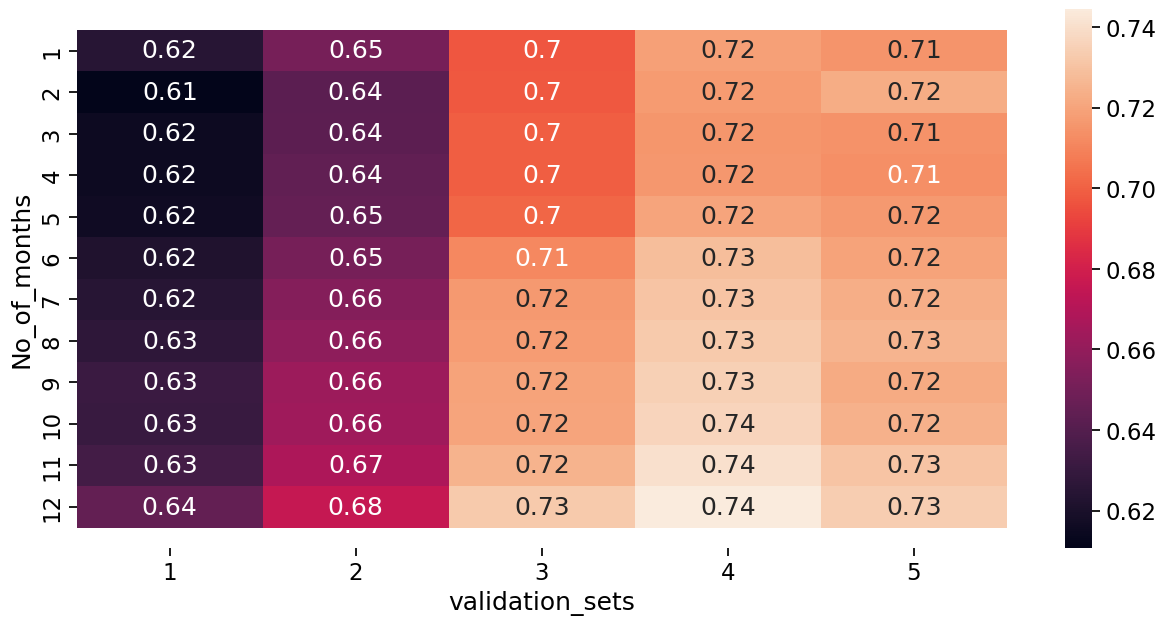

In [ ]:
# correlation plot of the variables in the train data
plot = final_mean[final_mean.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---


- We can see that, as we increase the size of the training period, the value of RMSLE increases. And for 2 months of train data we are getting the best score here and it keeps on increasing as we go further back. So, Let's calculate the results again by keeping the max training period to be 4 months and no of validation sets to be 15.


---

In [ ]:
final_mean2, final_std2 = get_matrix(max_months=4,max_cv=15)

100%|██████████| 4/4 [11:35<00:00, 173.95s/it]


(4.5, -0.5)

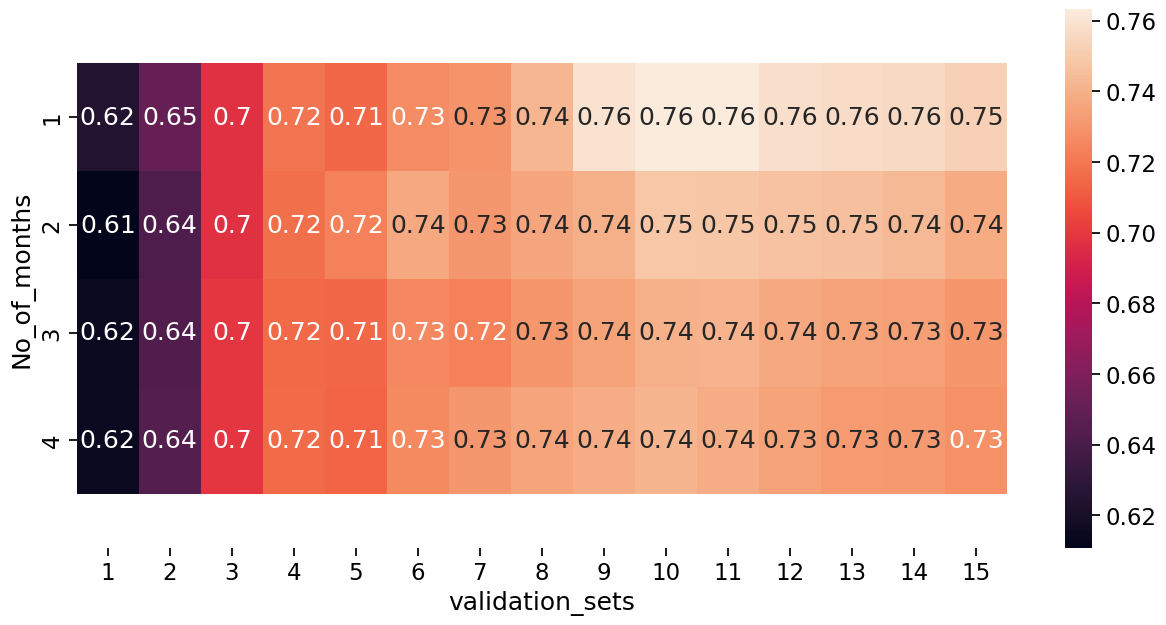

In [ ]:
# correlation plot of the variables in the train data
final_mean2.columns = final_mean2.columns.droplevel()
plot = final_mean2[final_mean2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---

***Now, Using the training period of 2 months, the RMSLE value gets stable after the 9 validation sets to value 0.74.***

![](images/mean_prediction.png)

---



### Standard Deviation

Now, Let's see the standard deviation of the results over the validation sets.

(4.5, -0.5)

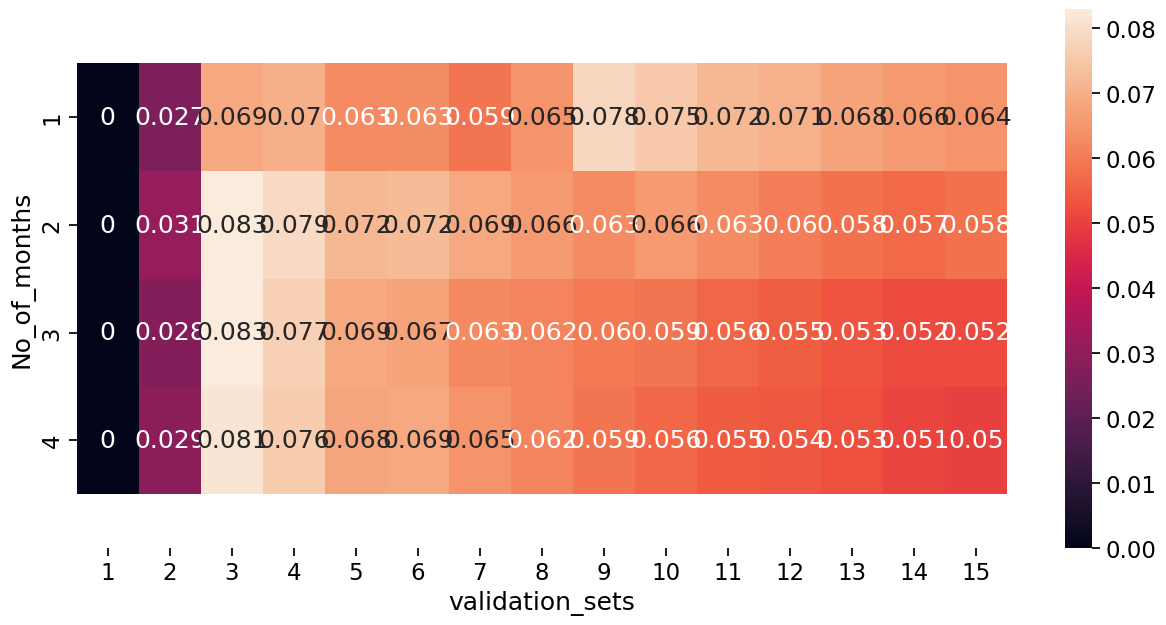

In [ ]:
# correlation plot of the variables in the train data
final_std2.columns = final_std2.columns.droplevel()
plot = final_std2[final_std2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---
The lowest standard deviation is with 14 validation sets, and you can also see that the standard deviation increases with 15th validation set in both 2 and 3 months period results.

---

![](images/std_plot.png)


***So, we will validate our model with 2 months of training period and 14 validation sets.***

---
---

### `FEATURE ENGINEERING`


We will first merge all the datasets that are available to us `train_data`, `product_data` and `store _data` and build a Random Forest model on it. And then, we will engineer some features from the existing datasets and try to improve the performance of the model.



---




In [ ]:
# importing required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error as msle

---
### Read the pre-processed Datasets

We have already updated the datasets like imputing missing values, convert categorical variables into numerical ones and removed the variables with high cardinality.

You can always try and transform the variables according to your business understanding and try to check if that is working well for you or not.


---

In [ ]:
# reading the dataset
train_data = pd.read_csv('updated_train_data.csv')
product_data = pd.read_csv('updated_product_data.csv')
store_data = pd.read_csv('updated_store_data.csv')

In [ ]:
train_data.head(2)

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   

   UNITS  
0     13  
1     20

---

***`Train Data:`***

- **WEEK_END_DATE**: Will be used to divide the data into train, validate and test.
- **STORE_NUM**: Will be used to merge files.
- **UPC**: Will be used to merge files
- **BASE_PRICE**: It was already present in the numeric form.
- **FEATURE**: It was already present in the numeric form.
- **DISPLAY**: It was already present in the numeric form.
- **UNITS**: Target Variable

---

In [ ]:
train_data.isna().sum()

WEEK_END_DATE    0
STORE_NUM        0
UPC              0
PRICE            3
BASE_PRICE       0
FEATURE          0
DISPLAY          0
UNITS            0
dtype: int64

In [ ]:
train_data['PRICE'].fillna(train_data['PRICE'].mean(), inplace=True)

In [ ]:
product_data.head(2)

UPC  MANUFACTURER_1  MANUFACTURER_2  MANUFACTURER_3  MANUFACTURER_4  \
0  1111009477               1               0               0               0   
1  1111009497               1               0               0               0   

   MANUFACTURER_5  MANUFACTURER_6  MANUFACTURER_7  MANUFACTURER_8  \
0               0               0               0               0   
1               0               0               0               0   

   MANUFACTURER_9  ...  CATEGORY_4  SUB_CATEGORY_1  SUB_CATEGORY_2  \
0               0  ...           0               1               0   
1               0  ...           0               1               0   

   SUB_CATEGORY_3  SUB_CATEGORY_4  SUB_CATEGORY_5  SUB_CATEGORY_6  \
0               0               0               0               0   
1               0               0               0               0   

   SUB_CATEGORY_7  PRODUCT_SIZE  PRODUCT_SIZE_BIN  
0               0          15.0                 2  
1               0          15.0                 2  

[2 rows x 23 columns]

---

***`Product Data`***

- **UPC**: Will be used to merge files.
- **MANUFACTURER**: We have transformed the variable by One Hot Encoding.
- **CATEGORY**: We have transformed the variable by One Hot Encoding.
- **SUB_CATEGORY**: We have transformed the variable the variable by One Hot Encoding.
- **PRODUCT_SIZE**: It was initially available as different size units for different categories of products, like `PRETZELS` were available in `Ounces (OZ)` and `MOUTHWASH` were in `MILI LITRES (ML)`. So we defined the bining according the product category and transformed this feature.

---

In [ ]:
store_data.head(2)

STORE_ID  ADDRESS_STATE_PROV_CODE_1  ADDRESS_STATE_PROV_CODE_2  \
0       367                          1                          0   
1       389                          1                          0   

   ADDRESS_STATE_PROV_CODE_3  ADDRESS_STATE_PROV_CODE_4  MSA_CODE_1  \
0                          0                          0           1   
1                          0                          0           1   

   MSA_CODE_2  MSA_CODE_3  MSA_CODE_4  MSA_CODE_5  MSA_CODE_6  MSA_CODE_7  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   

   MSA_CODE_8  MSA_CODE_9  SEG_VALUE_NAME  SALES_AREA_SIZE_NUM  \
0           0           0               1                24721   
1           0           0               2                46073   

   AVG_WEEKLY_BASKETS  
0               12707  
1               24767

---
***`Store Data`***

- **STORE_ID**: Will be used to merge files.
- **ADDRESS_STATE_PROV_CODE**: We have transformed the variable by One Hot Encoding.
- **MSA_CODE**: We have transformed the variable by One Hot Encoding.
- **SEG_VALUE_NAME**: We have transformed the variable by One Hot Encoding.
- **SALES_AREA_SIZE_NUM**:  No changes done to this variable, already present in the numeric form.
- **AVG_WEEKLY_BASKETS**: No changes done to this variable, already present in the numeric form.

---

---
---

### `MERGE ALL THE DATASET`

---

In [ ]:
merged_data = train_data.merge(product_data, how= 'left', on= 'UPC')
merget_data = merged_data.merge(store_data,how='left', left_on = 'STORE_NUM', right_on='STORE_ID')
merged_data.head(2)

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0     14-Jan-09        367  1111009477   1.39        1.57        0        0   
1     14-Jan-09        367  1111009497   1.39        1.39        0        0   

   UNITS  MANUFACTURER_1  MANUFACTURER_2  ...  CATEGORY_4  SUB_CATEGORY_1  \
0     13               1               0  ...           0               1   
1     20               1               0  ...           0               1   

   SUB_CATEGORY_2  SUB_CATEGORY_3  SUB_CATEGORY_4  SUB_CATEGORY_5  \
0               0               0               0               0   
1               0               0               0               0   

   SUB_CATEGORY_6  SUB_CATEGORY_7  PRODUCT_SIZE  PRODUCT_SIZE_BIN  
0               0               0          15.0                 2  
1               0               0          15.0                 2  

[2 rows x 30 columns]

In [ ]:
merged_data.isna().sum()

WEEK_END_DATE       0
STORE_NUM           0
UPC                 0
PRICE               0
BASE_PRICE          0
FEATURE             0
DISPLAY             0
UNITS               0
MANUFACTURER_1      0
MANUFACTURER_2      0
MANUFACTURER_3      0
MANUFACTURER_4      0
MANUFACTURER_5      0
MANUFACTURER_6      0
MANUFACTURER_7      0
MANUFACTURER_8      0
MANUFACTURER_9      0
CATEGORY_1          0
CATEGORY_2          0
CATEGORY_3          0
CATEGORY_4          0
SUB_CATEGORY_1      0
SUB_CATEGORY_2      0
SUB_CATEGORY_3      0
SUB_CATEGORY_4      0
SUB_CATEGORY_5      0
SUB_CATEGORY_6      0
SUB_CATEGORY_7      0
PRODUCT_SIZE        0
PRODUCT_SIZE_BIN    0
dtype: int64

In [ ]:
merged_data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'PRICE', 'BASE_PRICE', 'FEATURE',
       'DISPLAY', 'UNITS', 'MANUFACTURER_1', 'MANUFACTURER_2',
       'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5', 'MANUFACTURER_6',
       'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9', 'CATEGORY_1',
       'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4', 'SUB_CATEGORY_1',
       'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4', 'SUB_CATEGORY_5',
       'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE', 'PRODUCT_SIZE_BIN'],
      dtype='object')

---

So, we have now 28 columns in the merged dataset, We will drop `WEEK_END_DATE`, `STORE_NUM` and `UPC` and train the model on rest of the features with `UNITS` as the target variable.

Initially, we will train and check the performance using the 24 features.

---

---

- ***The `WEEK_END_DATE` needs to be converted into datetime format.***
- ***In the validation strategy notebook, we have defined some functions to create the validation sets dataframe. we are going to use the same function here in this notebook also.***


In [ ]:
# convert to datetime
merged_data.WEEK_END_DATE = pd.to_datetime(merged_data.WEEK_END_DATE)

# create an array of unique week dates
week = merged_data.WEEK_END_DATE.unique()

In [ ]:
from datetime import timedelta
def validation_df(data, week, no_of_months, no_of_validation):

    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break


    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df

In [ ]:
validation_df(merged_data, week, no_of_months=2, no_of_validation=14)

train_shape  validation_shape  test_shape train_start  train_end  \
0         13089              1640        1642  2011-07-13 2011-08-31   
1         13102              1632        1638  2011-07-06 2011-08-24   
2         13101              1629        1640  2011-06-29 2011-08-17   
3         13101              1640        1632  2011-06-22 2011-08-10   
4         13109              1638        1629  2011-06-15 2011-08-03   
5         13108              1631        1640  2011-06-08 2011-07-27   
6         13108              1640        1638  2011-06-01 2011-07-20   
7         13112              1637        1631  2011-05-25 2011-07-13   
8         13104              1635        1640  2011-05-18 2011-07-06   
9         13101              1639        1637  2011-05-11 2011-06-29   
10        13106              1642        1635  2011-05-04 2011-06-22   
11        13102              1639        1639  2011-04-27 2011-06-15   
12        13096              1638        1642  2011-04-20 2011-06-08   
13        13093              1639        1639  2011-04-13 2011-06-01   

   validate_week  test_week no_days_train set_no  
0     2011-09-14 2011-09-28       56 days   set1  
1     2011-09-07 2011-09-21       56 days   set2  
2     2011-08-31 2011-09-14       56 days   set3  
3     2011-08-24 2011-09-07       56 days   set4  
4     2011-08-17 2011-08-31       56 days   set5  
5     2011-08-10 2011-08-24       56 days   set6  
6     2011-08-03 2011-08-17       56 days   set7  
7     2011-07-27 2011-08-10       56 days   set8  
8     2011-07-20 2011-08-03       56 days   set9  
9     2011-07-13 2011-07-27       56 days  set10  
10    2011-07-06 2011-07-20       56 days  set11  
11    2011-06-29 2011-07-13       56 days  set12  
12    2011-06-22 2011-07-06       56 days  set13  
13    2011-06-15 2011-06-29       56 days  set14

In [ ]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

# function to return the columns on which the model is trained
def get_colums(data):
    print('\n####### The model is trained on Following Columns: ###########\n')
    print(data.columns)
    print('===============================================================')


# function to train the model
# it will calculate and return the RMSLE on train and validation set
def my_model(train_d, validate_d, model):
    train_x = train_d.drop(columns=['WEEK_END_DATE', 'UNITS'])
    train_y = train_d['UNITS']

    valid_x = validate_d.drop(columns=['WEEK_END_DATE', 'UNITS'])
    valid_y = validate_d['UNITS']

    model.fit(train_x, train_y)

    predict_train = model.predict(train_x)
    predict_train = predict_train.clip(min=0)

    predict_validate = model.predict(valid_x)
    predict_validate = predict_validate.clip(min=0)

    return get_msle(train_y, predict_train), get_msle(valid_y, predict_validate), train_x



# function will extract the train and validation set using validation set dataframe
# The defined model will train on each of the set and the average RMSLE on train and validate set will be returned
def train_model(df, data, model):

    model_results_train = []
    model_results_valid = []
    for row in tqdm_notebook(range(df.shape[0]),leave=False, desc='training_model'):

        row = df.iloc[row]
        train_set = data[(data.WEEK_END_DATE >= row['train_start']) & (data.WEEK_END_DATE <= row['train_end'])]
        validate_set = data[data.WEEK_END_DATE == row['validate_week']]
        train, valid, data_train = my_model(train_set,validate_set, model)
        model_results_train.append(train)
        model_results_valid.append(valid)

    return np.mean(model_results_train) , np.mean(model_results_valid), data_train

---

![](images/architecture1.png)

---

---
---





### `OPTIMUM VALUE OF N_ESTIMATORS`


- First of all, we will calculate the performance of the model using the default features and we will try to tune the parameters to get the best results.

- So, first we will find out the optimal value of n_estimators for the Random Forest Model and we will see the performance of the model on n_estimators value 5, 15, 25..... 245.

---

In [ ]:
estimator_results = []
data = merged_data.drop(columns=['STORE_NUM', 'UPC'])


valid_df = validation_df(merged_data, week, no_of_months=2, no_of_validation= 14)

for estimator in tqdm_notebook(range(5,250,10),leave=True, desc= 'estimator'):
    result = {}
    model_RFR = RandomForestRegressor(n_estimators= estimator, random_state=0)
    rmsle_train, rmsle_valid, data_train = train_model(valid_df, data, model_RFR)
    result['estimator'] = estimator
    result['rmsle_train'] = rmsle_train
    result['rmsle_valid'] = rmsle_valid
    estimator_results.append(result)

get_colums(data_train)

estimator:   0%|          | 0/25 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]


####### The model is trained on Following Columns: ###########

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN'],
      dtype='object')


In [ ]:
x = pd.DataFrame.from_dict(estimator_results)
x

estimator  rmsle_train  rmsle_valid
0           5     0.512508     0.663946
1          15     0.508982     0.651263
2          25     0.507961     0.649851
3          35     0.507538     0.649048
4          45     0.507523     0.648237
5          55     0.507450     0.647991
6          65     0.507247     0.647951
7          75     0.507197     0.647894
8          85     0.507100     0.647614
9          95     0.507077     0.647525
10        105     0.507073     0.647327
11        115     0.507048     0.647142
12        125     0.506981     0.646833
13        135     0.506941     0.646401
14        145     0.506930     0.645910
15        155     0.506918     0.645982
16        165     0.506921     0.646332
17        175     0.506921     0.645500
18        185     0.506916     0.645464
19        195     0.506886     0.645460
20        205     0.506895     0.645445
21        215     0.506899     0.645340
22        225     0.506890     0.645361
23        235     0.506896     0.645356
24        245     0.506885     0.645252

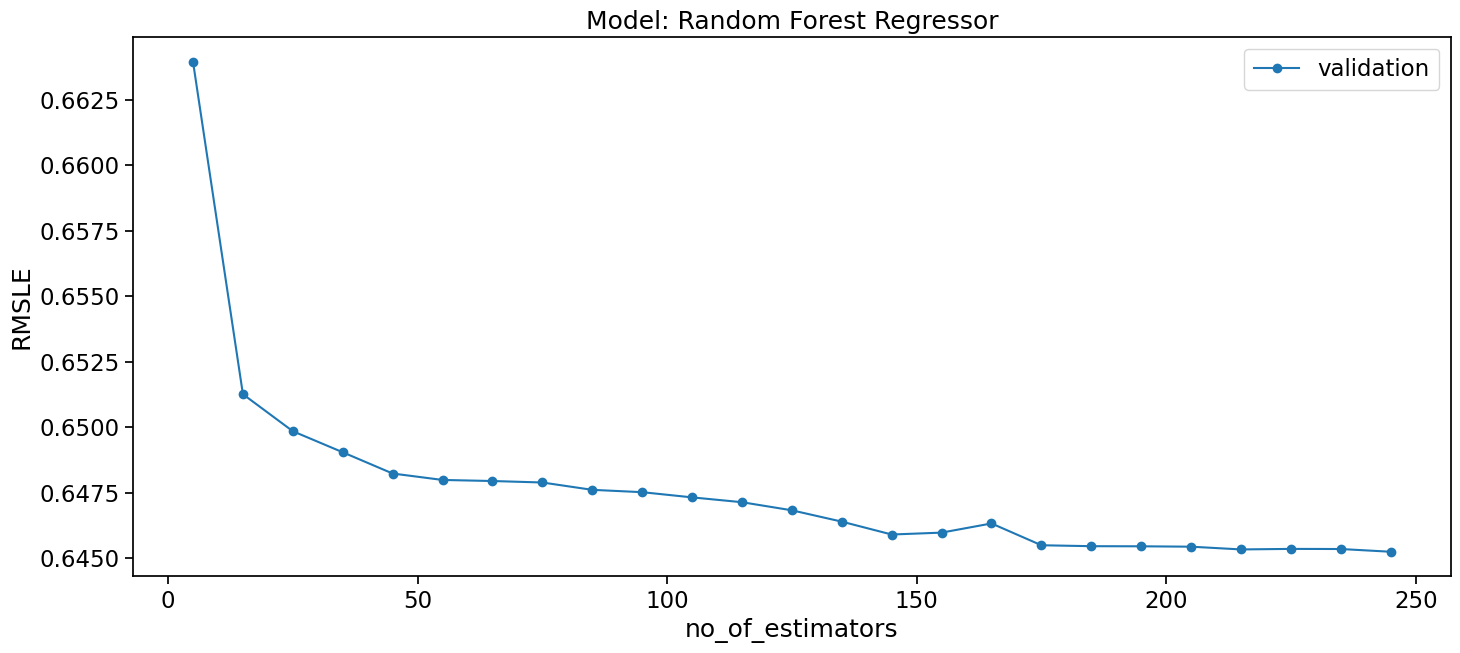

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(x['estimator'], x['rmsle_valid'], marker='o',label='validation');
plt.title('Model: Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('no_of_estimators')
plt.legend();

---
### `N_ESTIMATORS = 175`
---

The `RMSLE` is lowest on `n_estimators` value `175` is around 0.667 and seems to get stable after that. So, we will keep the value of the n_estimators = 175.



---

### `OPTIMUM VALUE OF MAX_DEPTH`
---

Now, we will keep the value of `n_estimators` fixed as `175` and try different values of max_depth from 1, 2, ...29.

---

In [ ]:
depth_results = []
data = merged_data.drop(columns=['STORE_NUM', 'UPC'])


valid_df = validation_df(merged_data, week, no_of_months=2, no_of_validation= 14)
for depth in tqdm_notebook(range(1,30,1), leave=True, desc= 'max_depth'):
    result = {}

    model_RFR = RandomForestRegressor(max_depth=depth,n_estimators=175)

    rmsle_train, rmsle_valid , data_train = train_model(valid_df, data, model_RFR)
    result['depth'] = depth
    result['rmsle_train'] = rmsle_train
    result['rmsle_valid'] = rmsle_valid
    depth_results.append(result)

get_colums(data_train)

max_depth:   0%|          | 0/29 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]


####### The model is trained on Following Columns: ###########

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN'],
      dtype='object')


In [ ]:
x = pd.DataFrame.from_dict(depth_results)
x

depth  rmsle_train  rmsle_valid
0       1     0.934319     0.937016
1       2     0.813167     0.830375
2       3     0.754247     0.774982
3       4     0.705744     0.728101
4       5     0.669925     0.703537
5       6     0.636088     0.681255
6       7     0.608546     0.664217
7       8     0.582754     0.651243
8       9     0.563654     0.642289
9      10     0.548342     0.638955
10     11     0.536840     0.640169
11     12     0.528576     0.638880
12     13     0.522375     0.639362
13     14     0.517502     0.642060
14     15     0.514062     0.642026
15     16     0.511650     0.642858
16     17     0.509950     0.643848
17     18     0.508832     0.645612
18     19     0.508069     0.644351
19     20     0.507601     0.643686
20     21     0.507253     0.645432
21     22     0.507164     0.646490
22     23     0.507036     0.645250
23     24     0.506937     0.645170
24     25     0.506939     0.646454
25     26     0.506937     0.646820
26     27     0.506856     0.644550
27     28     0.506899     0.644704
28     29     0.506894     0.646479

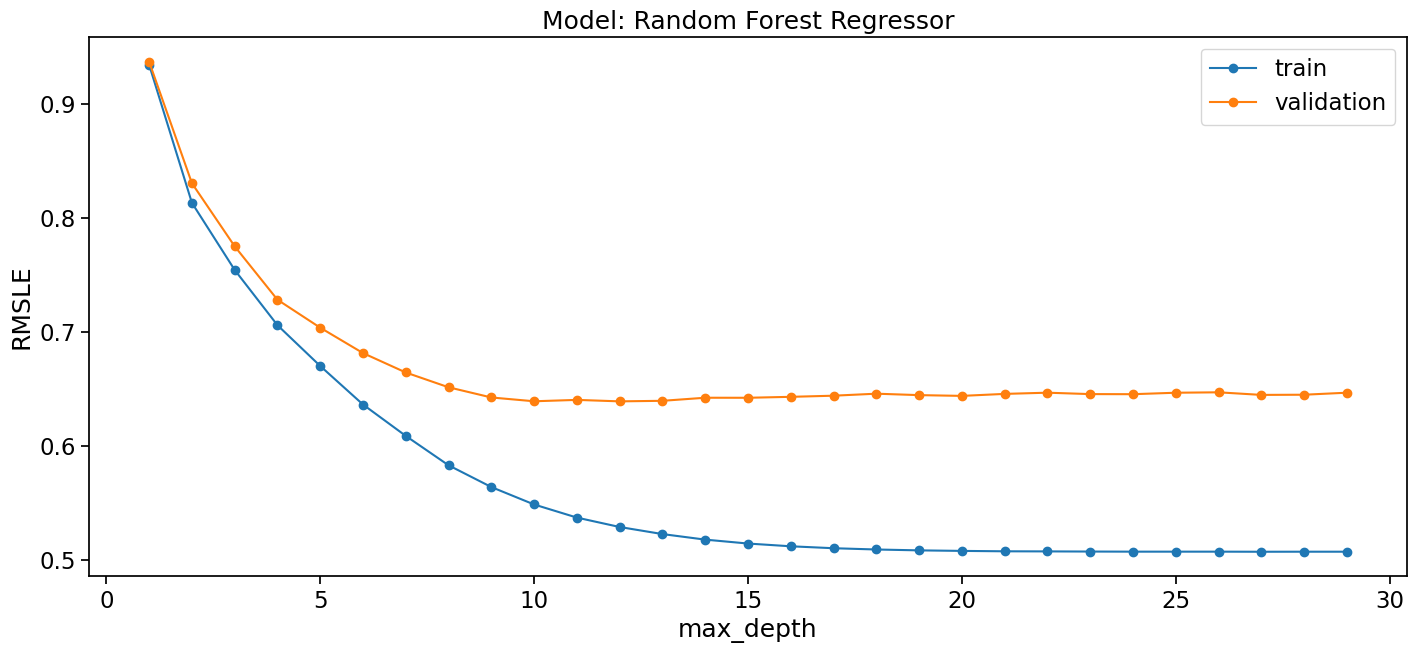

In [ ]:

plt.figure(figsize=(17,7))
plt.plot(x['depth'], x['rmsle_train'], marker='o',label='train');
plt.plot(x['depth'], x['rmsle_valid'], marker='o',label='validation');
plt.title('Model: Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('max_depth')
plt.legend();

### `MAX_DEPTH = 10`

The RMSLE gets stable on both validation and train set after max_depth 10 and the RMSLE is still around 0.67

---
---

### `ADD TIME BASED FEATURES`

- Now, we will add some Time based features to the data like year of the transaction, month, day, day_of_year, week, quarter.

- And we will once again check the performace of the model for different max_depth 1 to 29 and will decide whether we have selected the right value of max_depth or not.



---

In [ ]:
# year
merged_data['year']  = merged_data['WEEK_END_DATE'].dt.year
# month
merged_data['month'] = merged_data['WEEK_END_DATE'].dt.month
# day
merged_data['day'] = merged_data['WEEK_END_DATE'].dt.day
# day_of year
merged_data['day_of_year'] = merged_data['WEEK_END_DATE'].dt.dayofyear
# week
merged_data["week"] = merged_data['WEEK_END_DATE'].dt.week
# quarter
merged_data["quarter"] = merged_data['WEEK_END_DATE'].dt.quarter

In [ ]:
depth_results = []
data = merged_data.drop(columns=['STORE_NUM', 'UPC'])

valid_df = validation_df(merged_data, week, no_of_months=2, no_of_validation= 14)
for depth in tqdm_notebook(range(1,16,1), desc='max_depth', leave=True):
    result = {}

    model_RFR = RandomForestRegressor(max_depth= depth, n_estimators= 175)

    rmsle_train, rmsle_valid, data_train = train_model(valid_df, data, model_RFR)
    result['depth'] = depth
    result['rmsle_train'] = rmsle_train
    result['rmsle_valid'] = rmsle_valid
    depth_results.append(result)

get_colums(data_train)

max_depth:   0%|          | 0/15 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

training_model:   0%|          | 0/14 [00:00<?, ?it/s]


####### The model is trained on Following Columns: ###########

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN', 'year', 'month', 'day', 'day_of_year', 'week',
       'quarter'],
      dtype='object')


In [ ]:
x = pd.DataFrame.from_dict(depth_results)
x

depth  rmsle_train  rmsle_valid
0       1     0.933997     0.936629
1       2     0.813603     0.831236
2       3     0.754644     0.775633
3       4     0.705904     0.730537
4       5     0.669503     0.704797
5       6     0.634923     0.685368
6       7     0.606842     0.671895
7       8     0.579113     0.661529
8       9     0.557793     0.658074
9      10     0.538993     0.653577
10     11     0.523396     0.656648
11     12     0.510135     0.653767
12     13     0.499742     0.656118
13     14     0.490767     0.657101
14     15     0.483686     0.657056

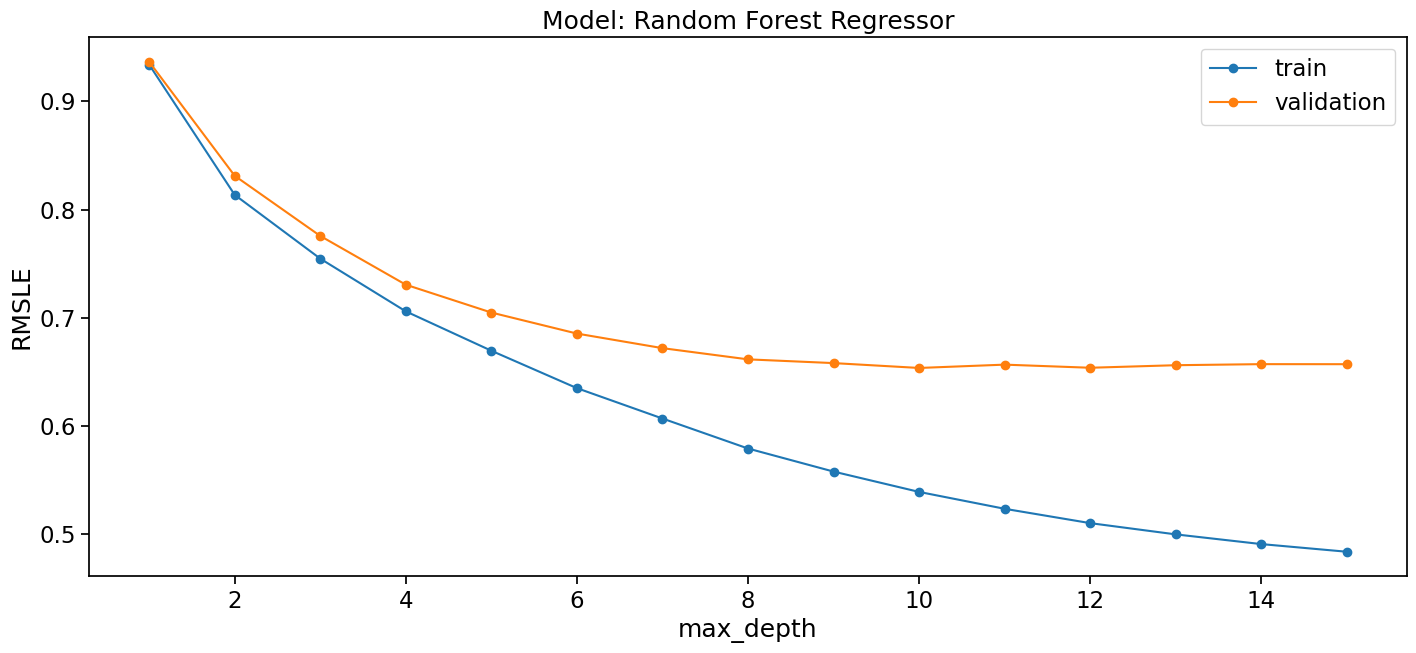

In [ ]:
x = pd.DataFrame.from_dict(depth_results)
plt.figure(figsize=(17,7))
plt.plot(x['depth'], x['rmsle_train'], marker='o',label='train');
plt.plot(x['depth'], x['rmsle_valid'], marker='o',label='validation');
plt.title('Model: Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('max_depth')
plt.legend();

---
---

***So, we can still see that the value of RMSLE on both train and validation set is getting stable after the max_depth 10. Now, we will keep on adding the new features to the data and check if it is improving the results or not.***



- `max_depth` : 10
- `no_of_estimators` : 175


---
---

## `NEW FEATURES`


---

 - `FOR EACH STORE_ID WE WILL FIND`

  - **UNIQUE NUMBER OF MANUFACTURERS**
       - For, each of the stores we will find out the number of unique number of manufactures as a feature. We are assumuing that more number of manufactures will give more options to the customers and will impact the sales.
       - We will have to use the original `train_data` and `product_data` to calculate this as we have encoded this feature during the pre-processing step.
  - **UNIQUE NUMBER OF CATEGORY AND SUB_CATEGORIES THEY HAVE**    
      - Similarly, we will find out the unique number of categories and sub categories that a particular store has.
     
     
---

In [ ]:
# read the columns 'STORE_NUM' and 'UPC' from the train data
original_train_data = pd.read_csv('train.csv', usecols= ['STORE_NUM','UPC'])

In [ ]:
# read the original product_data
original_product_data = pd.read_csv('product_data.csv')
original_product_data.head(5)

UPC               DESCRIPTION   MANUFACTURER               CATEGORY  \
0  1111009477    PL MINI TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
1  1111009497         PL PRETZEL STICKS  PRIVATE LABEL             BAG SNACKS   
2  1111009507         PL TWIST PRETZELS  PRIVATE LABEL             BAG SNACKS   
3  1111038078  PL BL MINT ANTSPTC RINSE  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   
4  1111038080  PL ANTSPTC SPG MNT MTHWS  PRIVATE LABEL  ORAL HYGIENE PRODUCTS   

               SUB_CATEGORY PRODUCT_SIZE  
0                  PRETZELS        15 OZ  
1                  PRETZELS        15 OZ  
2                  PRETZELS        15 OZ  
3  MOUTHWASHES (ANTISEPTIC)       500 ML  
4  MOUTHWASHES (ANTISEPTIC)       500 ML

In [ ]:
# merge the train and product data
original_train_data = original_train_data.merge(original_product_data, how='left',on = 'UPC')

In [ ]:
# Now, we will create another dataframe unique_store_data
# We will group the data by STORE_NUM and find unique values of the features 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'

unique_store_data = original_train_data.groupby(['STORE_NUM'])['MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'].nunique().reset_index()

In [ ]:
# rename the columns of the dataframe 'unique_store_data'
unique_store_data.columns = ['STORE_NUM', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY']

In [ ]:
# now , merge this new dataframe with the dataframe that has all the features.
data_with_unique_store = merged_data.merge(unique_store_data, how= 'left', on= 'STORE_NUM')
# let's have a look at the data
data_with_unique_store.head()

WEEK_END_DATE  STORE_NUM         UPC  PRICE  BASE_PRICE  FEATURE  DISPLAY  \
0    2009-01-14        367  1111009477   1.39        1.57        0        0   
1    2009-01-14        367  1111009497   1.39        1.39        0        0   
2    2009-01-14        367  1111085319   1.88        1.88        0        0   
3    2009-01-14        367  1111085345   1.88        1.88        0        0   
4    2009-01-14        367  1111085350   1.98        1.98        0        0   

   UNITS  MANUFACTURER_1  MANUFACTURER_2  ...  PRODUCT_SIZE_BIN  year  month  \
0     13               1               0  ...                 2  2009      1   
1     20               1               0  ...                 2  2009      1   
2     14               1               0  ...                 1  2009      1   
3     29               1               0  ...                 3  2009      1   
4     35               1               0  ...                 3  2009      1   

   day  day_of_year  week  quarter  U_MANUFACTURER  U_CATEGORY  U_SUB_CATEGORY  
0   14           14     3        1               4           3               5  
1   14           14     3        1               4           3               5  
2   14           14     3        1               4           3               5  
3   14           14     3        1               4           3               5  
4   14           14     3        1               4           3               5  

[5 rows x 39 columns]

In [ ]:
# train a model with the new features.
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)
new_data = data_with_unique_store.drop(columns=['STORE_NUM', 'UPC'])

valid_df = validation_df(new_data, week, no_of_months=2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, new_data, model_RFR)

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.4779852726762397
RMSLE on validation set: 0.6010402856270065


In [ ]:
data_train.columns

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN', 'year', 'month', 'day', 'day_of_year', 'week',
       'quarter', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY'],
      dtype='object')

---

***Here, we can see that there is significant improvement in the model performance. On the validation set RMSLE is now `0.600`***

---

---
---

### `GET LAG FEATURES`


Now, we will create the lag features, which will be the number of units ordered of the same product from the same store at exactly one year ago.

---

In [ ]:
# define a function that will return calculate the units sold number of a particular product from a particular store.
# We need to calculate this for 52 Weeks or 1 Year

def get_lag_feature(data, no_of_week=1, return_Series= False):
    data_copy = data.copy()
    sample_1 = data_copy[['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS']]
    data_copy['NEW_DATE'] = data_copy.WEEK_END_DATE + timedelta(days = no_of_week*7)
    data_copy['PAST_DATE'] = data_copy.WEEK_END_DATE

    sample_2 = data_copy[['NEW_DATE','PAST_DATE', 'STORE_NUM', 'UPC', 'UNITS']]
    final = sample_1.merge(sample_2, how = 'left', left_on = ['WEEK_END_DATE', 'STORE_NUM', 'UPC'], right_on = ['NEW_DATE', 'STORE_NUM', 'UPC'])
    final = final.drop(columns=['NEW_DATE'])
    final.fillna(0,inplace = True)

    if return_Series:
        return final['UNITS_y']
    else: return final

In [ ]:
# Let's verify the function is correct or not.
# In the following dataframe, We have UNITS_x as the units sold on the transaction data
# In the following dataframe, We have UNITS_y as the units sold on the PAST_DATE

get_lag_feature(merged_data, no_of_week = 8)

WEEK_END_DATE  STORE_NUM         UPC  UNITS_x            PAST_DATE  \
0         2009-01-14        367  1111009477       13                    0   
1         2009-01-14        367  1111009497       20                    0   
2         2009-01-14        367  1111085319       14                    0   
3         2009-01-14        367  1111085345       29                    0   
4         2009-01-14        367  1111085350       35                    0   
...              ...        ...         ...      ...                  ...   
232261    2011-09-28      29159  7192100336       32  2011-08-03 00:00:00   
232262    2011-09-28      29159  7192100337       31  2011-08-03 00:00:00   
232263    2011-09-28      29159  7192100339       23  2011-08-03 00:00:00   
232264    2011-09-28      29159  7797502248        8  2011-08-03 00:00:00   
232265    2011-09-28      29159  7797508004        7  2011-08-03 00:00:00   

        UNITS_y  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
232261     16.0  
232262     10.0  
232263     13.0  
232264      7.0  
232265      7.0  

[232266 rows x 6 columns]

In [ ]:
# let's see the last third row of the dataframe
merged_data.loc[(merged_data.WEEK_END_DATE == '2011-09-28') & (merged_data.STORE_NUM == 29159) & (merged_data.UPC == 7192100339), 'UNITS']

232263    23
Name: UNITS, dtype: int64

In [ ]:
merged_data.loc[(merged_data.WEEK_END_DATE == '2011-08-03') & (merged_data.STORE_NUM == 29159) & (merged_data.UPC == 7192100339), 'UNITS']

219173    13
Name: UNITS, dtype: int64

In [ ]:
#  create a feature UNITS BEFORE 52_WEEK
data_with_unique_store['UNITS_BEFORE_52WEEK'] = get_lag_feature(data_with_unique_store, no_of_week= 52, return_Series= True)

In [ ]:
# train the model with the new feature

model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)

new_data = data_with_unique_store.drop(columns= ['STORE_NUM', 'UPC'])
valid_df = validation_df(new_data, week, no_of_months=2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, new_data, model_RFR)

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# mean RMSLE on train and validation set
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.41805394001809987
RMSLE on validation set: 0.5740266934683219


In [ ]:
# columns on the updated data.
data_train.columns

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN', 'year', 'month', 'day', 'day_of_year', 'week',
       'quarter', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY',
       'UNITS_BEFORE_52WEEK'],
      dtype='object')

---

***We can see a slight improvement in the RMSLE on the validaiton set. It is `0.585` now***

---

---

### `DIFFERENCE IN PRICE FROM LAST WEEK`

This will be our new feature. Whether the increase/decrease in price from the last week makes any difference to the model or not.


---

In [ ]:
# get the price difference
data_with_unique_store['price_difference'] = data_with_unique_store['BASE_PRICE'] - data_with_unique_store.groupby(['STORE_NUM', 'UPC'])['BASE_PRICE'].shift(1)

In [ ]:
# let's verify we have calculated the right price difference or not
data_with_unique_store.loc[(data_with_unique_store.STORE_NUM == 367) & (data_with_unique_store.UPC == 1111009477),['STORE_NUM', 'UPC', 'BASE_PRICE', 'price_difference','UNITS']].head(10)

STORE_NUM         UPC  BASE_PRICE  price_difference  UNITS
0            367  1111009477        1.57               NaN     13
1640         367  1111009477        1.57              0.00     24
3276         367  1111009477        1.36             -0.21      7
4912         367  1111009477        1.38              0.02     12
6552         367  1111009477        1.50              0.12     16
8179         367  1111009477        1.49             -0.01     21
9814         367  1111009477        1.49              0.00     11
11427        367  1111009477        1.49              0.00     10
13040        367  1111009477        1.39             -0.10     13
14677        367  1111009477        1.48              0.09     13

In [ ]:
# fill the null values in the price difference with 0
data_with_unique_store.price_difference.fillna(0,inplace=True)

In [ ]:
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)

new_data = data_with_unique_store.drop(columns=['STORE_NUM', 'UPC'])

valid_df = validation_df(new_data, week, no_of_months= 2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, new_data, model_RFR)

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.41869743295247985
RMSLE on validation set: 0.5720321124575788


In [ ]:
data_train.columns

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN', 'year', 'month', 'day', 'day_of_year', 'week',
       'quarter', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY',
       'UNITS_BEFORE_52WEEK', 'price_difference'],
      dtype='object')

---

The performance of the model has not changed. It is same as before.

----
---

### `AVERAGE BEFORE 2 MONTH`

- As we have one week gap between the training period and the validation set so for each store and product combination we will calculate the average units sold in 2 months before 1 week.
- In simple terms, the average number of units sold from 7 days to 63 days ago
- Let's see is this feature useful to us or not.

---

In [ ]:
# make 2 columns one with 63 days difference from the week end date and another with 7 days difference
data_with_unique_store['2_MONTH_BEFORE'] = data_with_unique_store.WEEK_END_DATE - timedelta(days=63)
data_with_unique_store['1_WEEK_BEFORE'] = data_with_unique_store.WEEK_END_DATE - timedelta(days=7)

In [ ]:
data_with_unique_store[['WEEK_END_DATE', '2_MONTH_BEFORE', '1_WEEK_BEFORE']].tail()

WEEK_END_DATE 2_MONTH_BEFORE 1_WEEK_BEFORE
232261    2011-09-28     2011-07-27    2011-09-21
232262    2011-09-28     2011-07-27    2011-09-21
232263    2011-09-28     2011-07-27    2011-09-21
232264    2011-09-28     2011-07-27    2011-09-21
232265    2011-09-28     2011-07-27    2011-09-21

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
# calculate the average units in the period
def get_average_units(x):
    data_2month = data_with_unique_store[(data_with_unique_store.WEEK_END_DATE <= x['1_WEEK_BEFORE']) & (data_with_unique_store['WEEK_END_DATE'] >= x['2_MONTH_BEFORE']) & (data_with_unique_store['STORE_NUM'] == x['STORE_NUM']) & (data_with_unique_store['UPC'] == x['UPC']) ]
    return data_2month.UNITS.mean()

In [ ]:
data_with_unique_store['AVERAGE_UNITS_IN_2_MONTH'] = data_with_unique_store.progress_apply(get_average_units,axis=1)

  0%|          | 0/232266 [00:00<?, ?it/s]

In [ ]:
# fill the null values with 0
data_with_unique_store.AVERAGE_UNITS_IN_2_MONTH.fillna(0,inplace=True)

In [ ]:
# drop the date columns that we have created, as they are of no use now.
new_data = data_with_unique_store.drop(columns=['2_MONTH_BEFORE','1_WEEK_BEFORE', 'STORE_NUM', 'UPC'])

In [ ]:
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=175)

valid_df = validation_df(new_data, week, no_of_months=2, no_of_validation= 14)

rmsle_train, rmsle_valid, data_train = train_model(valid_df,new_data, model_RFR)

training_model:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.34044456284619934
RMSLE on validation set: 0.46081518656637804


In [ ]:
data_train.columns

Index(['PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'PRODUCT_SIZE',
       'PRODUCT_SIZE_BIN', 'year', 'month', 'day', 'day_of_year', 'week',
       'quarter', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY',
       'UNITS_BEFORE_52WEEK', 'price_difference', 'AVERAGE_UNITS_IN_2_MONTH'],
      dtype='object')

---

- The last feature that we added has made significant improvement in the RMSLE score on the validation data.
- The RMSLE is now `0.4677`

In [ ]:
data_with_unique_store.to_csv('final_data.csv',index=False)

---


## `Testing Final Models and Feature Importance`


---

In [ ]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from datetime import timedelta
from sklearn.metrics import mean_squared_log_error as msle

In [ ]:
# read the dataset
data = pd.read_csv('final_data.csv')

In [ ]:
# check for the null values
data.isna().sum().sum()

0

In [ ]:
data.loc[0]

WEEK_END_DATE               2009-01-14
STORE_NUM                          367
UPC                         1111009477
PRICE                             1.39
BASE_PRICE                        1.57
FEATURE                              0
DISPLAY                              0
UNITS                               13
MANUFACTURER_1                       1
MANUFACTURER_2                       0
MANUFACTURER_3                       0
MANUFACTURER_4                       0
MANUFACTURER_5                       0
MANUFACTURER_6                       0
MANUFACTURER_7                       0
MANUFACTURER_8                       0
MANUFACTURER_9                       0
CATEGORY_1                           1
CATEGORY_2                           0
CATEGORY_3                           0
CATEGORY_4                           0
SUB_CATEGORY_1                       1
SUB_CATEGORY_2                       0
SUB_CATEGORY_3                       0
SUB_CATEGORY_4                       0
SUB_CATEGORY_5           

In [ ]:
# drop the columns that are not required
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [ ]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [ ]:
week = data.WEEK_END_DATE.unique()

In [ ]:
def validation_df(data, week, no_of_months, no_of_validation):

    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break


    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df

In [ ]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

train_start_1 train_end_1 train_start_2 validate_week  test_week  \
0     2011-07-13  2011-08-31    2011-07-27    2011-09-14 2011-09-28   
1     2011-07-06  2011-08-24    2011-07-20    2011-09-07 2011-09-21   
2     2011-06-29  2011-08-17    2011-07-13    2011-08-31 2011-09-14   
3     2011-06-22  2011-08-10    2011-07-06    2011-08-24 2011-09-07   
4     2011-06-15  2011-08-03    2011-06-29    2011-08-17 2011-08-31   
5     2011-06-08  2011-07-27    2011-06-22    2011-08-10 2011-08-24   
6     2011-06-01  2011-07-20    2011-06-15    2011-08-03 2011-08-17   
7     2011-05-25  2011-07-13    2011-06-08    2011-07-27 2011-08-10   
8     2011-05-18  2011-07-06    2011-06-01    2011-07-20 2011-08-03   
9     2011-05-11  2011-06-29    2011-05-25    2011-07-13 2011-07-27   
10    2011-05-04  2011-06-22    2011-05-18    2011-07-06 2011-07-20   
11    2011-04-27  2011-06-15    2011-05-11    2011-06-29 2011-07-13   
12    2011-04-20  2011-06-08    2011-05-04    2011-06-22 2011-07-06   
13    2011-04-13  2011-06-01    2011-04-27    2011-06-15 2011-06-29   

   no_days_train_1 no_days_train_2 set_no  
0          56 days         56 days   set1  
1          56 days         56 days   set2  
2          56 days         56 days   set3  
3          56 days         56 days   set4  
4          56 days         56 days   set5  
5          56 days         56 days   set6  
6          56 days         56 days   set7  
7          56 days         56 days   set8  
8          56 days         56 days   set9  
9          56 days         56 days  set10  
10         56 days         56 days  set11  
11         56 days         56 days  set12  
12         56 days         56 days  set13  
13         56 days         56 days  set14

In [ ]:
# define a function to calculate the evaluation sets.
# this time we will include test set also
def get_evaluation_sets(data, df):
    evaluation_set = []

    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [ ]:
# get the evaluation sets
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation=14)
                                     )

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [ ]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

---

***Define function to calculate results on the evaluation sets.***

---

In [ ]:
def get_results_on_evaluation_set(eval_set, model):
    results = []
    set_n = 1
    for eval_data in tqdm(eval_set):

        x = {}
        train_data_1, validate, train_data_2, test = eval_data

        # separate the independent and target variables from train and valid
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']

        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']

        train_data_2_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_2_y = train_data_2['UNITS']

        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']


        # fit the model on the training data
        model_valid = model.fit(train_data_1_x, train_data_1_y)

        # predict the target on train and validate
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)


        # fit the model on the training data
        model_test  = model.fit(train_data_2_x, train_data_2_y)

        # predict the target on train and test
        predict_train_2 = model_test.predict(train_data_2_x).clip(min=0)
        predict_test    = model_test.predict(test_x).clip(min=0)


        # calculate the rmsle on train and valid
        rmsle_train_1 = get_msle(train_data_1_y, predict_train_1)
        rmsle_valid   = get_msle(validate_y, predict_valid)

        # calculate the rmsle on train and test
        rmsle_train_2 = get_msle(train_data_2_y, predict_train_2)
        rmsle_test    = get_msle(test_y, predict_test)


        x['set_no'] = set_n
        set_n +=1
        x['rmsle_train_1'] = rmsle_train_1
        x['rmsle_valid'] = rmsle_valid
        x['rmsle_train_2'] = rmsle_train_2
        x['rmsle_test'] = rmsle_test
        results.append(x)


    return pd.DataFrame.from_dict(results)


In [ ]:
# define function to get the best 10 feature importance plot
def get_feature_importance(eval_set, model):
    train_data_1, validate, train_data_2, test = eval_set

    train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_data_y = train_data_2['UNITS']

    test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']

    model.fit(train_data_x, train_data_y)
    (pd.Series(model.feature_importances_, index=train_data_x.columns).nlargest(10).plot(kind='barh'))


---

## `RANDOM FOREST`

---

In [ ]:
### define randomforest model
model_rf = RandomForestRegressor(max_depth=10, n_estimators=175, random_state=0)

# calculate the results using the random forest
results_RFR = get_results_on_evaluation_set(evaluation_sets, model_rf)

100%|██████████| 14/14 [04:06<00:00, 17.61s/it]


In [ ]:
results_RFR[['rmsle_train_2', 'rmsle_test']]

rmsle_train_2  rmsle_test
0        0.350602    0.411522
1        0.354616    0.493730
2        0.355195    0.415886
3        0.345287    0.459826
4        0.341424    0.558863
5        0.344649    0.470151
6        0.334453    0.463753
7        0.333277    0.534483
8        0.330174    0.431620
9        0.331476    0.461010
10       0.340073    0.480501
11       0.342064    0.428297
12       0.340506    0.429245
13       0.338532    0.437915

In [ ]:
# average rmsle
results_RFR[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.341595
rmsle_test       0.462629
dtype: float64